## Tasks

- [ ] improve decision logic for image rotation
- [ ] take care of images with different (non-paper boundaries)

In [1]:
import os
import sys
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

project_dirname = '../admin/cursive_ai'
sys.path.append(project_dirname)
import util
import text_region_extractor as tre

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = f'{project_dirname}/camera_images'

image_filenames = glob.glob(f'{data_dir}/*.jpg')
print('number of images:', len(image_filenames))

number of images: 70


In [3]:
images_to_be_rotated = list(range(6716, 6723)) + list(range(6724, 6750)) + ['20180725_131908', '20180725_131920', '20180725_132409', '20180725_132414', '20180725_132419', '20180725_132423', '20180725_132433', '20180725_132438', '20180725_132449', '20180725_132459', '20180725_132504', '20180725_132508']
images_to_be_rotated = [f'IMG_{img}.jpg' for img in images_to_be_rotated]
print('#images which need rotation:', len(images_to_be_rotated))

#images which need rotation: 45


In [4]:
import matplotlib.patches as patches

def show_bboxes(bboxes, img, bboxes2=None, title='') -> None:
    """
    Takes 1 or 2 lists of bboxes and an image,
    and displays the bboxes on the image in red and green colors respectively
    """
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    _, ax = plt.subplots(figsize=(20, 20))
    if title:
        plt.title(title)
    for bbox in bboxes:
        rect = patches.Rectangle((bbox['x1'], bbox['y1']), bbox['x2'] - bbox['x1'], bbox['y2'] - bbox['y1'],
                                 linewidth=5, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    if bboxes2:
        for bbox in bboxes2:
            rect = patches.Rectangle((bbox['x1'], bbox['y1']), bbox['x2'] - bbox['x1'], bbox['y2'] - bbox['y1'],
                                     linewidth=5, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
    plt.imshow(img_rgb)
    plt.show()
    
def plot_image(image, grayscale=True, figsize=(20, 20), title=''):
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    if grayscale:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)

In [5]:
_DEFAULT_PARAMS = {
    'aspect_ratio_percentage_cutoff': 3,
    'min_height_cutoff': 50,
    'max_height_cutoff': 400,
    'discard_area_percentage_cutoff': 0.12,
    'discard_area_absolute_cutoff': 2.3e3,
    'discard_text_percentage_cutoff': 0.025,
    'merge_area_percentage_cutoff': 0.30,
    'merge_area_absolute_cutoff': 3500,
    'merge_distance_cutoff': 40,
    'perform_trimming': 1,
    'dilation_kernel_length': 100,
    'gaussian_blur_size': 21,
    'concatenation_padding': 150
}

def extract_text_regions(white_text_image: np.ndarray,
                         merge_fully_overlapping_regions: bool = True,
                         params = None,
                         merge_bboxes_in_line: bool = True,
                         plot = False):
    """
    Takes in a thresholded image with white text on black background, and returns the list of region images
    and their corresponding bounding boxes.
    """
    if not params:
        params = _DEFAULT_PARAMS

    preprocessed_image = tre.horizontally_dilate_image(white_text_image,
                                                   dilation_kernel_length=int(params['dilation_kernel_length']))
    if plot:
        plot_image(preprocessed_image, title='horizontally dilated image')

    # Find contours and initial bboxes
    bboxes, _ = tre.find_bboxes(preprocessed_image)
    
    # Shrinks the width of the bboxes due to initial horizontal dilation
    if params['perform_trimming']:
        bboxes = tre.trim_bboxes(bboxes, white_text_image.shape[1])
    if plot:
        show_bboxes(bboxes, white_text_image, title='first set of bboxes')

    bboxes = tre.discard_tall_bboxes(bboxes, params['max_height_cutoff'])
        
    # Merges nearby bboxes
    bboxes = tre.merge_close_bboxes(bboxes,
                                merge_area_percentage_cutoff=params['merge_area_percentage_cutoff'],
                                merge_area_absolute_cutoff=params['merge_area_absolute_cutoff'],
                                merge_distance_cutoff=params['merge_distance_cutoff'],
                                merge_fully_overlapping_regions=merge_fully_overlapping_regions)
    if plot:
        show_bboxes(bboxes, white_text_image, title='after merging bboxes')

    # Discards regions with little text (small percentage of white pixels)
    regions = tre.bboxes_to_regions(bboxes, white_text_image)
    region_bbox_pairs = tre.discard_regions_with_little_text(
        list(zip(regions, bboxes)),
        discard_text_percentage_cutoff=params['discard_text_percentage_cutoff'],
        discard_area_percentage_cutoff=params['discard_area_percentage_cutoff'],
        discard_area_absolute_cutoff=params['discard_area_absolute_cutoff']
    )
    if region_bbox_pairs:
        regions, bboxes = zip(*region_bbox_pairs)
    else:
        regions, bboxes = [], []
    if plot:
        show_bboxes(bboxes, white_text_image, title='after discarding regions with little text')

    # Discards regions with aspect ratio that does not resemble a horizontal line
    bboxes = tre.discard_bboxes_with_bad_aspect_ratio(
        bboxes,
        aspect_ratio_percentage_cutoff=params['aspect_ratio_percentage_cutoff'],
        min_height_cutoff=params['min_height_cutoff']
    )
    if plot:
        show_bboxes(bboxes, white_text_image, title='after discarding bboxes with bad aspect ratio')

    if merge_bboxes_in_line:
        bboxes_per_line = tre.decompose_into_lines(bboxes)
        bboxes = [tre.merge_bboxes(bboxes) for bboxes in bboxes_per_line]
        bboxes.sort(key=lambda line_bbox: line_bbox['y1'])

    if plot:
        show_bboxes(bboxes, white_text_image, title='final merged line bboxes')
        
    # Recalculates regions based on bboxes
    regions = tre.bboxes_to_regions(bboxes, white_text_image)
    return list(regions), list(bboxes)

In [8]:
def get_text_span(white_text_image, axis, pixel_intensity_noise_threshold: float = 0.05, plot=False):
    """
    Returns the span of text in the white_text_image along the axis.
    """
    def _plot(x, title, plot):
        if plot:
            plt.figure(); plt.title(title); plt.plot(x)

    img_sum = np.mean(white_text_image, axis=axis)
    img_sum = img_sum / img_sum.max()

    img_sum = cv2.GaussianBlur(img_sum, (1, 101), 0)
    img_sum = img_sum / img_sum.max()
    _plot(img_sum, f'pixel intensities along axis: {axis}', plot)

    img_sum[img_sum <= pixel_intensity_noise_threshold] = 0
    text_span = len(np.where(img_sum > 0)[0])
    _plot(img_sum, f'pixel intensities along axis: {axis} after noise removal', plot)

    # labels, num_lines = label(img_sum)
    # line_widths = [len(np.where(labels == i+1)[0]) for i in range(num_lines)]
    # return text_span, num_lines, line_widths
    return text_span

0: ../admin/cursive_ai/camera_images/IMG_20180725_132032.jpg
text_span_along_w, text_span_along_h:  2347 1666


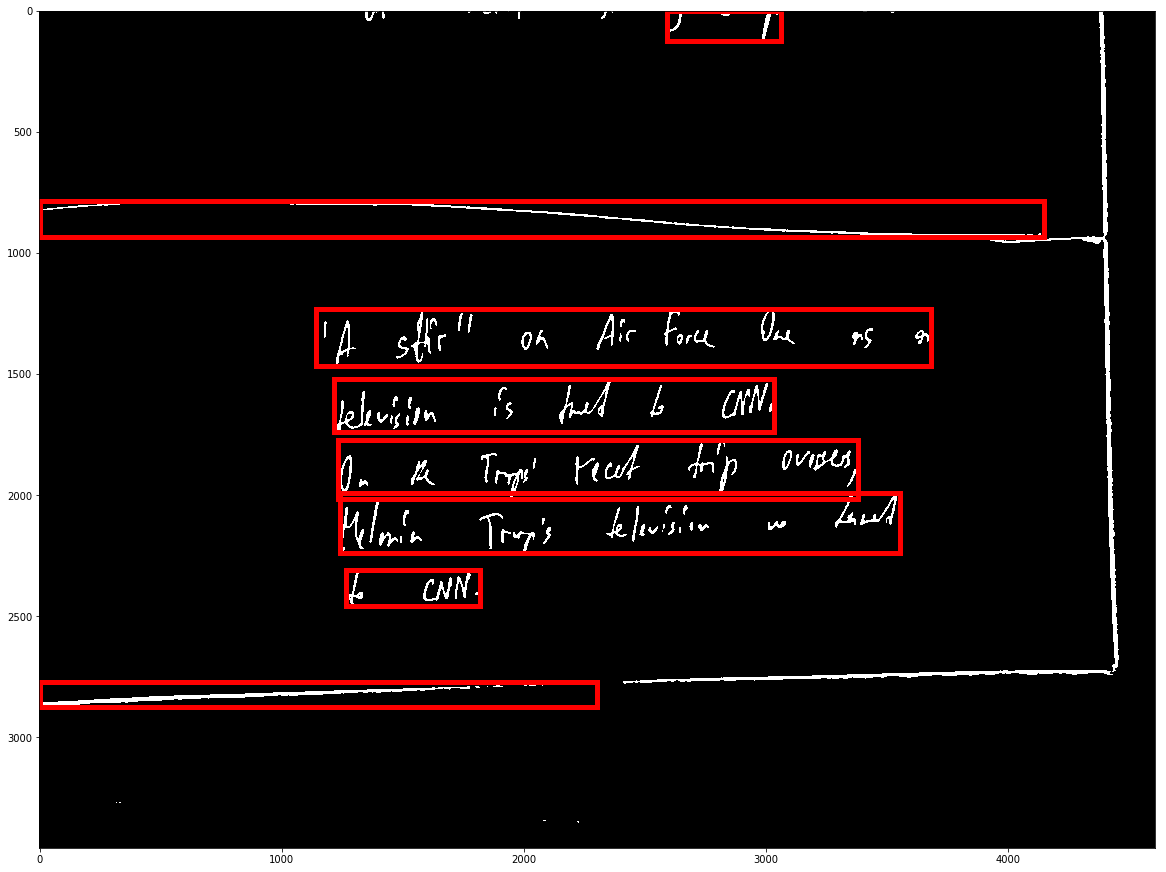

1: ../admin/cursive_ai/camera_images/IMG_20180725_132402.jpg
text_span_along_w, text_span_along_h:  4608 822


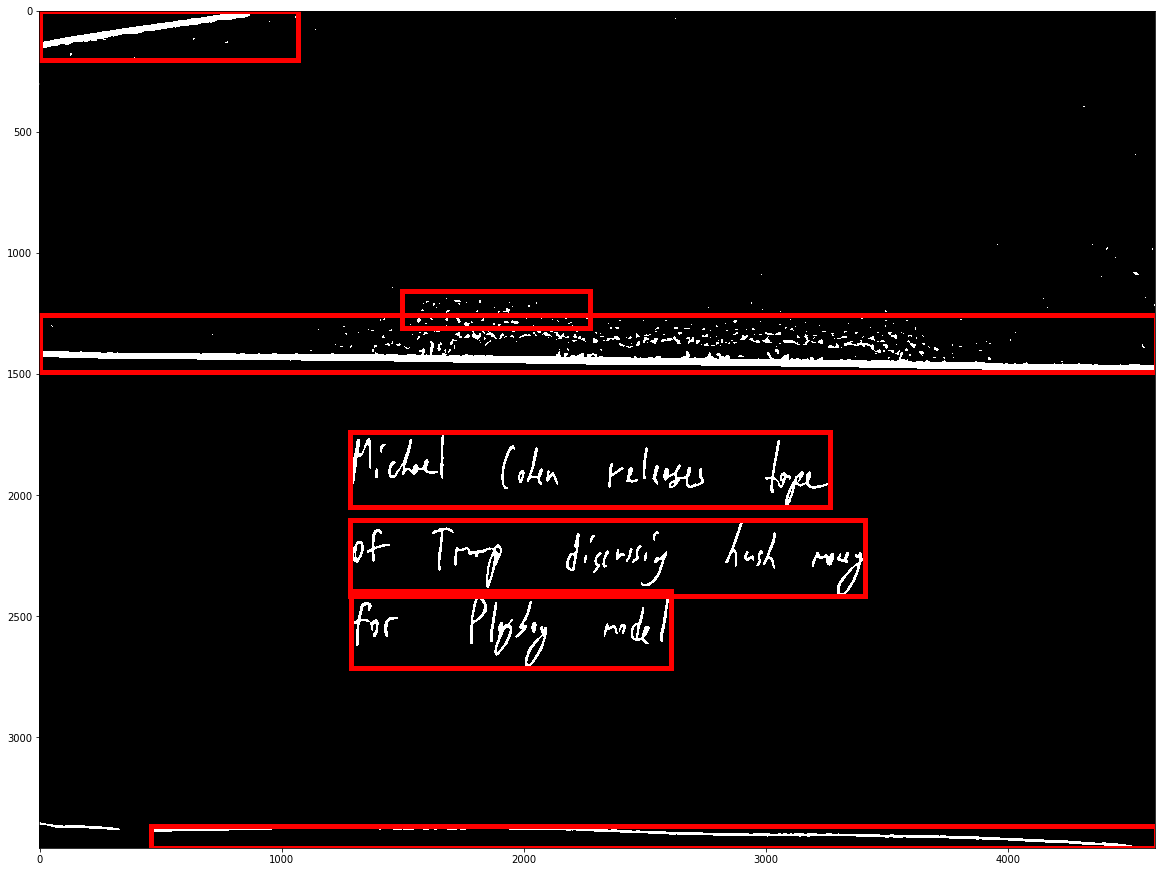

2: ../admin/cursive_ai/camera_images/IMG_20180725_131920.jpg
text_span_along_w, text_span_along_h:  931 4562
image is rotated


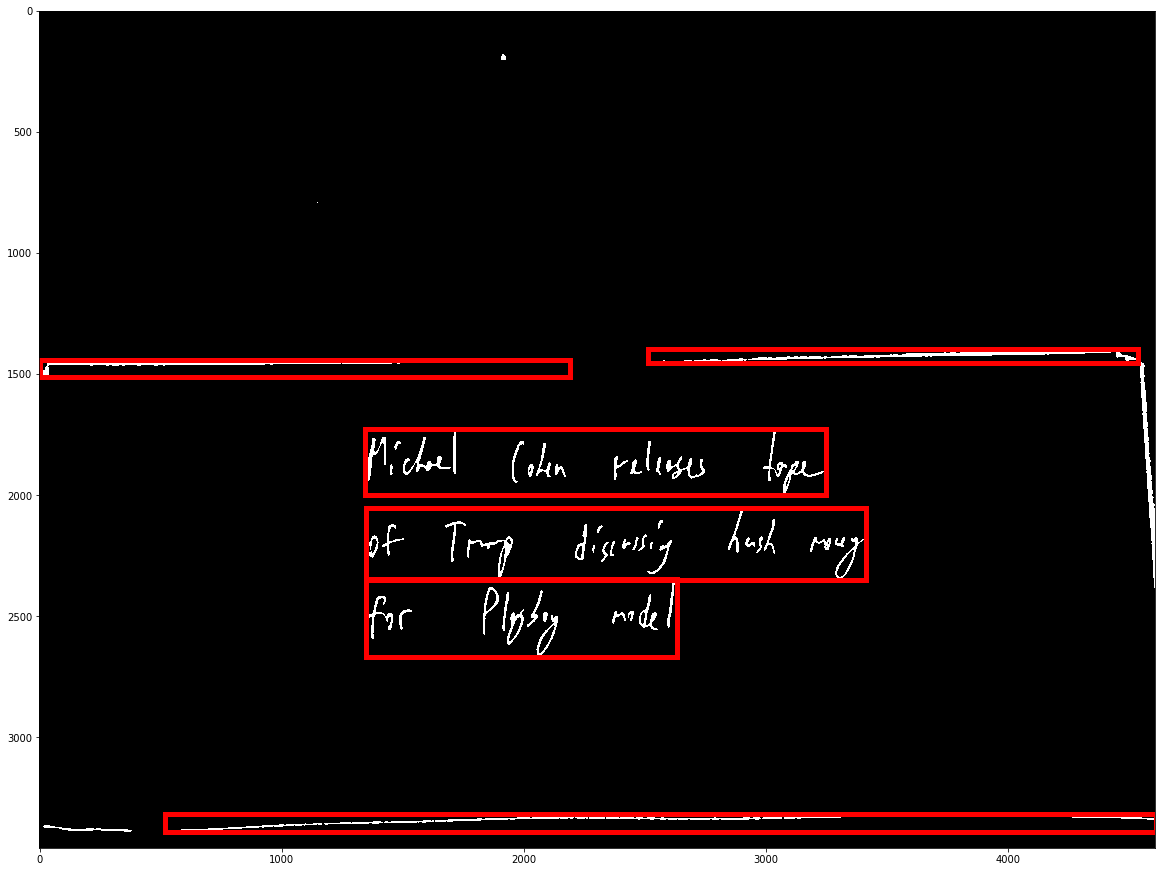

3: ../admin/cursive_ai/camera_images/IMG_6723.jpg
text_span_along_w, text_span_along_h:  2887 871


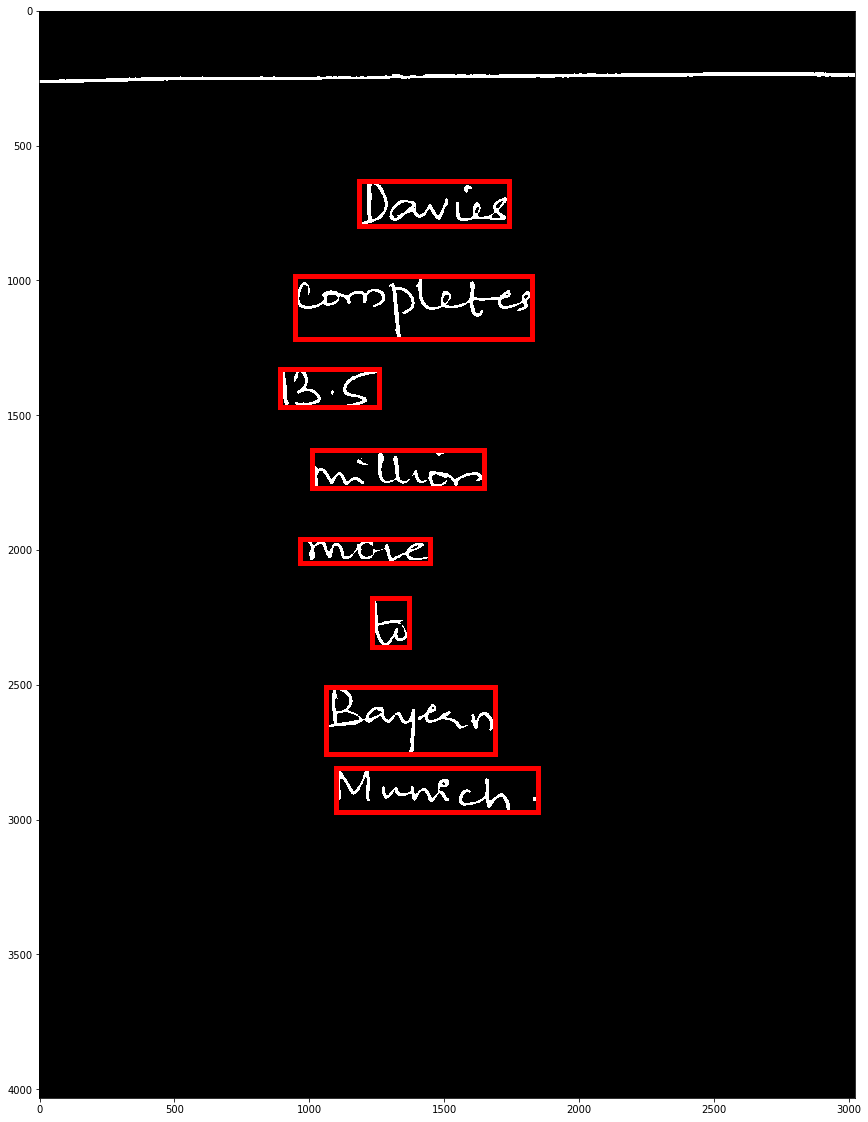

4: ../admin/cursive_ai/camera_images/IMG_6737.jpg
text_span_along_w, text_span_along_h:  1425 3023
image is rotated


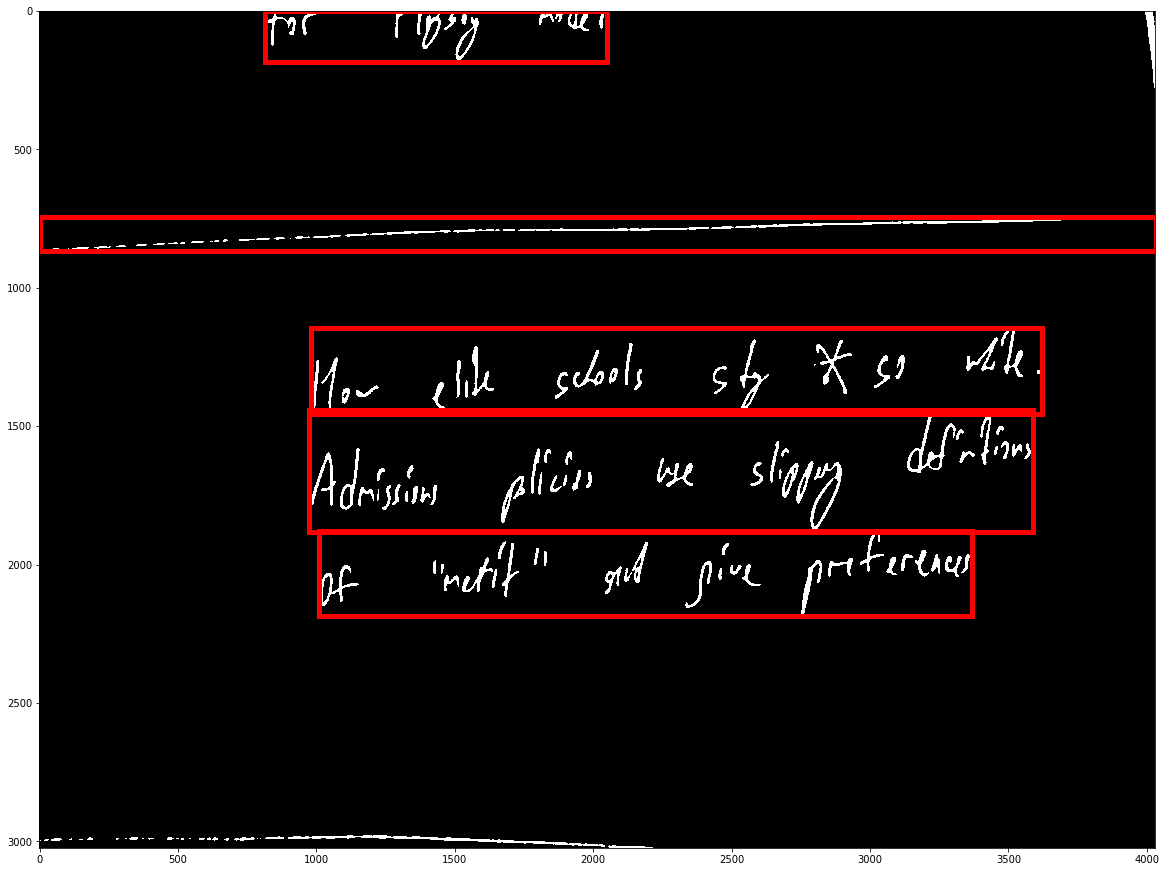

5: ../admin/cursive_ai/camera_images/IMG_6726.jpg
text_span_along_w, text_span_along_h:  1130 481


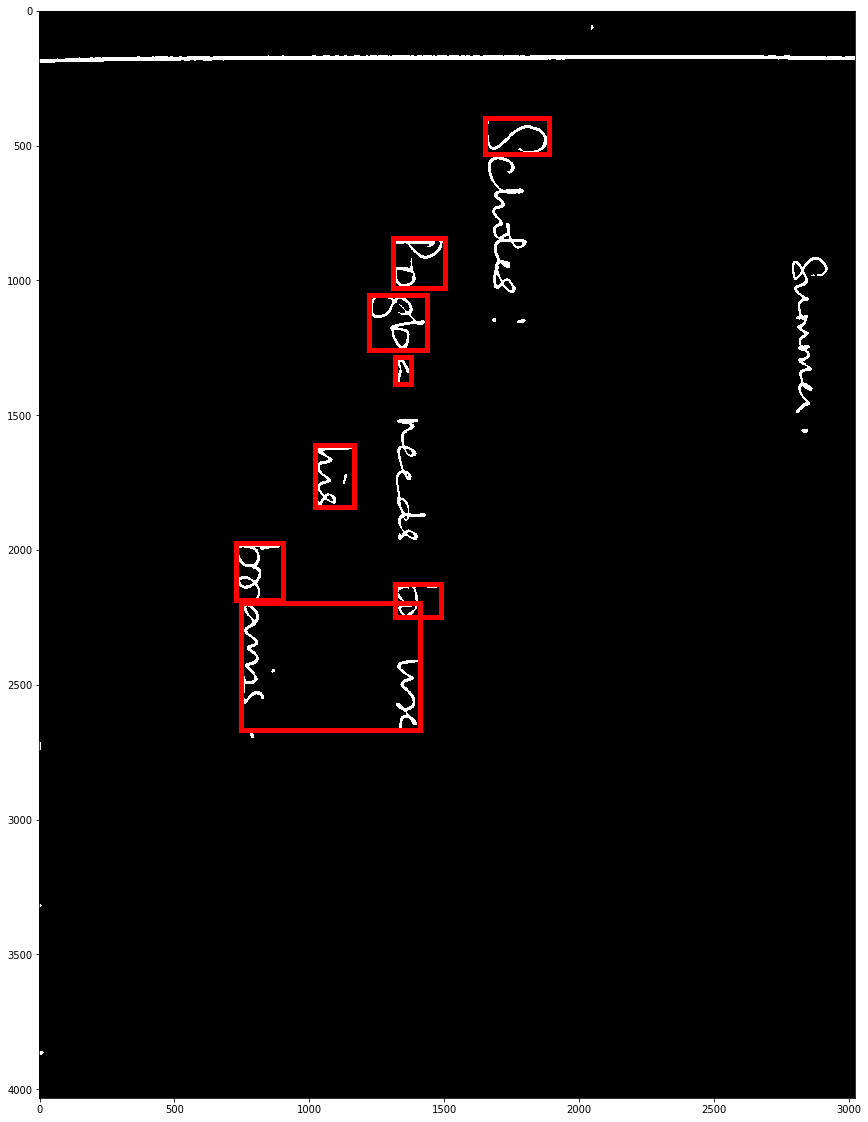

6: ../admin/cursive_ai/camera_images/IMG_20180725_132359.jpg
text_span_along_w, text_span_along_h:  3236 1774


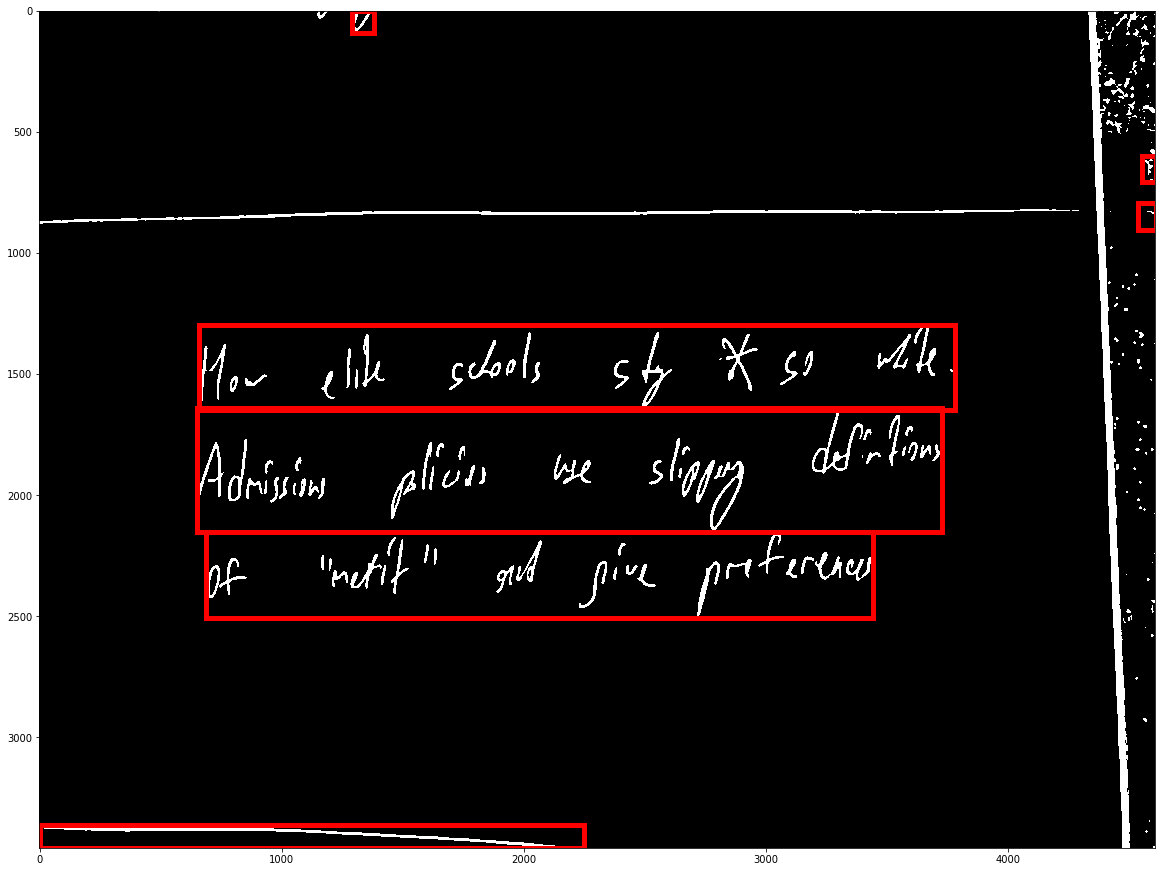

7: ../admin/cursive_ai/camera_images/IMG_6740.jpg
text_span_along_w, text_span_along_h:  3024 2710


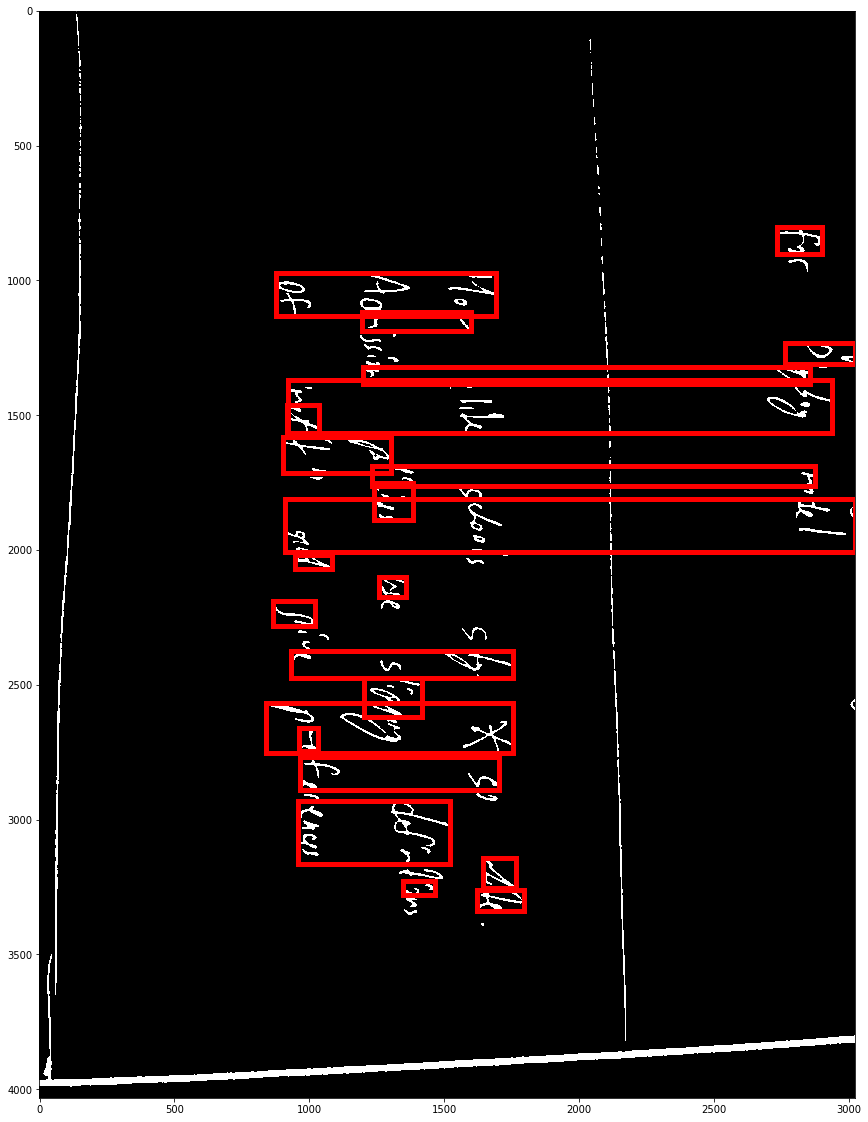

8: ../admin/cursive_ai/camera_images/IMG_20180725_132311.jpg
text_span_along_w, text_span_along_h:  2526 475


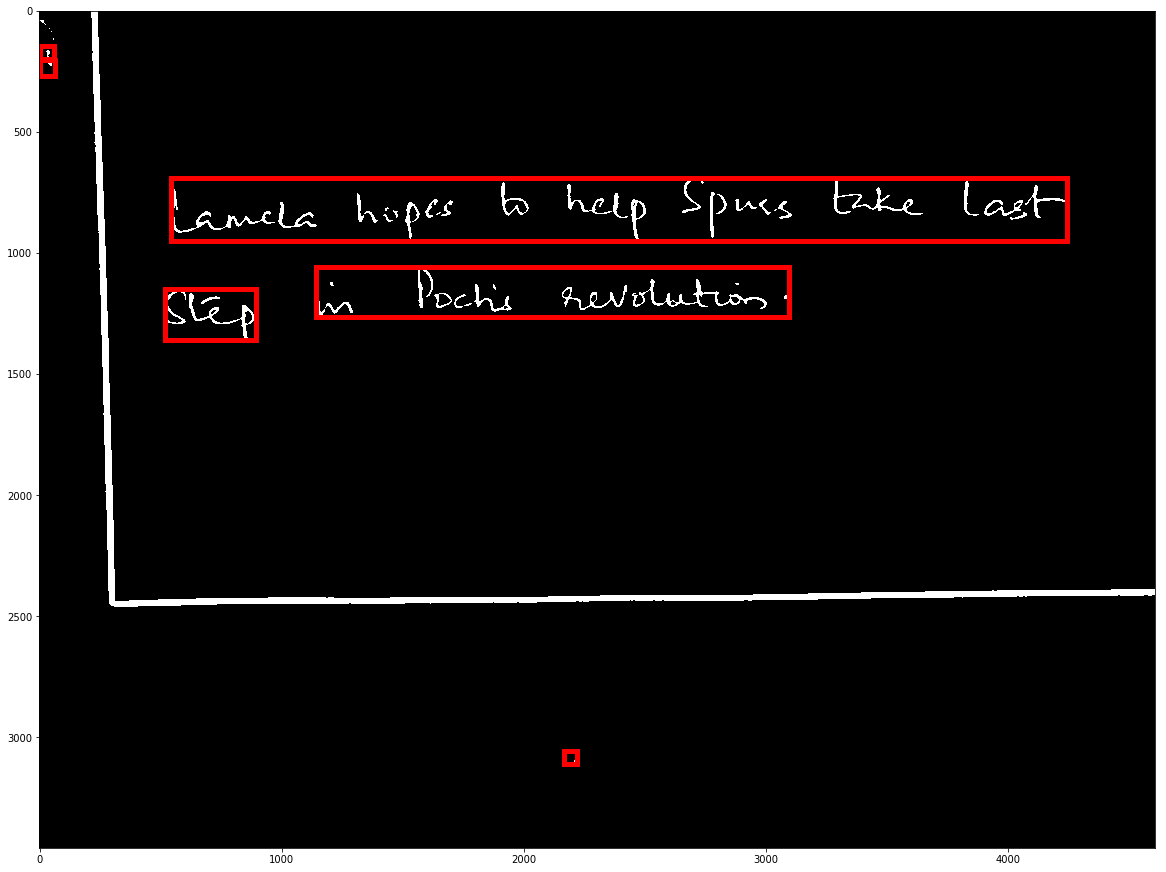

9: ../admin/cursive_ai/camera_images/IMG_6711.jpg
text_span_along_w, text_span_along_h:  3984 1505


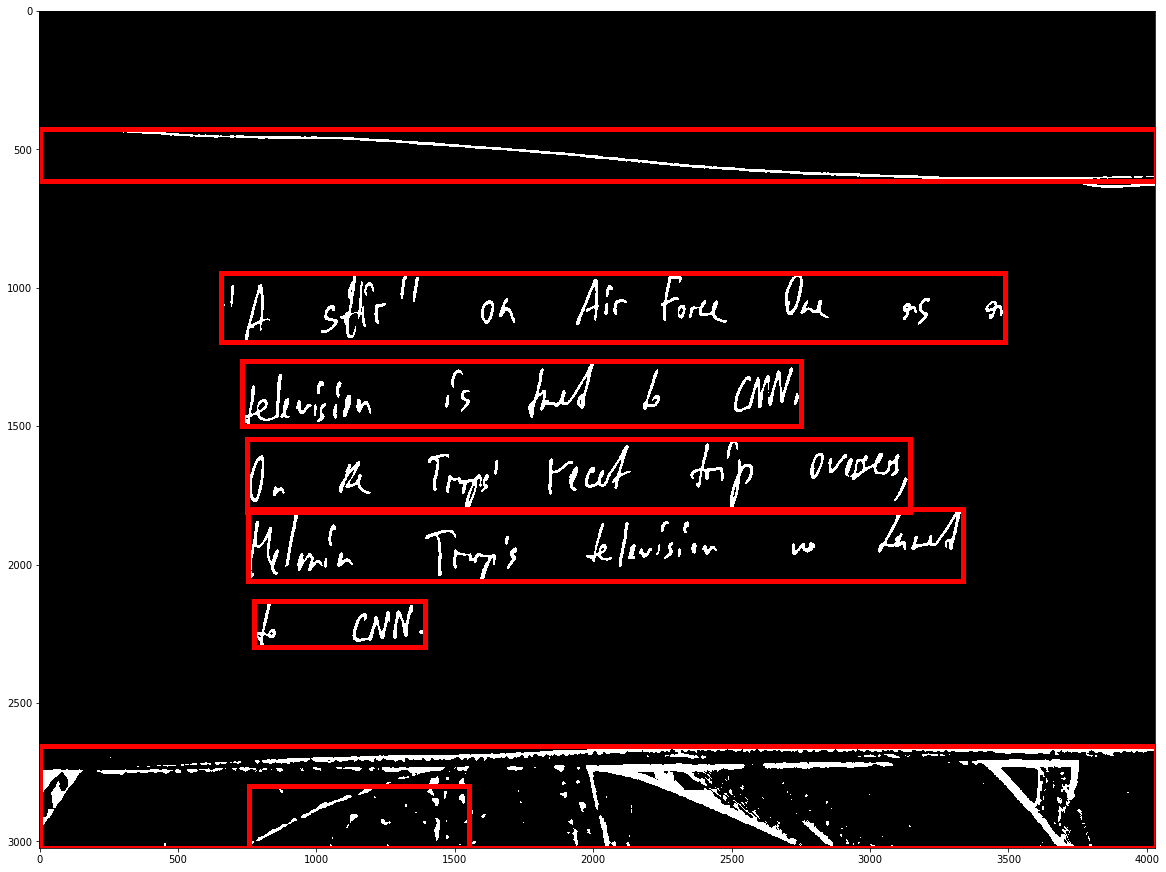

10: ../admin/cursive_ai/camera_images/IMG_6713.jpg
text_span_along_w, text_span_along_h:  3329 1765


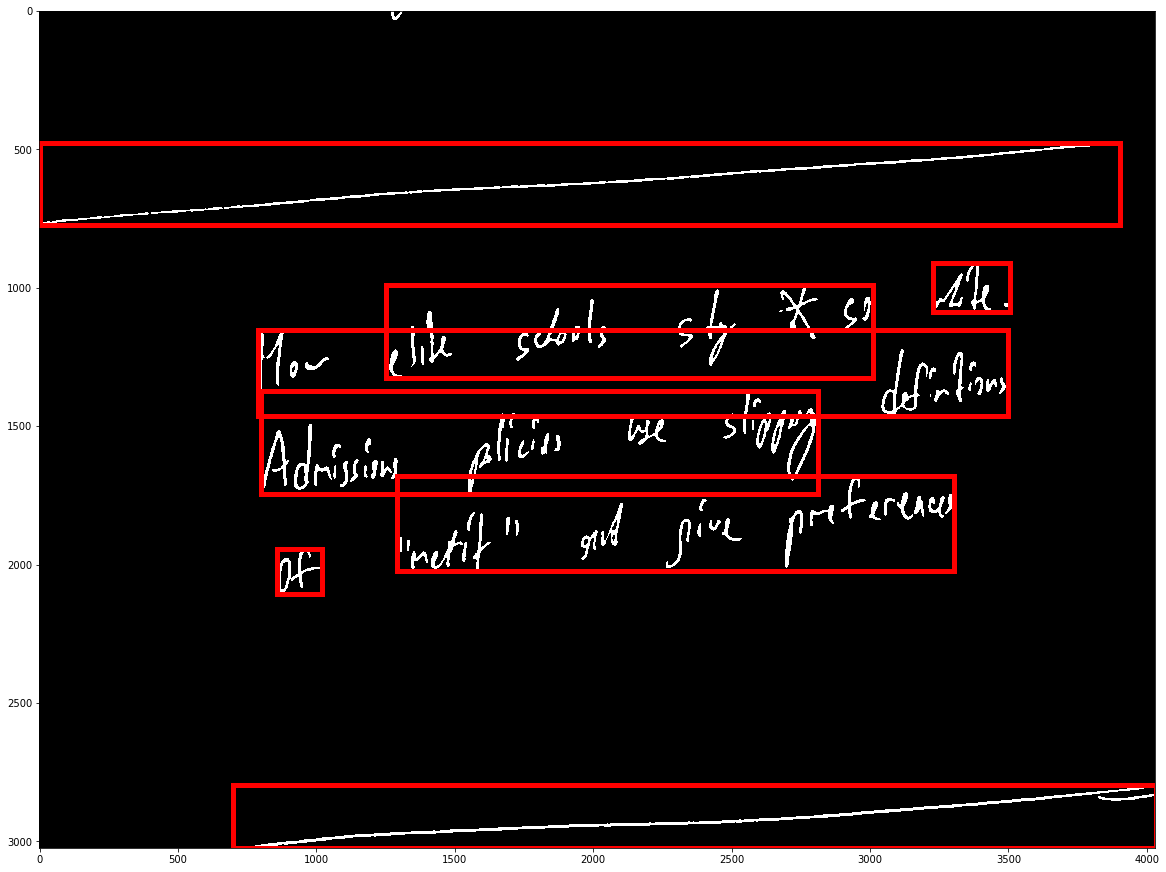

11: ../admin/cursive_ai/camera_images/IMG_6729.jpg
text_span_along_w, text_span_along_h:  827 3134
image is rotated


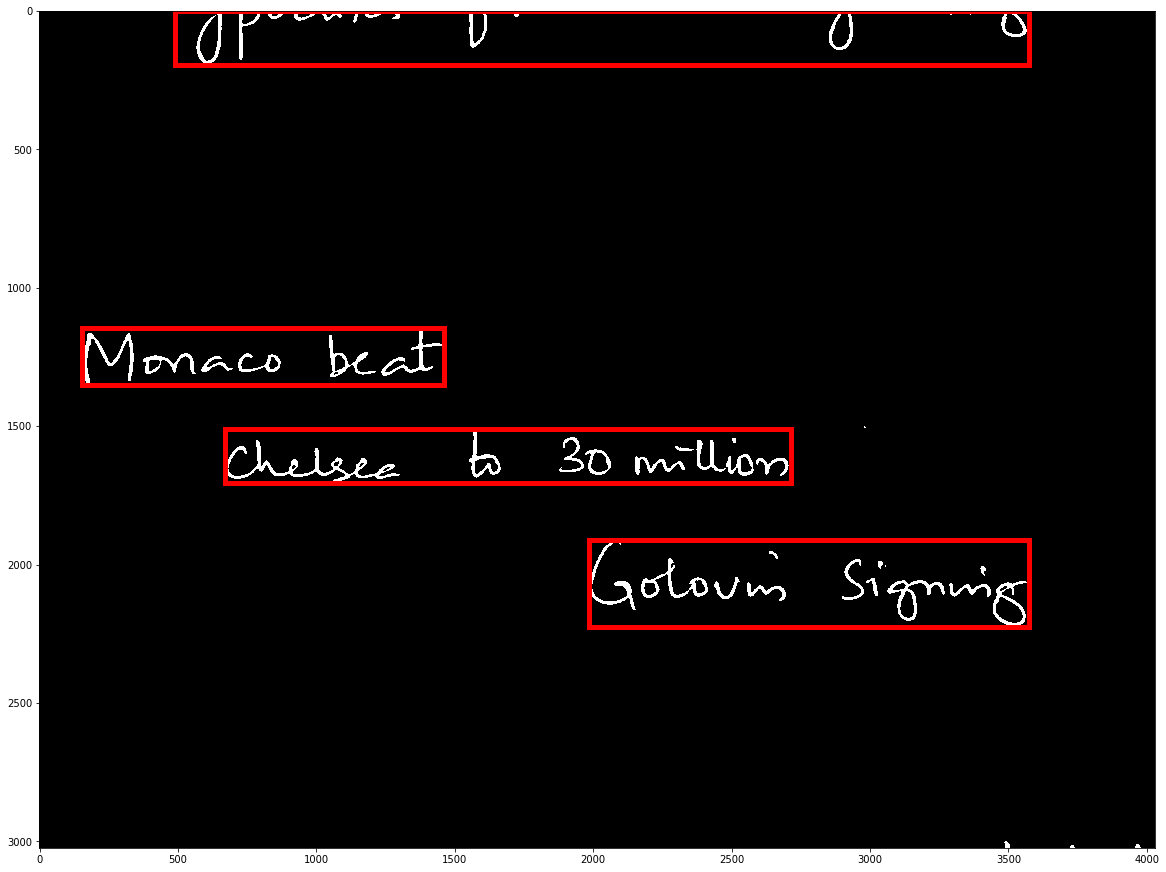

12: ../admin/cursive_ai/camera_images/IMG_6738.jpg
text_span_along_w, text_span_along_h:  1468 3117
image is rotated


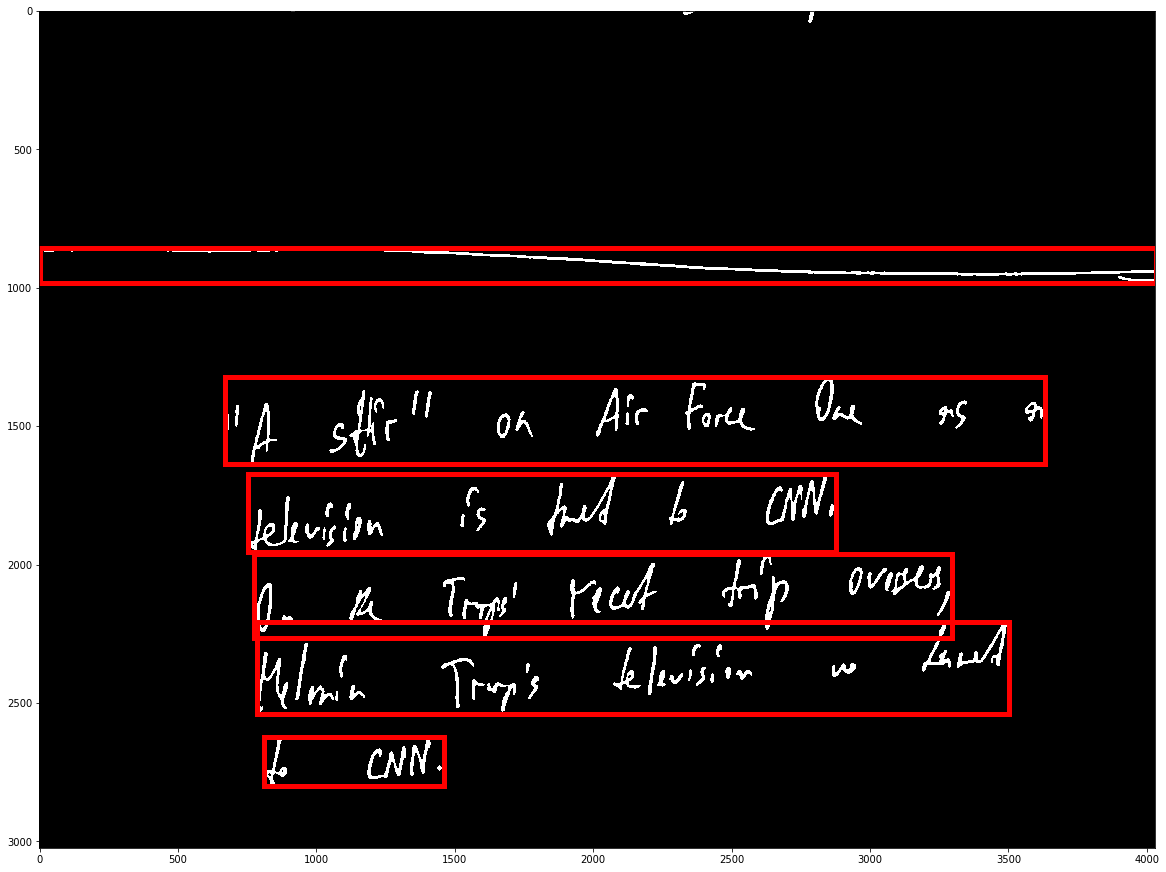

13: ../admin/cursive_ai/camera_images/IMG_6714.jpg
text_span_along_w, text_span_along_h:  4032 857


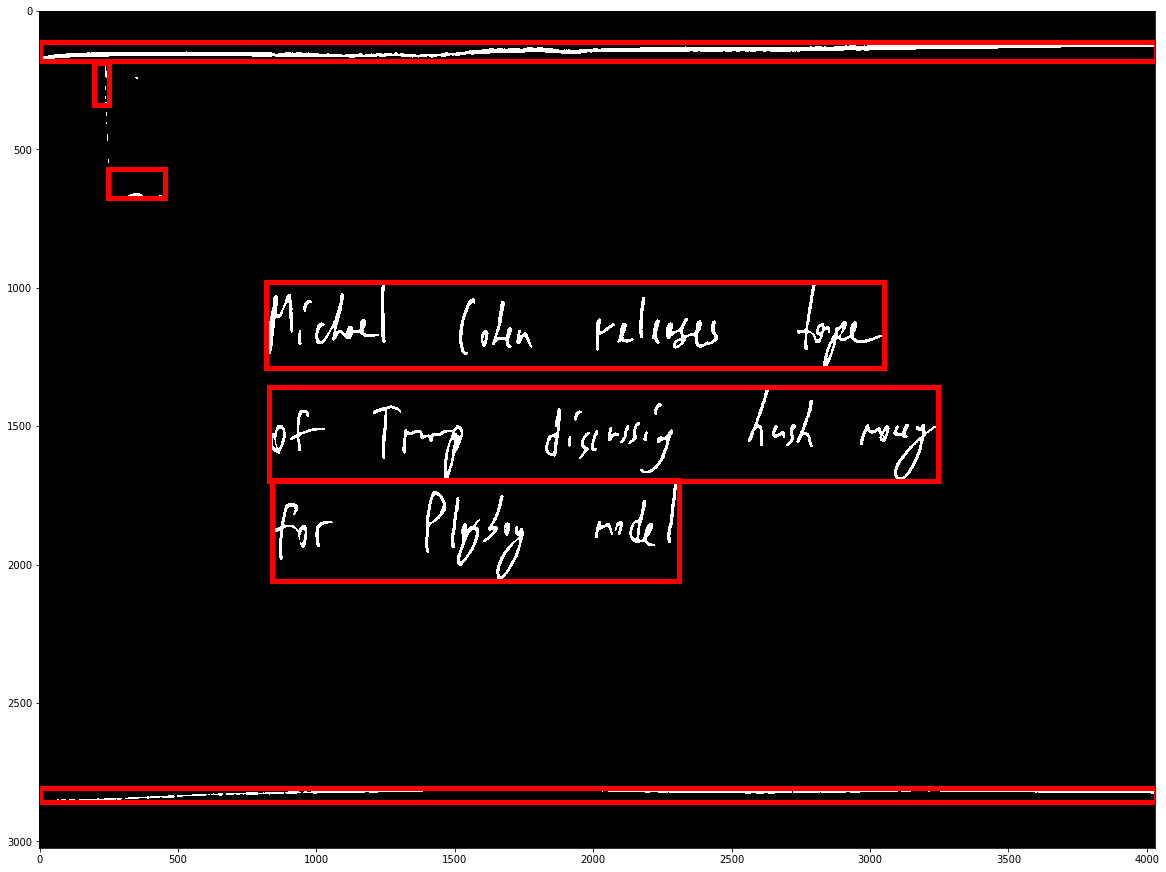

14: ../admin/cursive_ai/camera_images/IMG_6715.jpg
text_span_along_w, text_span_along_h:  1125 1624
image is rotated


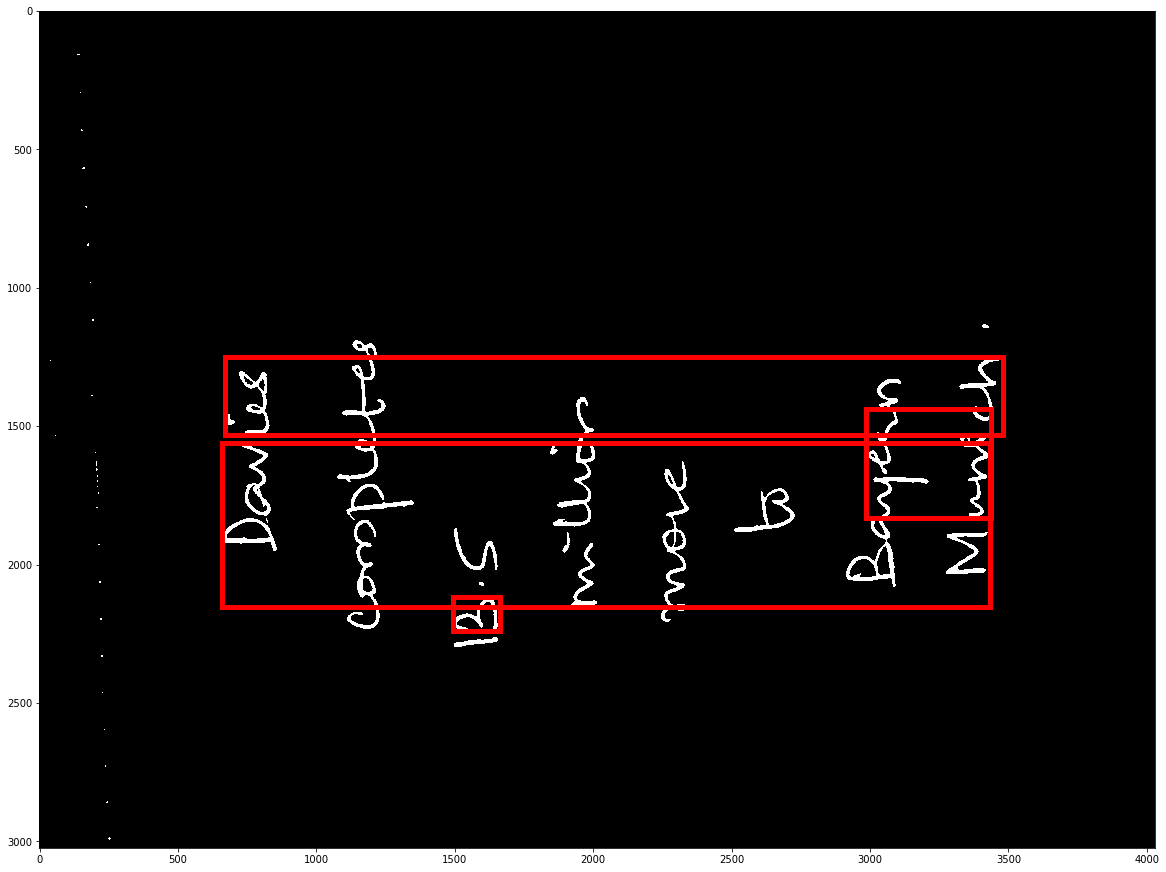

15: ../admin/cursive_ai/camera_images/IMG_6748.jpg
text_span_along_w, text_span_along_h:  3024 110


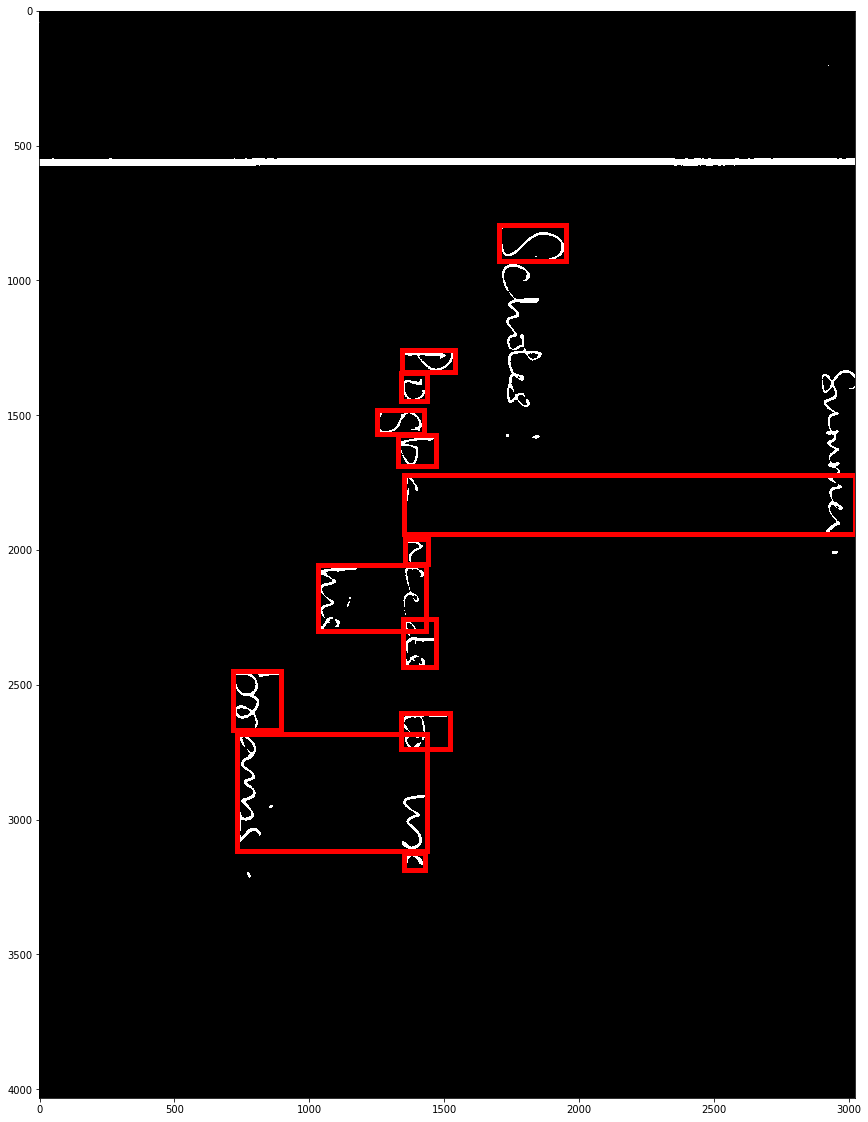

16: ../admin/cursive_ai/camera_images/IMG_20180725_132303.jpg
text_span_along_w, text_span_along_h:  4159 2932


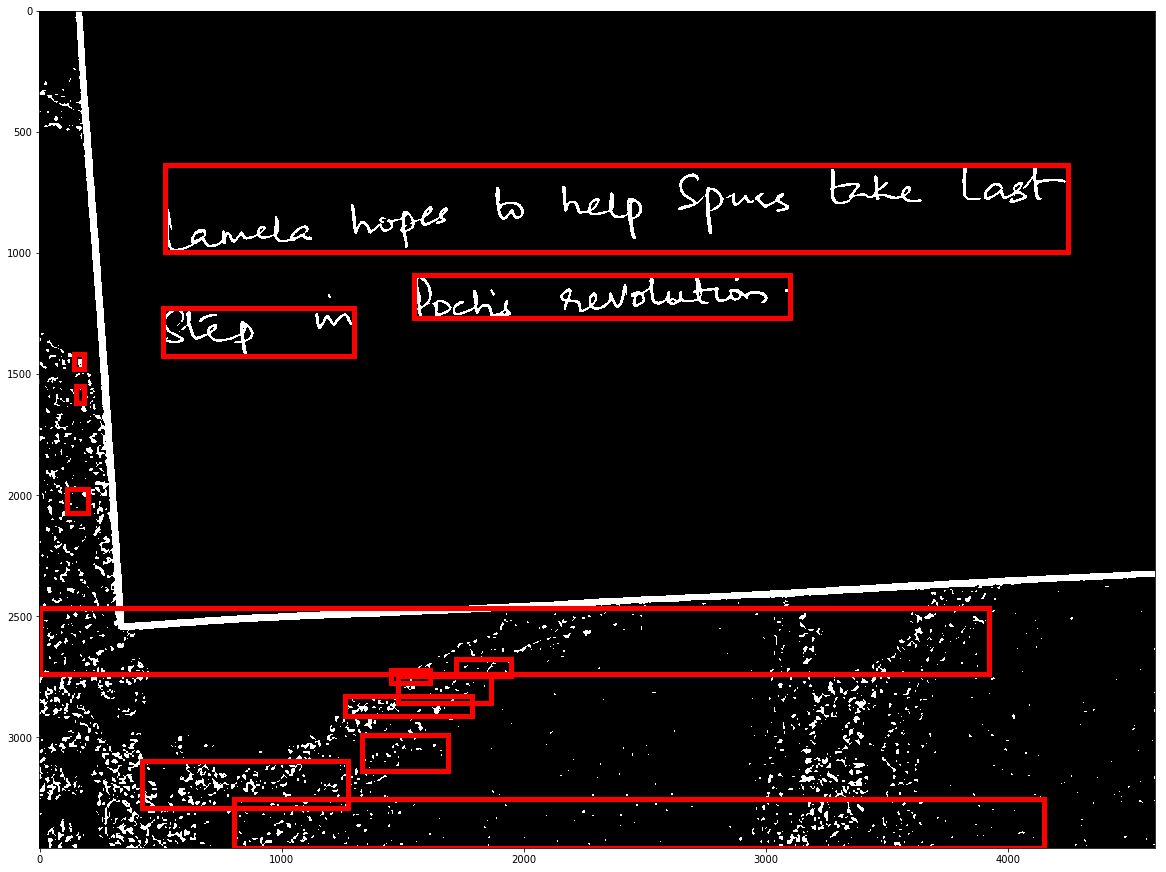

17: ../admin/cursive_ai/camera_images/IMG_20180725_132009.jpg
text_span_along_w, text_span_along_h:  762 1441
image is rotated


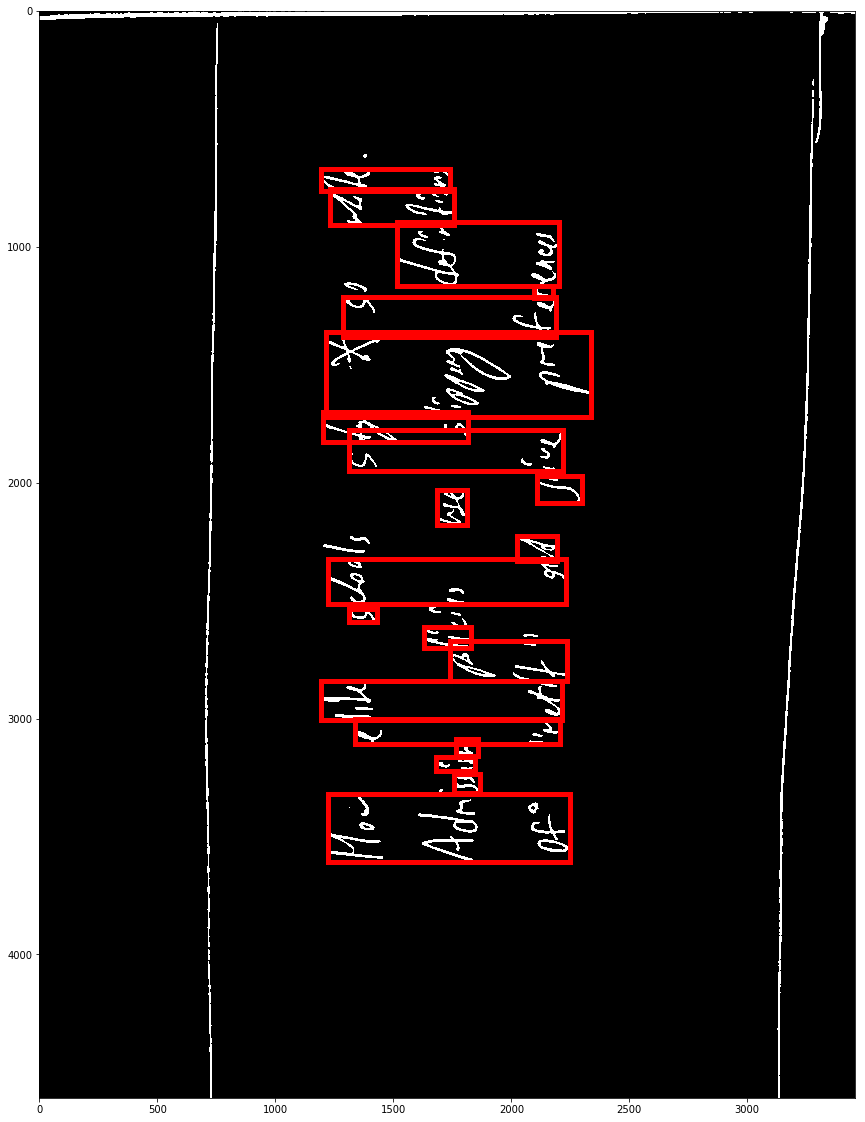

18: ../admin/cursive_ai/camera_images/IMG_6732.jpg
text_span_along_w, text_span_along_h:  3024 299


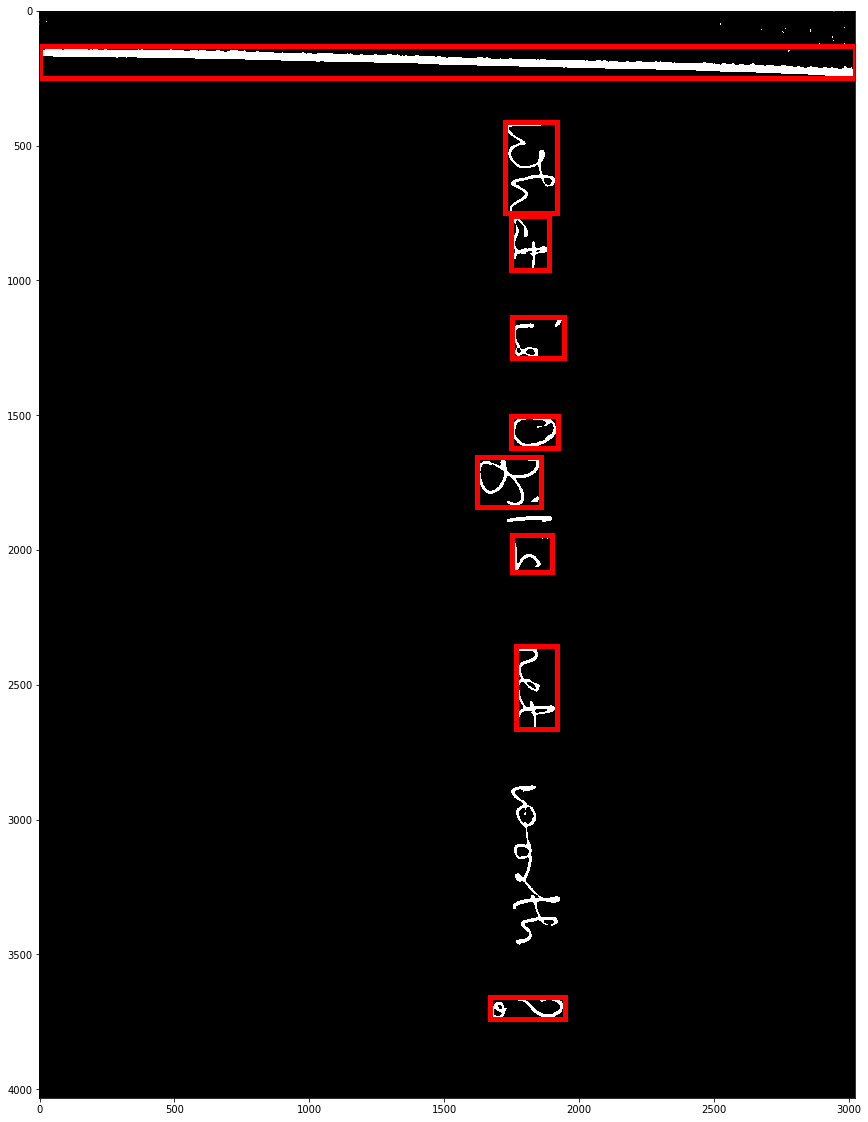

19: ../admin/cursive_ai/camera_images/IMG_6739.jpg
text_span_along_w, text_span_along_h:  1092 4032
image is rotated


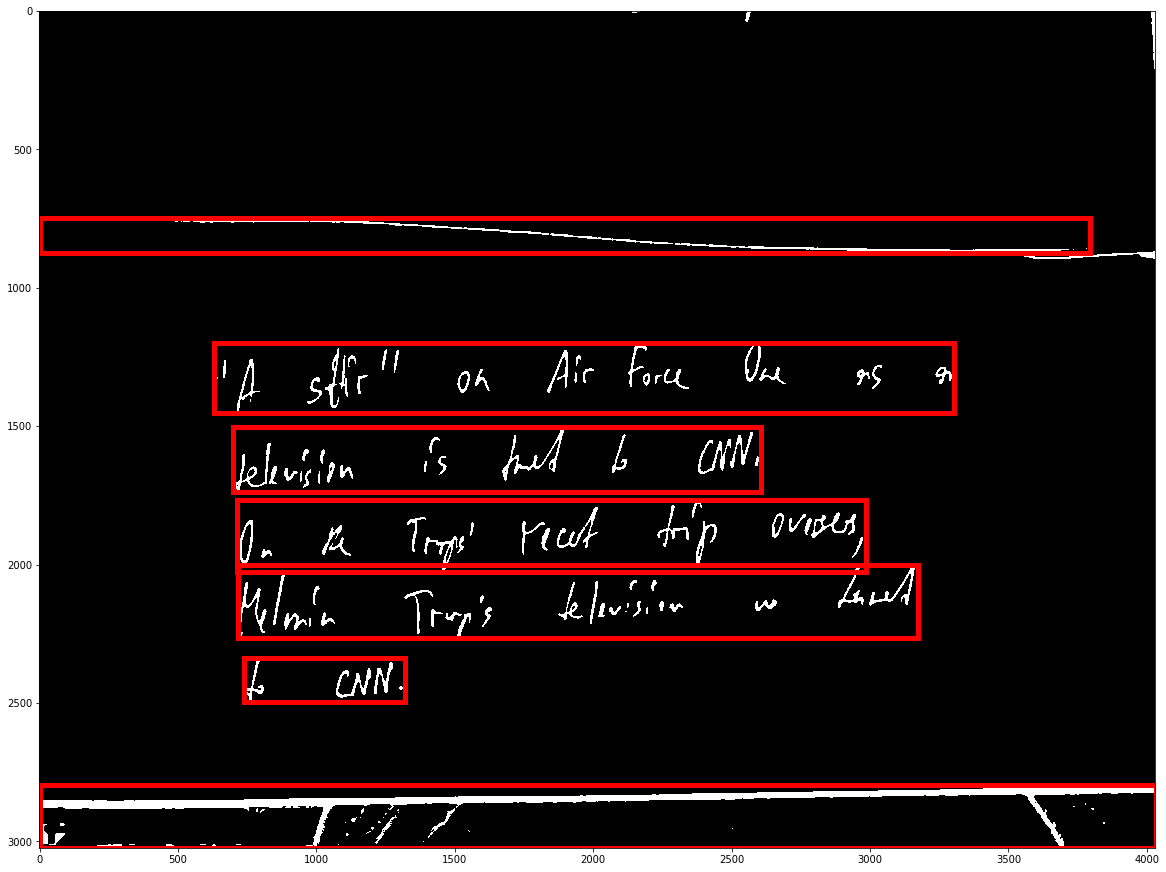

20: ../admin/cursive_ai/camera_images/IMG_20180725_132206.jpg
text_span_along_w, text_span_along_h:  3175 484


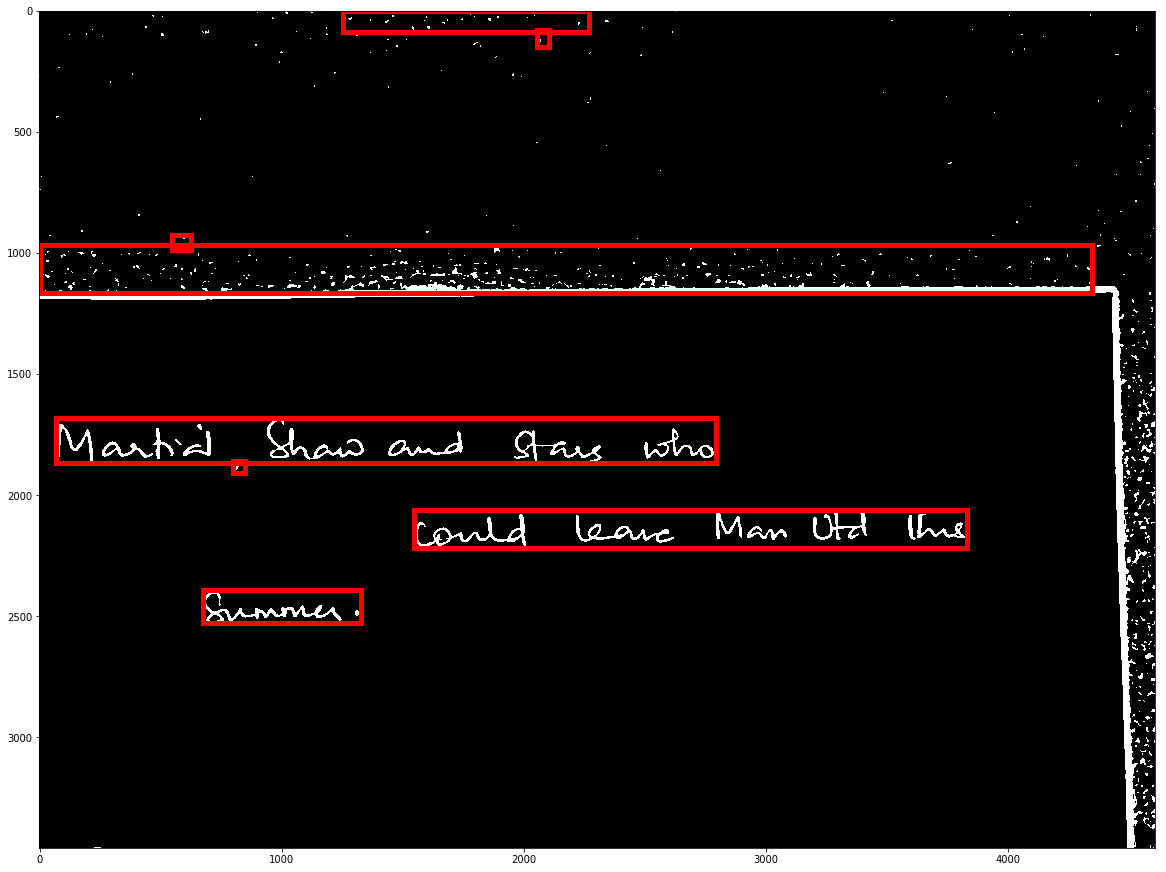

21: ../admin/cursive_ai/camera_images/IMG_20180725_132438.jpg
text_span_along_w, text_span_along_h:  1090 3816
image is rotated


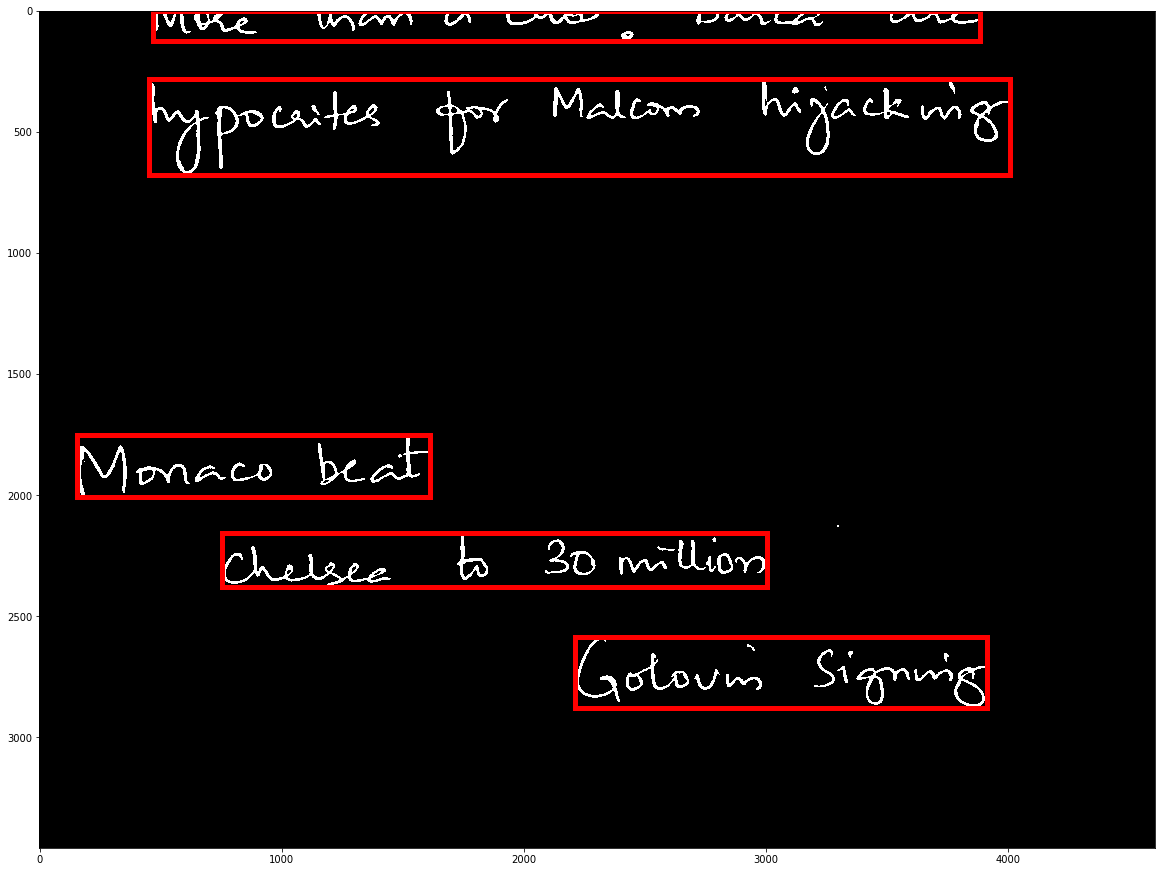

22: ../admin/cursive_ai/camera_images/IMG_6717.jpg
text_span_along_w, text_span_along_h:  743 4032
image is rotated


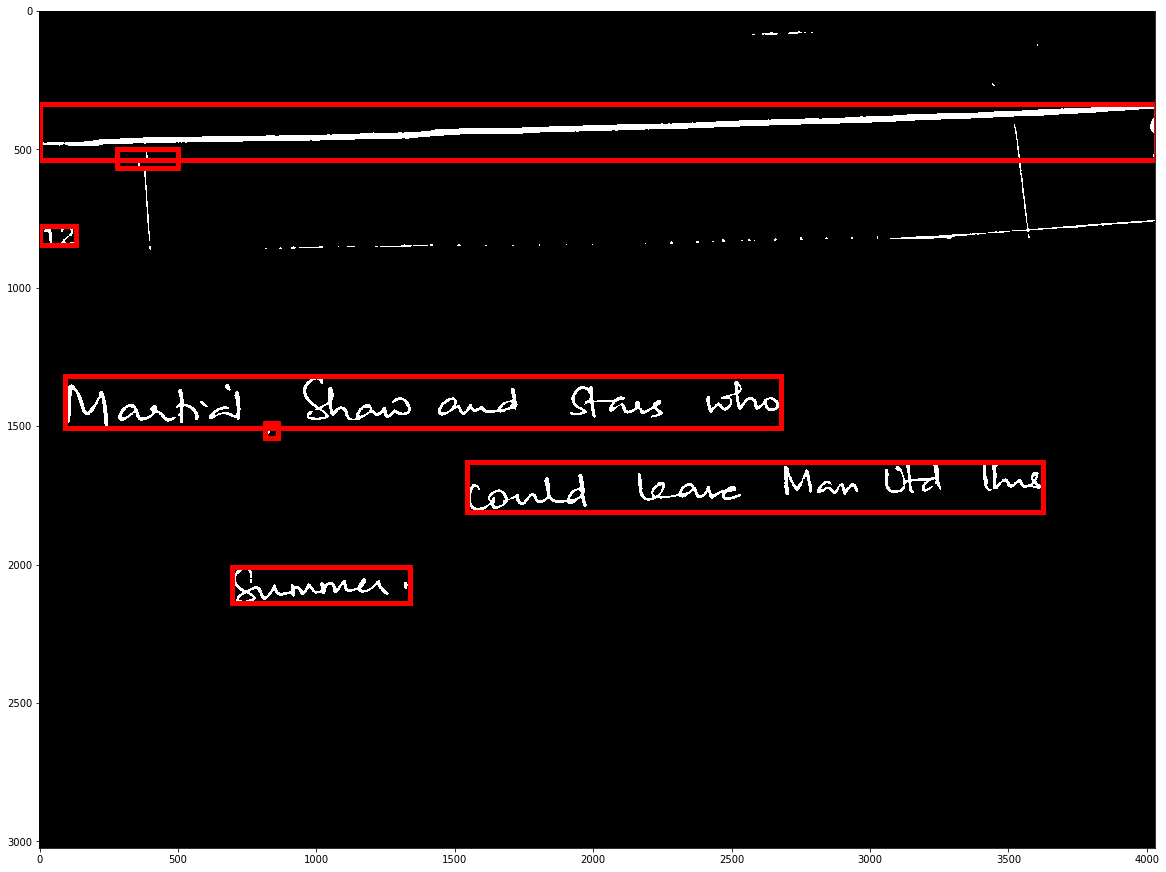

23: ../admin/cursive_ai/camera_images/IMG_6731.jpg
text_span_along_w, text_span_along_h:  1139 975


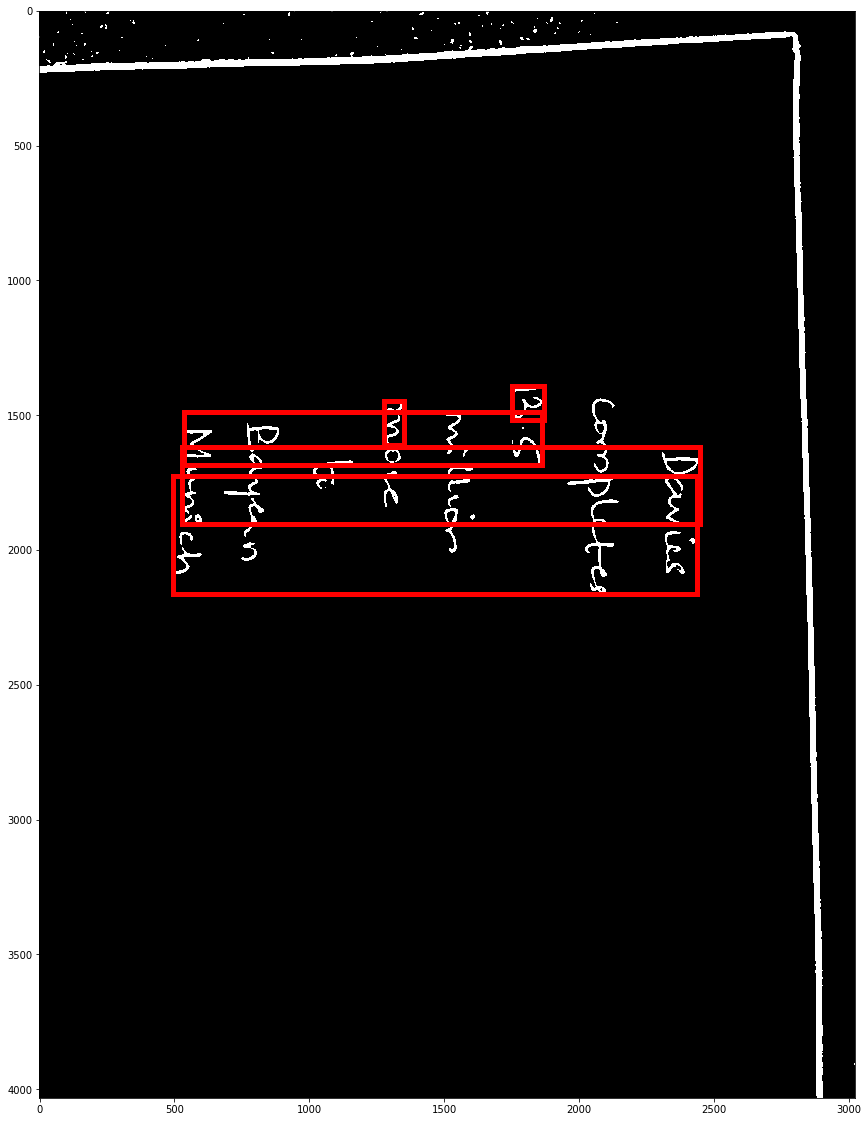

24: ../admin/cursive_ai/camera_images/IMG_6716.jpg
text_span_along_w, text_span_along_h:  338 2721
image is rotated


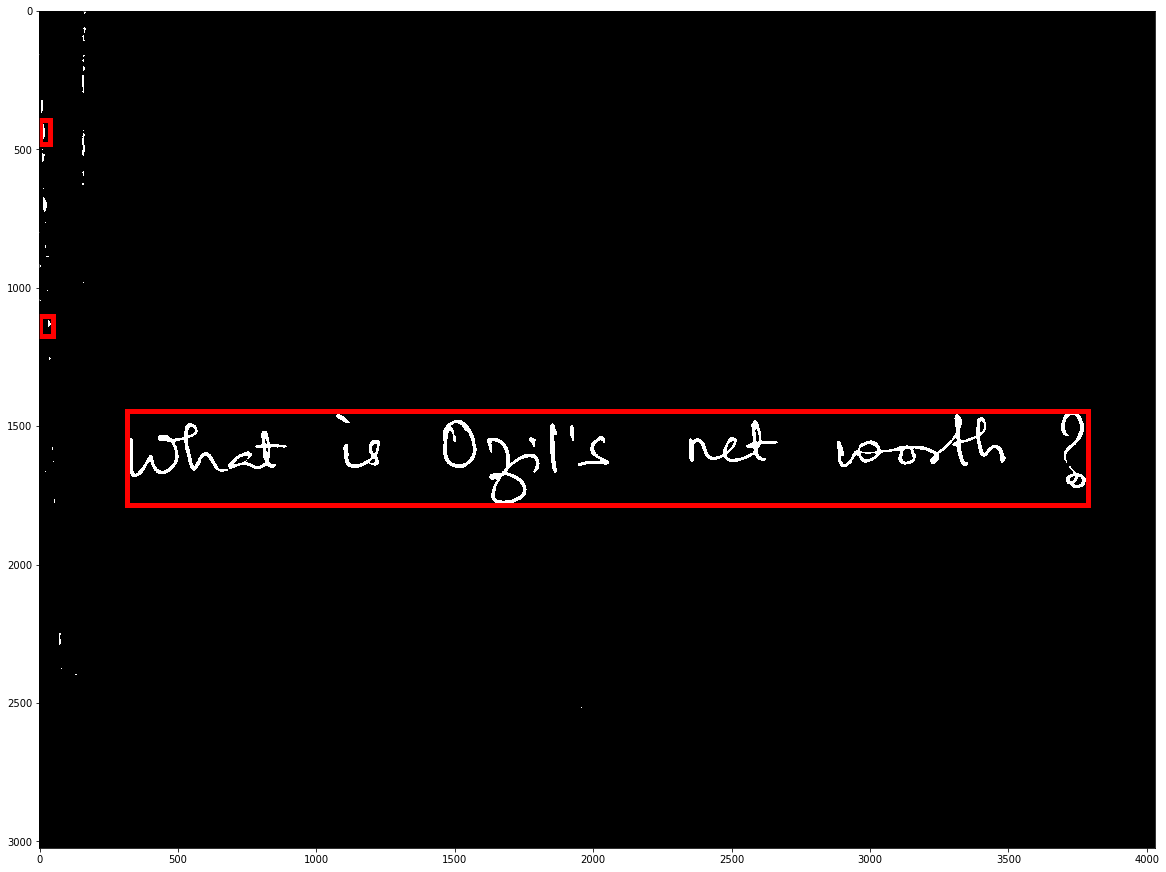

25: ../admin/cursive_ai/camera_images/IMG_20180725_132433.jpg
text_span_along_w, text_span_along_h:  556 2695
image is rotated


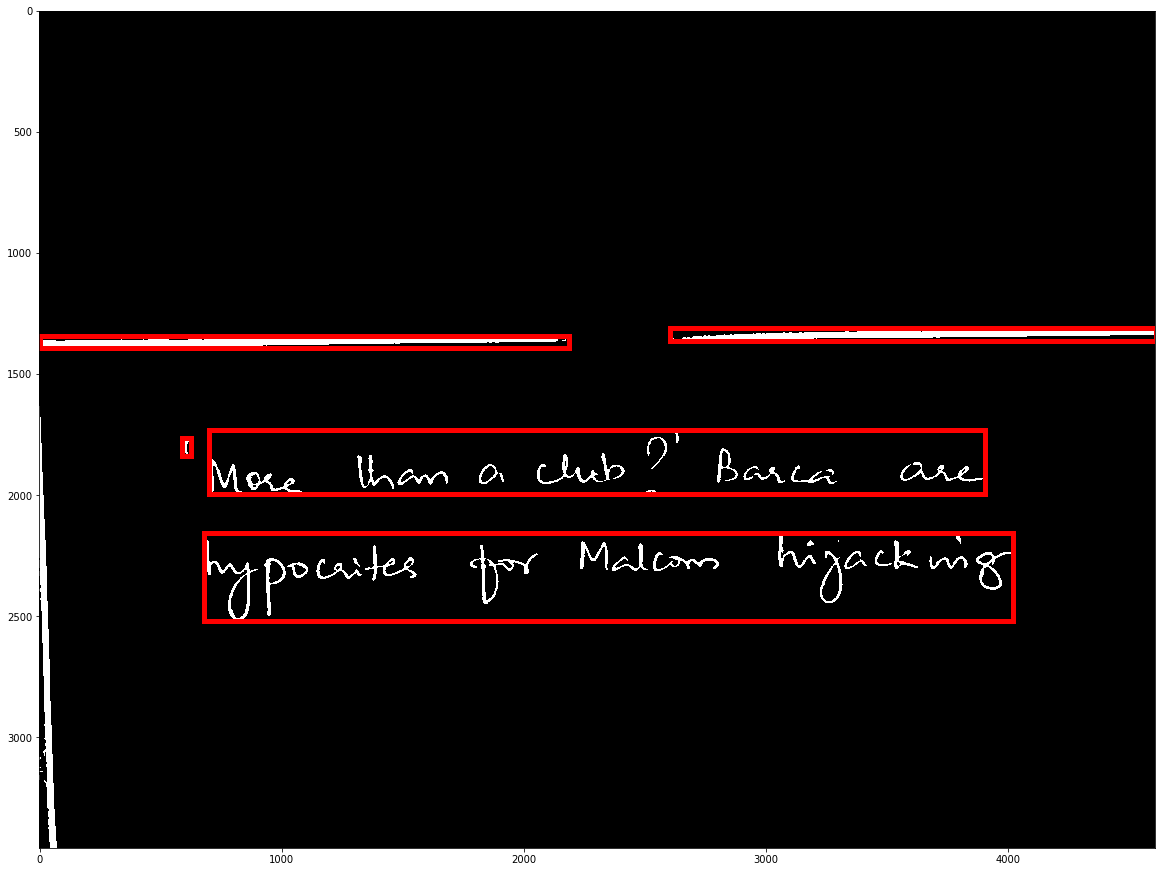

26: ../admin/cursive_ai/camera_images/IMG_6724.jpg
text_span_along_w, text_span_along_h:  314 733
image is rotated


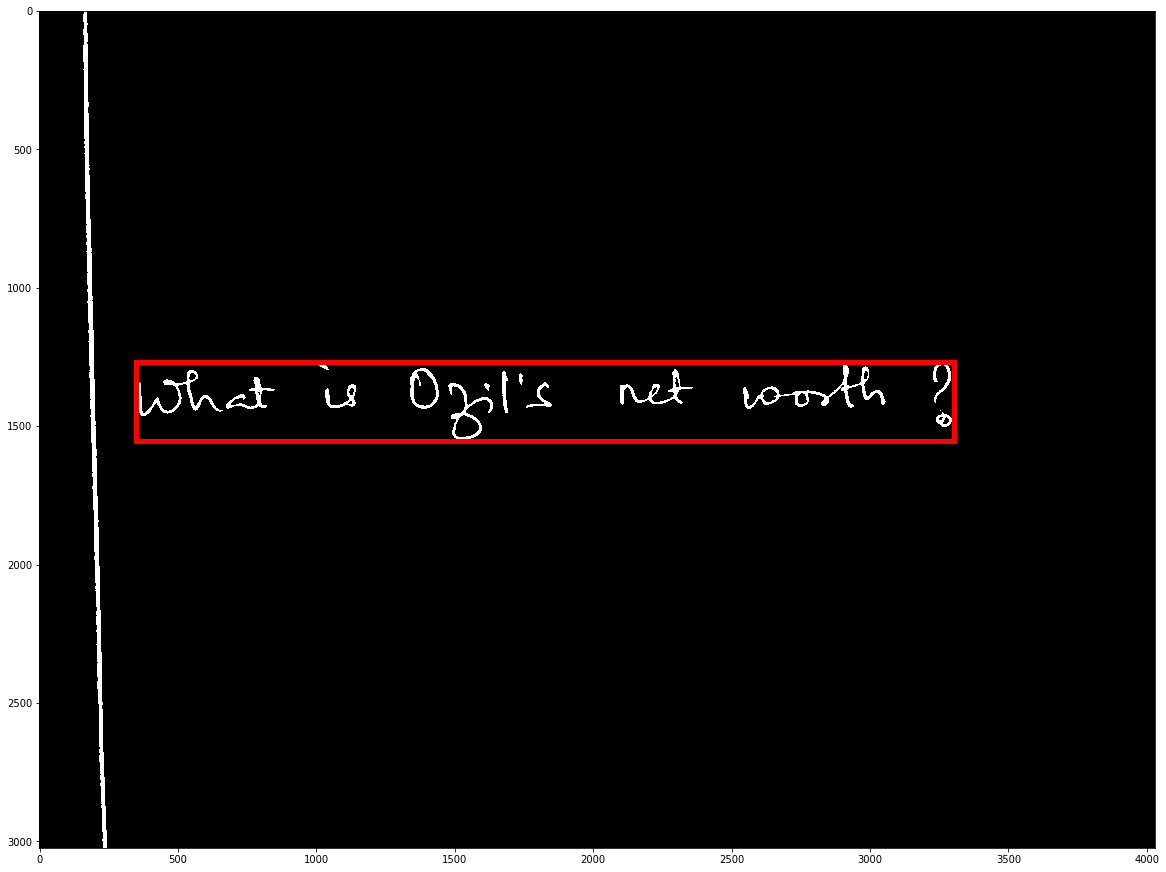

27: ../admin/cursive_ai/camera_images/IMG_6712.jpg
text_span_along_w, text_span_along_h:  4032 1519


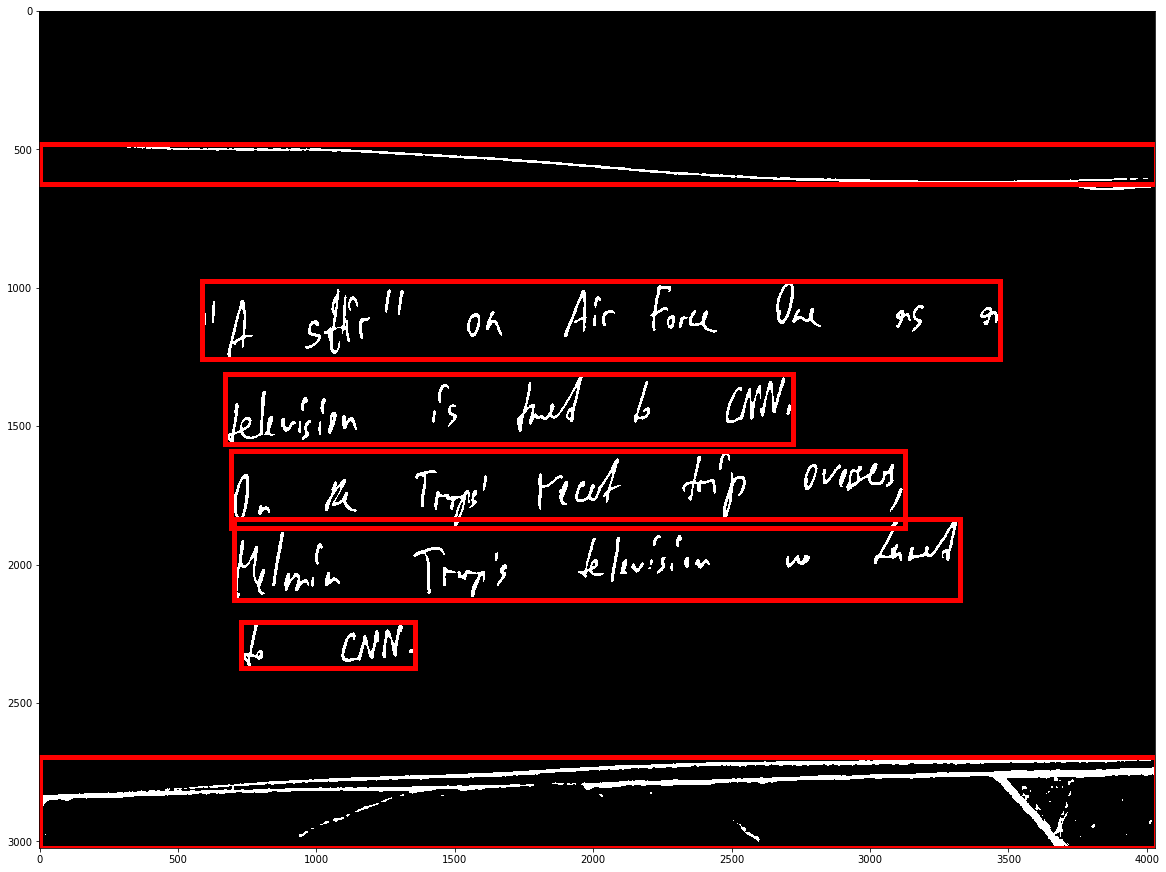

28: ../admin/cursive_ai/camera_images/IMG_6710.jpg
text_span_along_w, text_span_along_h:  3290 1313


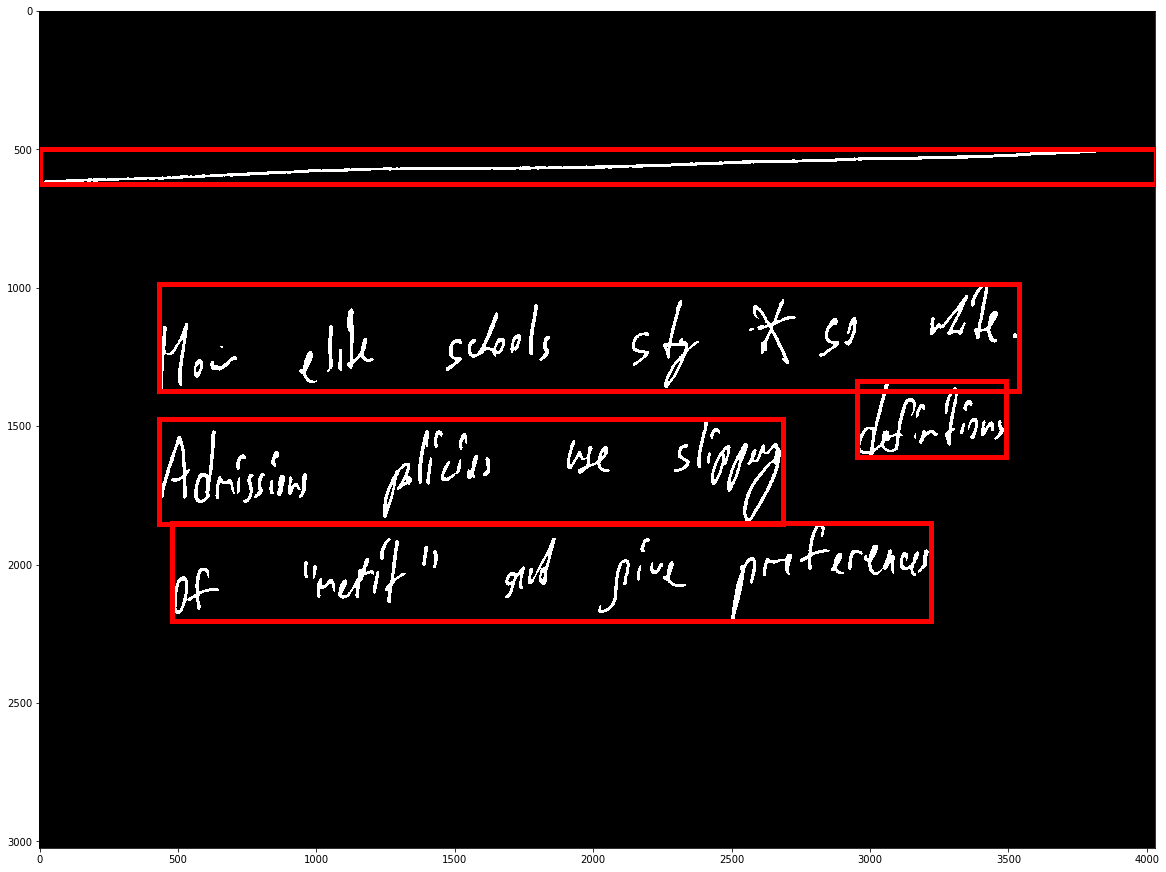

29: ../admin/cursive_ai/camera_images/IMG_20180725_132343.jpg
text_span_along_w, text_span_along_h:  4233 1679


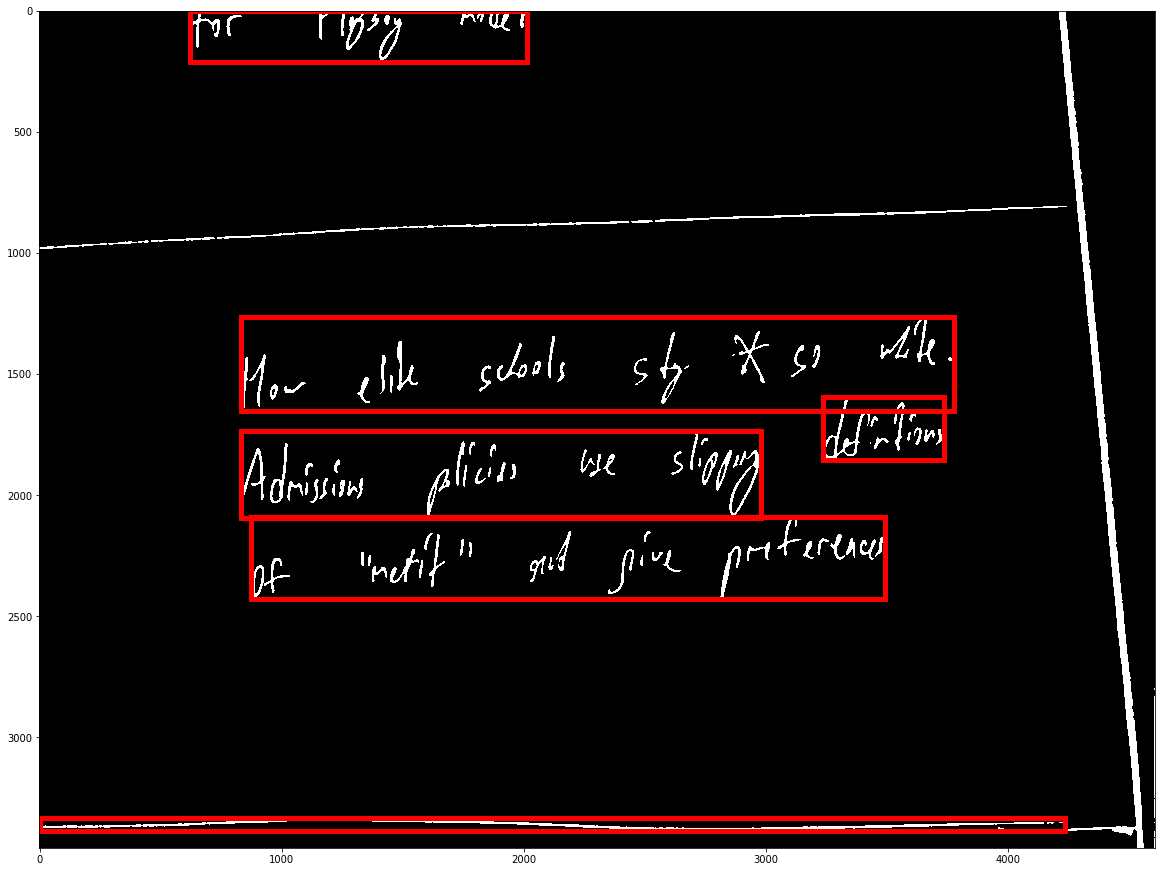

30: ../admin/cursive_ai/camera_images/IMG_6744.jpg
text_span_along_w, text_span_along_h:  1050 1583
image is rotated


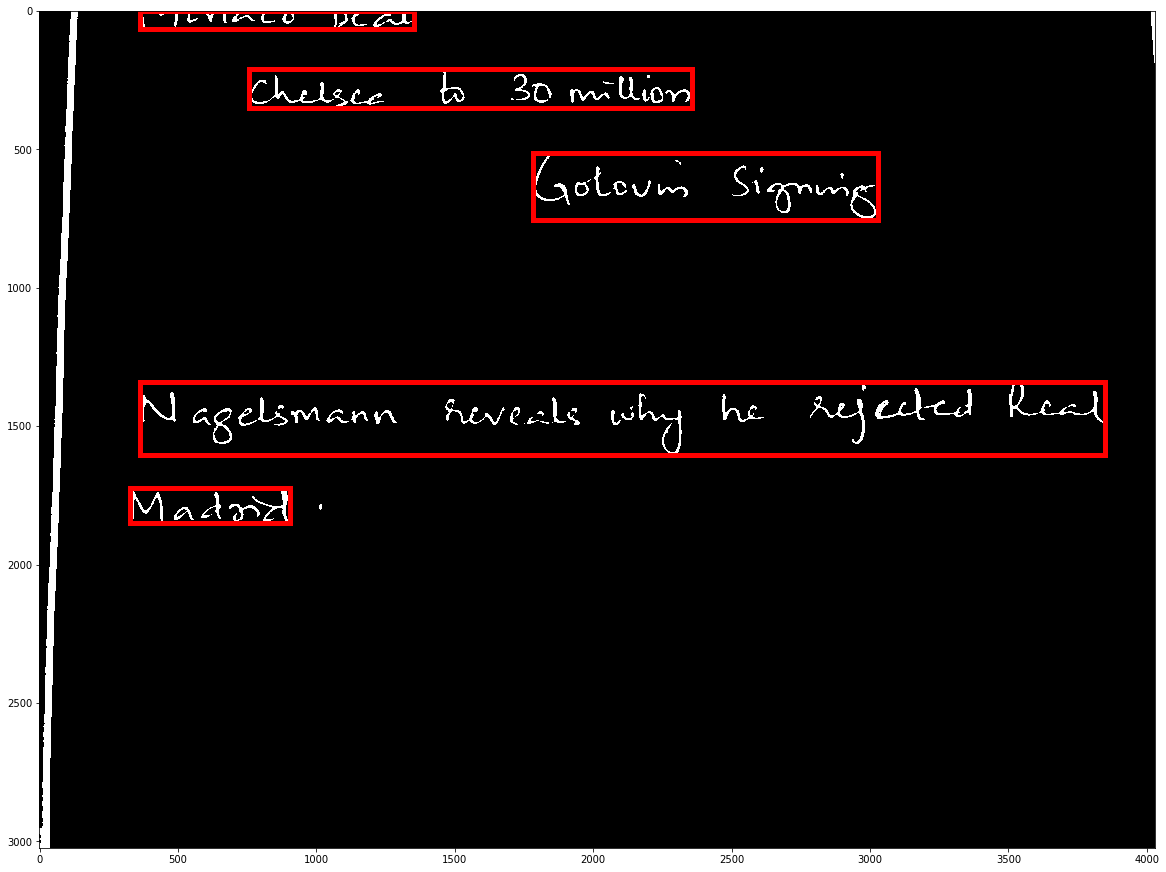

31: ../admin/cursive_ai/camera_images/IMG_20180725_132414.jpg
text_span_along_w, text_span_along_h:  1746 313


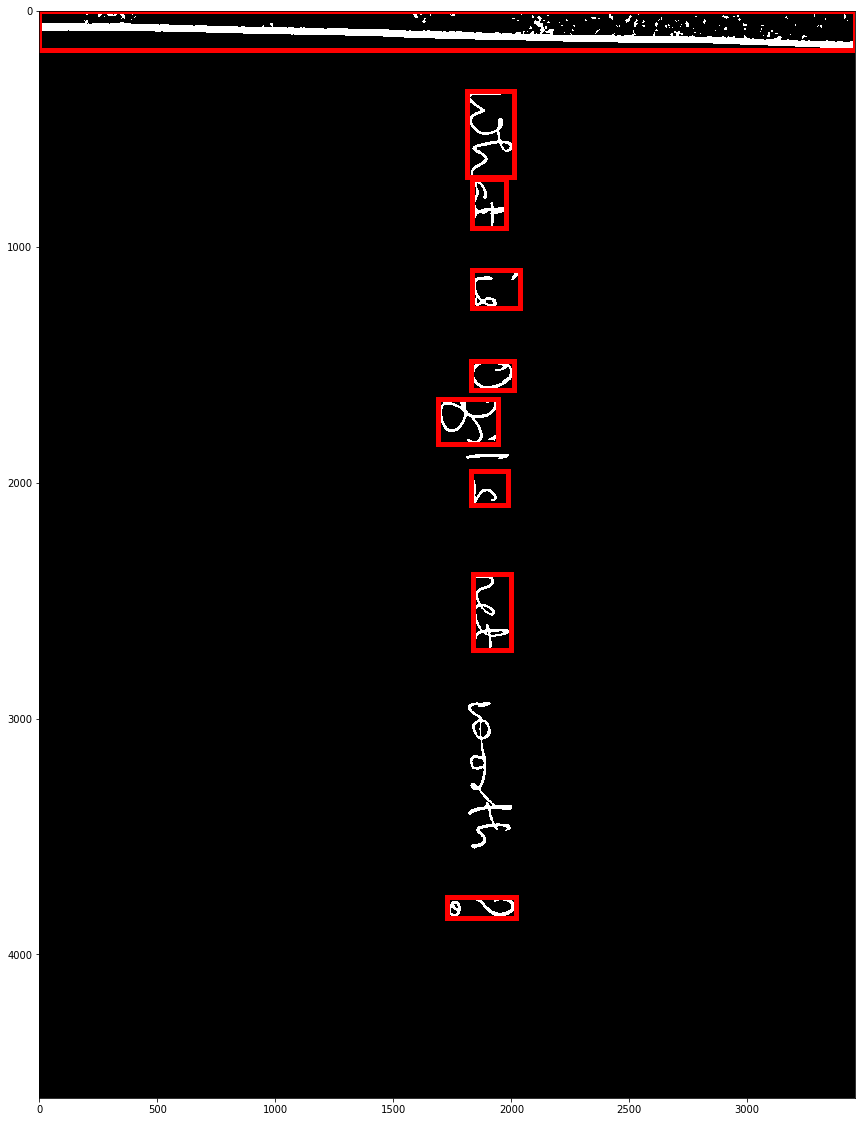

32: ../admin/cursive_ai/camera_images/IMG_20180725_132017.jpg
text_span_along_w, text_span_along_h:  2832 1295


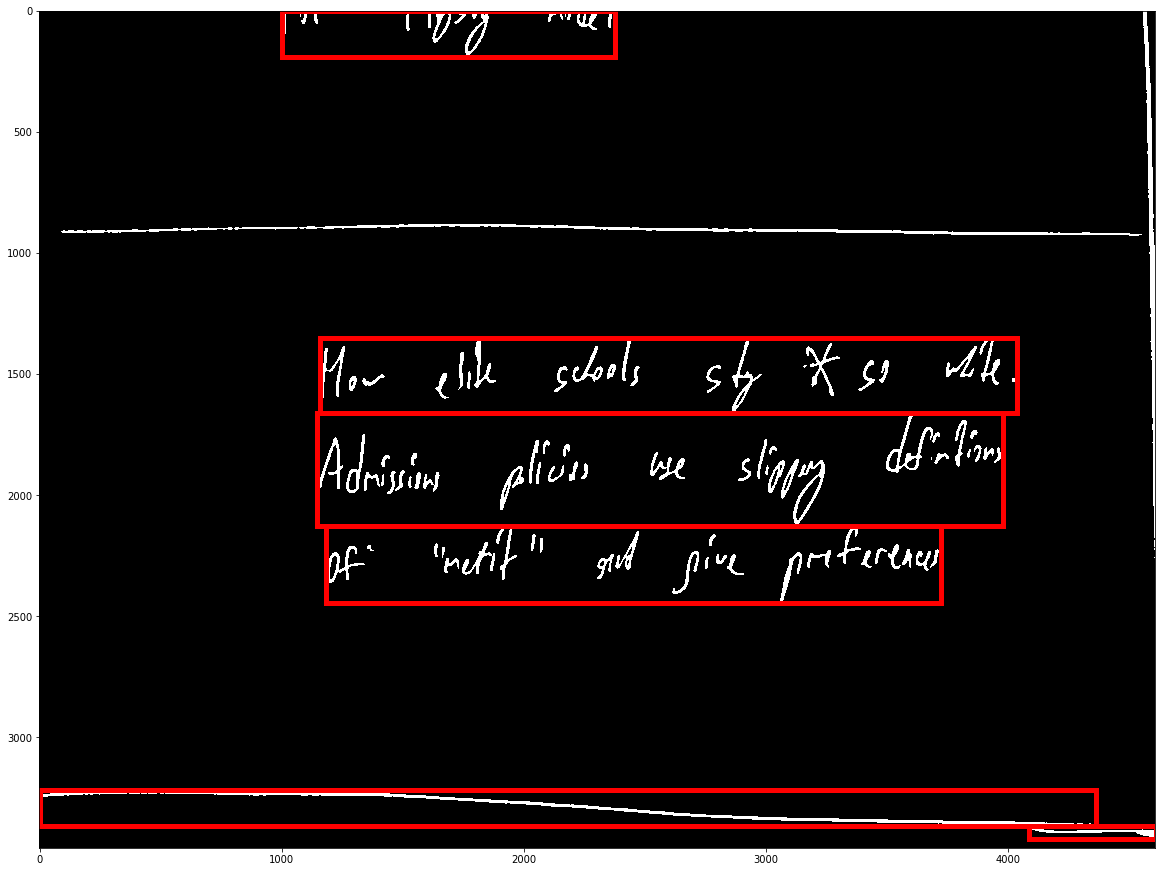

33: ../admin/cursive_ai/camera_images/IMG_6733.jpg
text_span_along_w, text_span_along_h:  816 4032
image is rotated


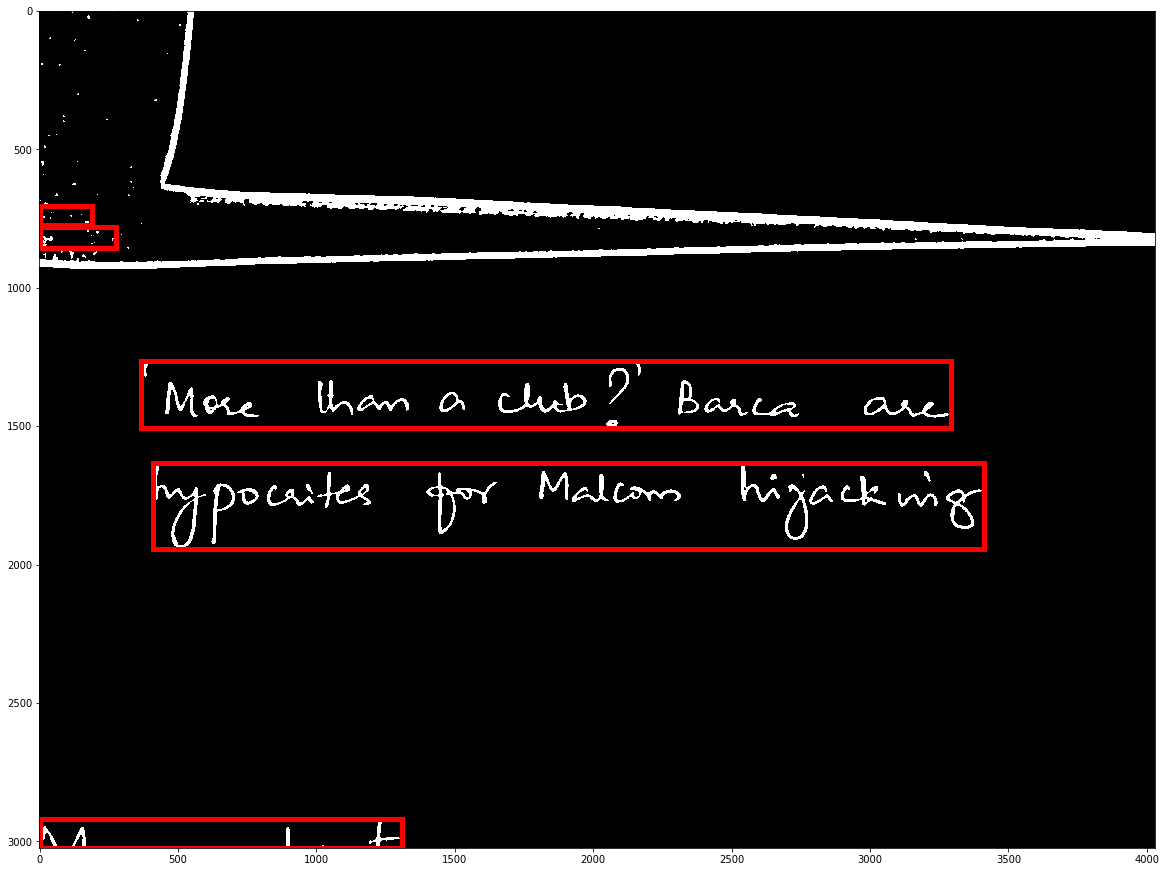

34: ../admin/cursive_ai/camera_images/IMG_20180725_132508.jpg
text_span_along_w, text_span_along_h:  938 3650
image is rotated


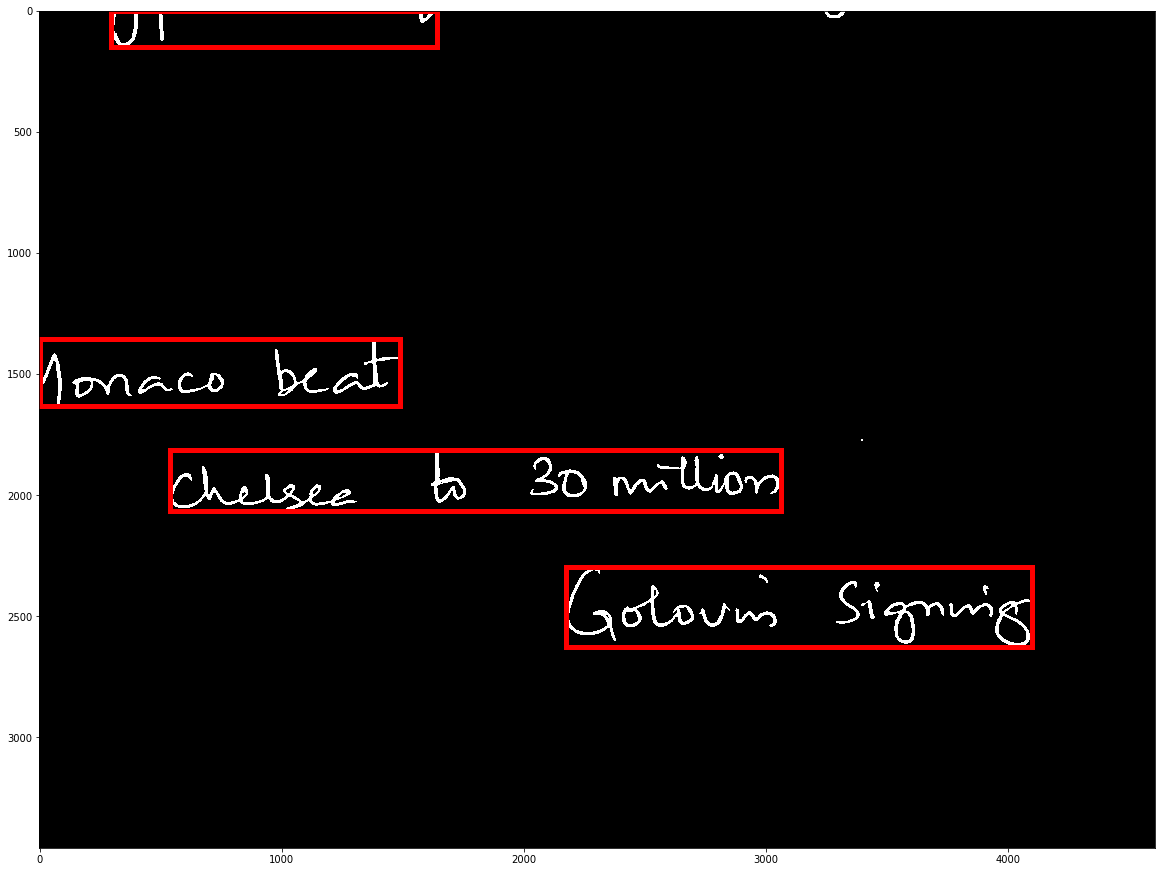

35: ../admin/cursive_ai/camera_images/IMG_6747.jpg
text_span_along_w, text_span_along_h:  869 250


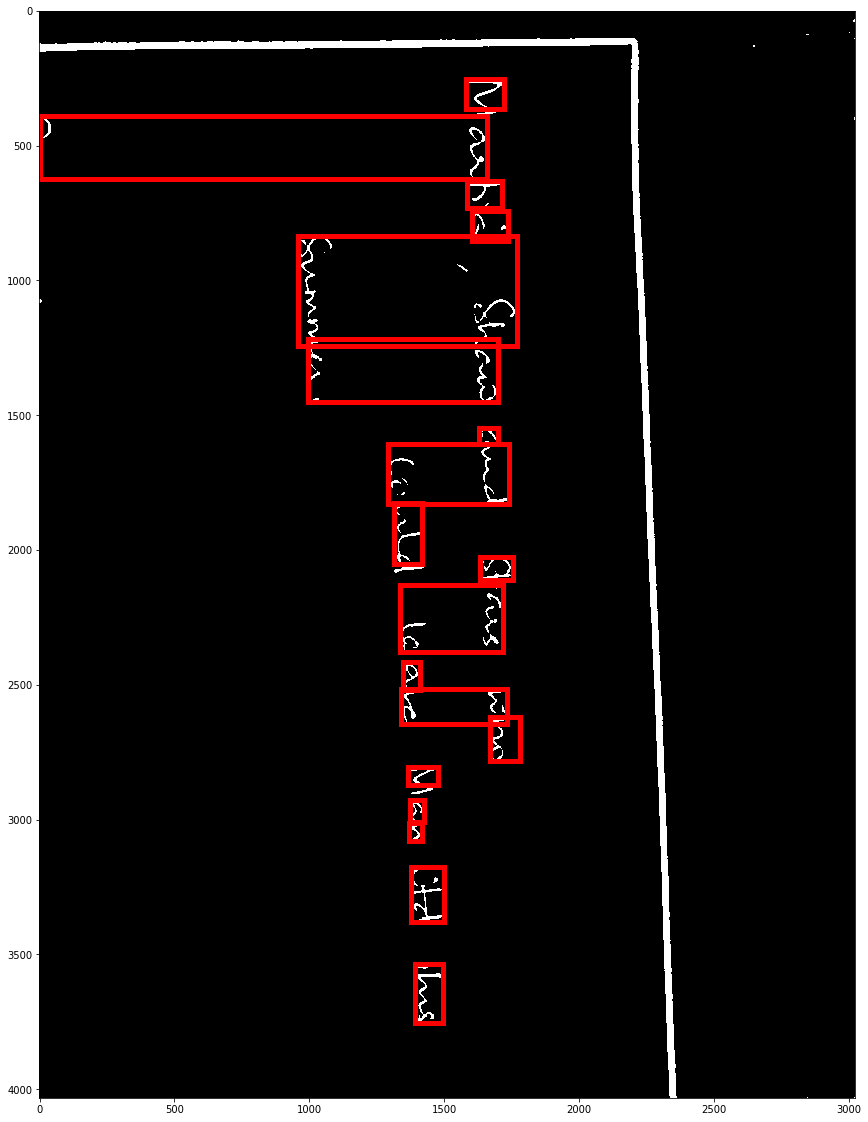

36: ../admin/cursive_ai/camera_images/IMG_20180725_132449.jpg
text_span_along_w, text_span_along_h:  405 3973
image is rotated


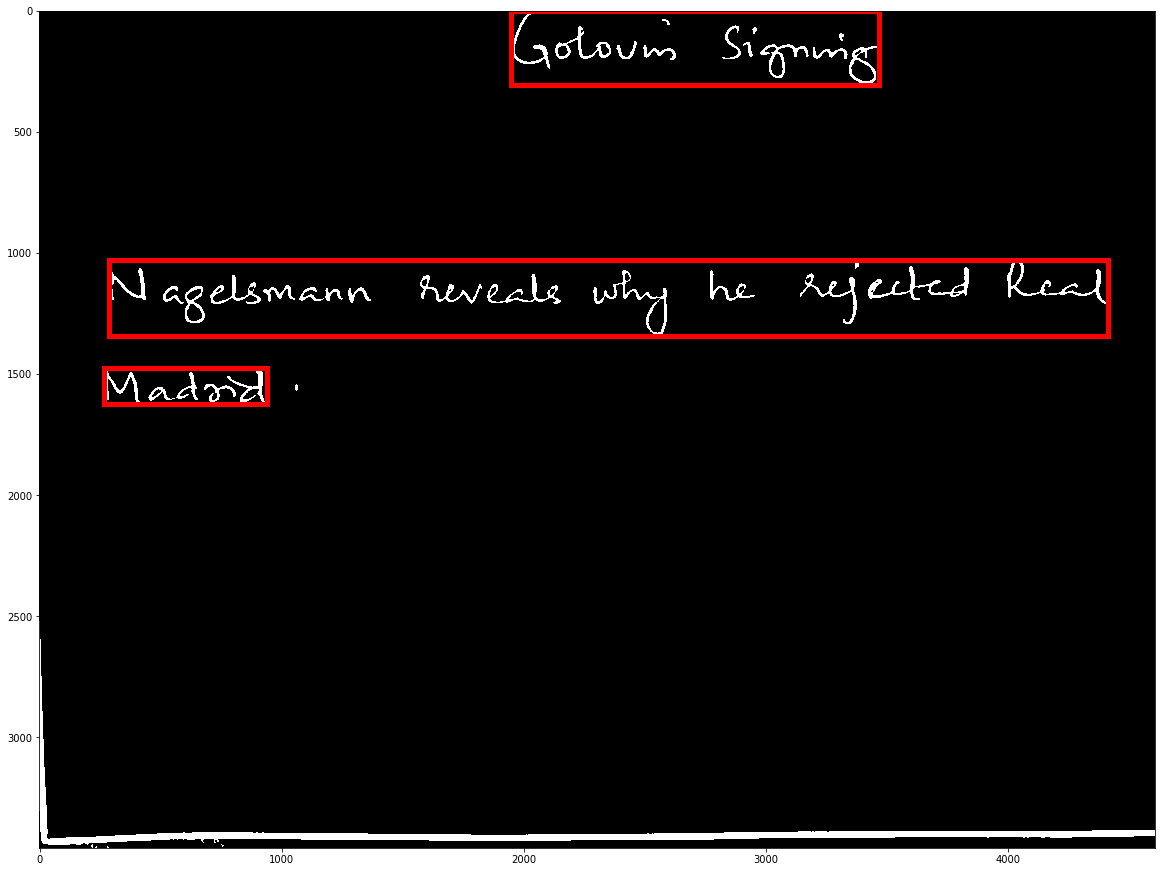

37: ../admin/cursive_ai/camera_images/IMG_6736.jpg
text_span_along_w, text_span_along_h:  746 4032
image is rotated


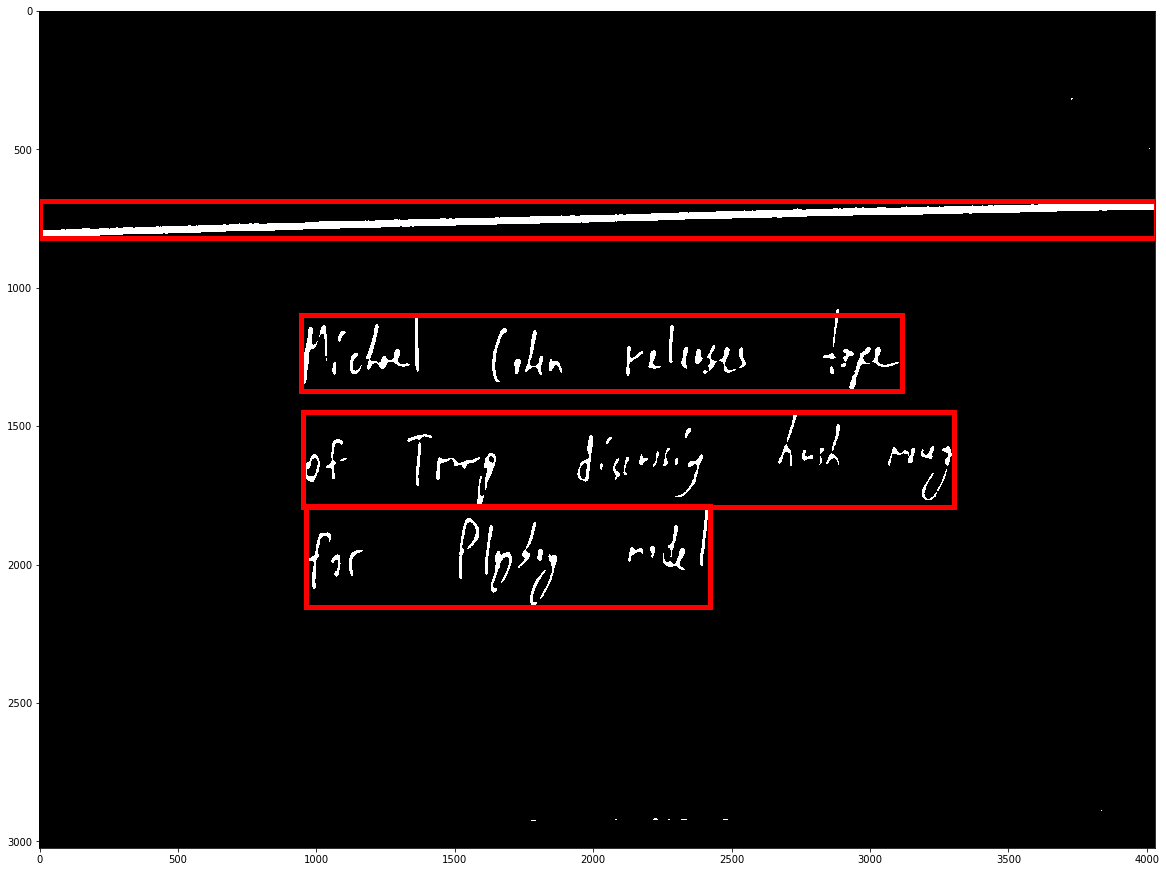

38: ../admin/cursive_ai/camera_images/IMG_20180725_132027.jpg
text_span_along_w, text_span_along_h:  2112 1649


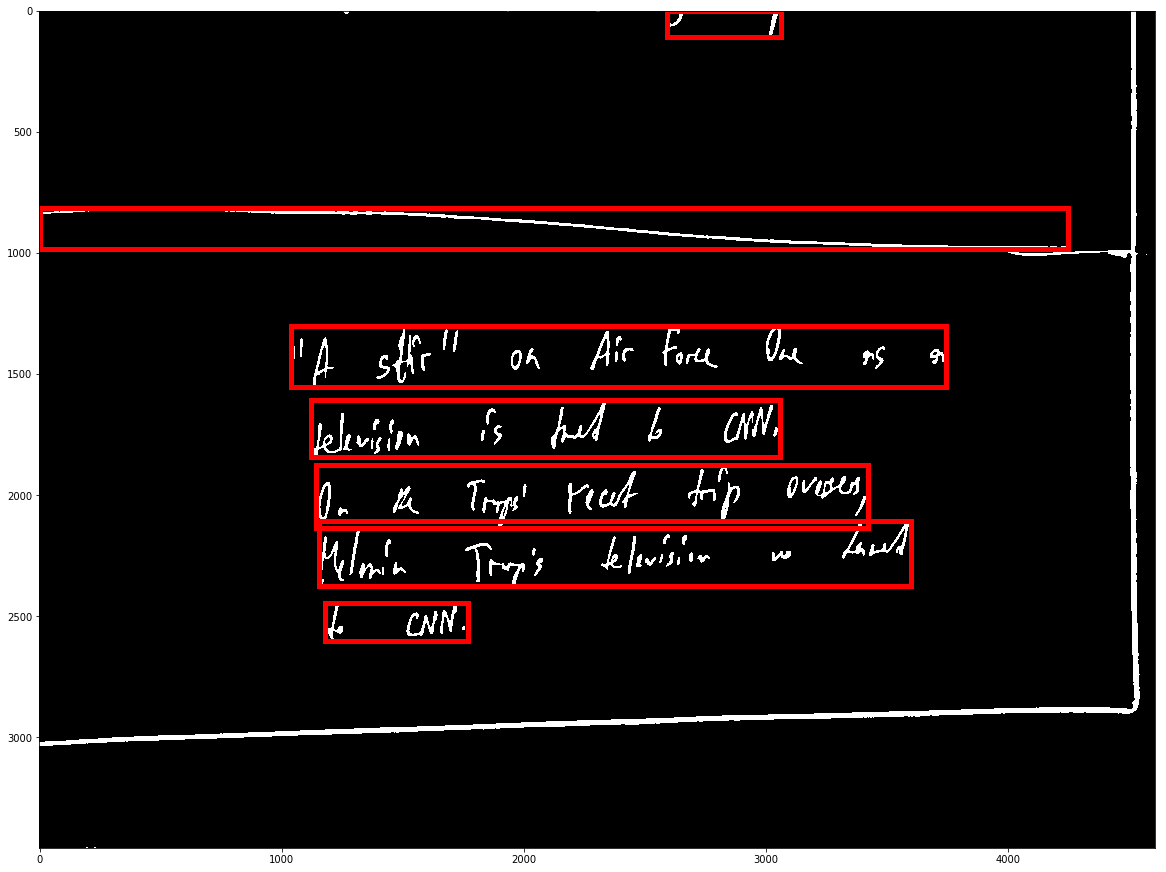

39: ../admin/cursive_ai/camera_images/IMG_6730.jpg
text_span_along_w, text_span_along_h:  626 3424
image is rotated


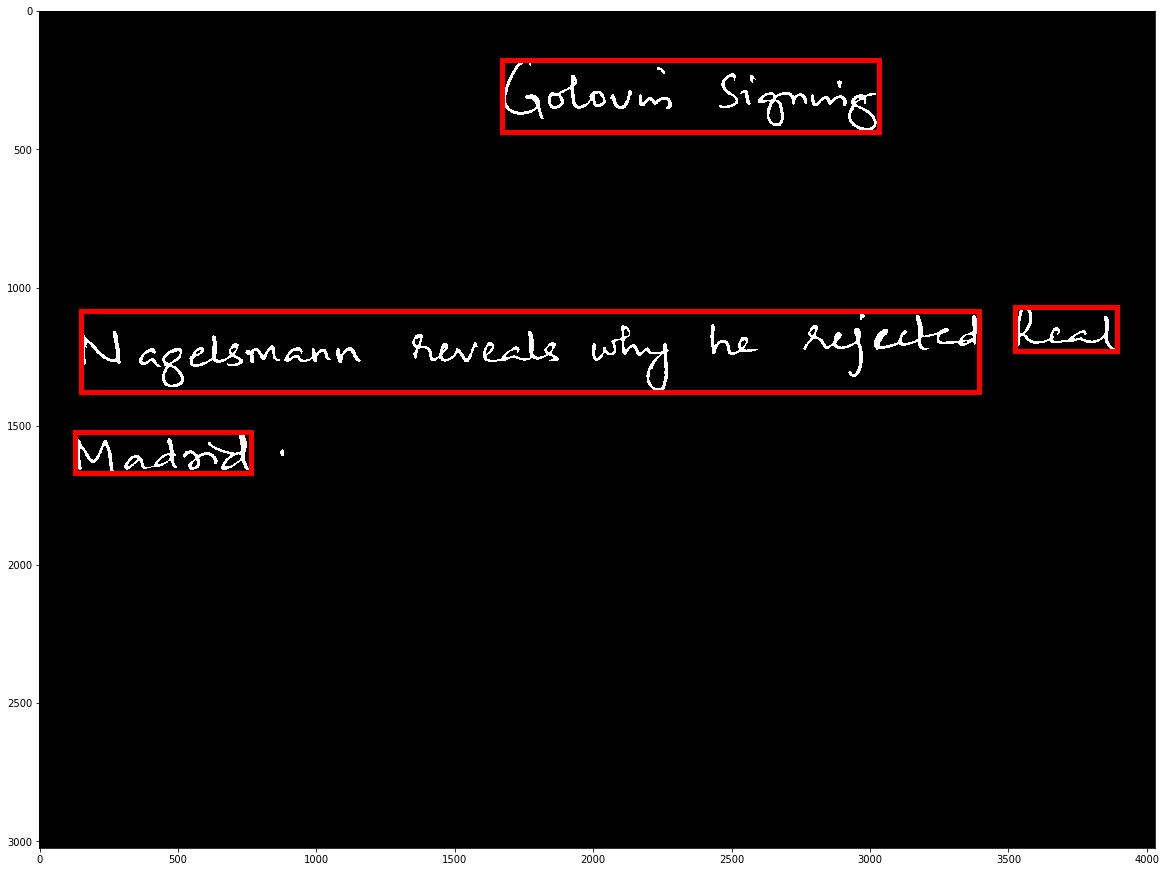

40: ../admin/cursive_ai/camera_images/IMG_20180725_132459.jpg
text_span_along_w, text_span_along_h:  831 4608
image is rotated


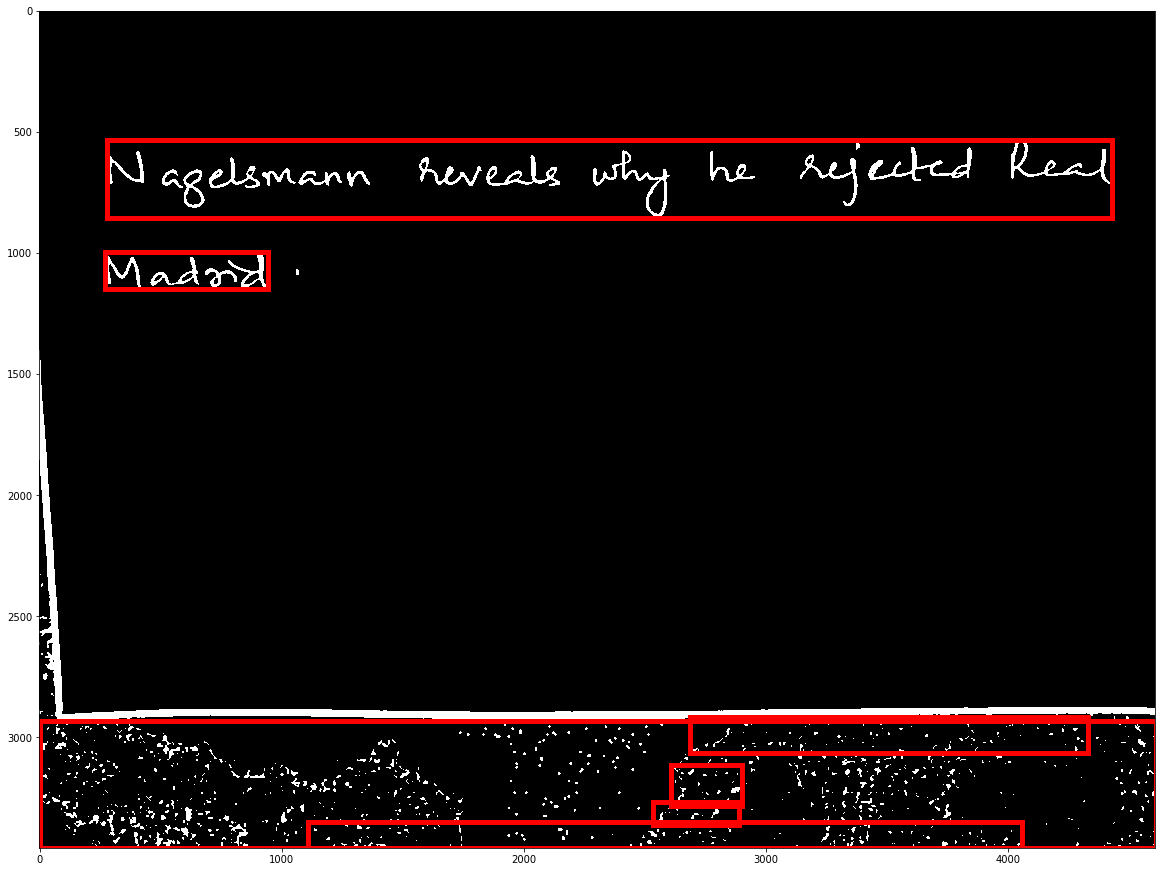

41: ../admin/cursive_ai/camera_images/IMG_6741.jpg
text_span_along_w, text_span_along_h:  593 4032
image is rotated


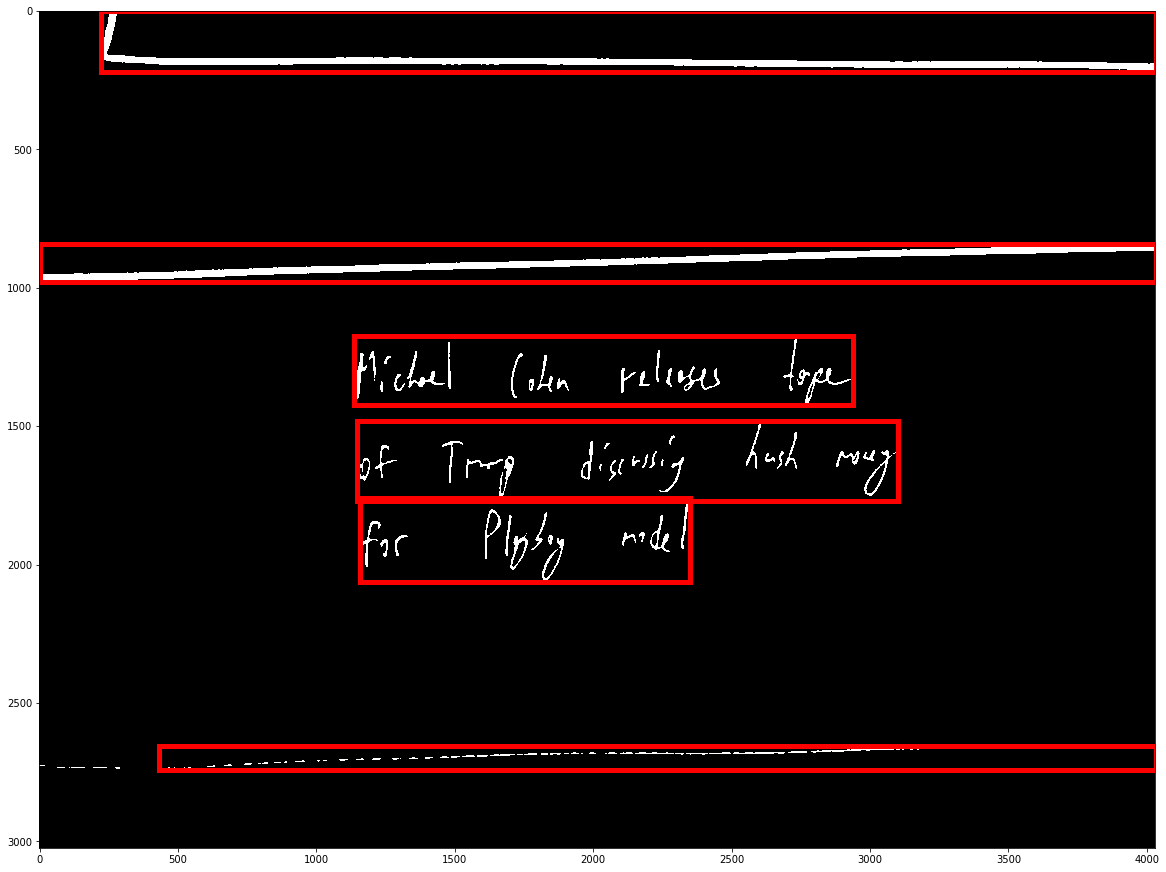

42: ../admin/cursive_ai/camera_images/IMG_20180725_132423.jpg
text_span_along_w, text_span_along_h:  561 1065
image is rotated


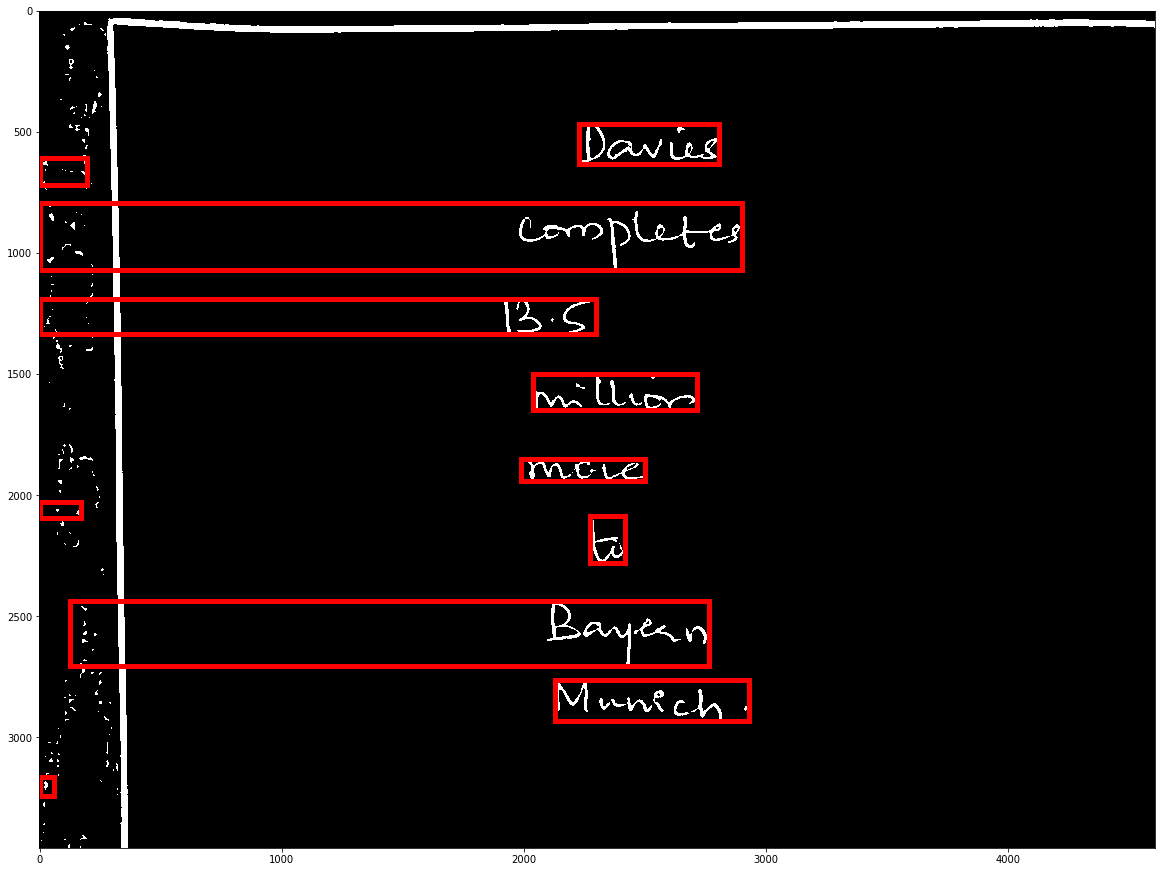

43: ../admin/cursive_ai/camera_images/IMG_20180725_132259.jpg
text_span_along_w, text_span_along_h:  2256 1251


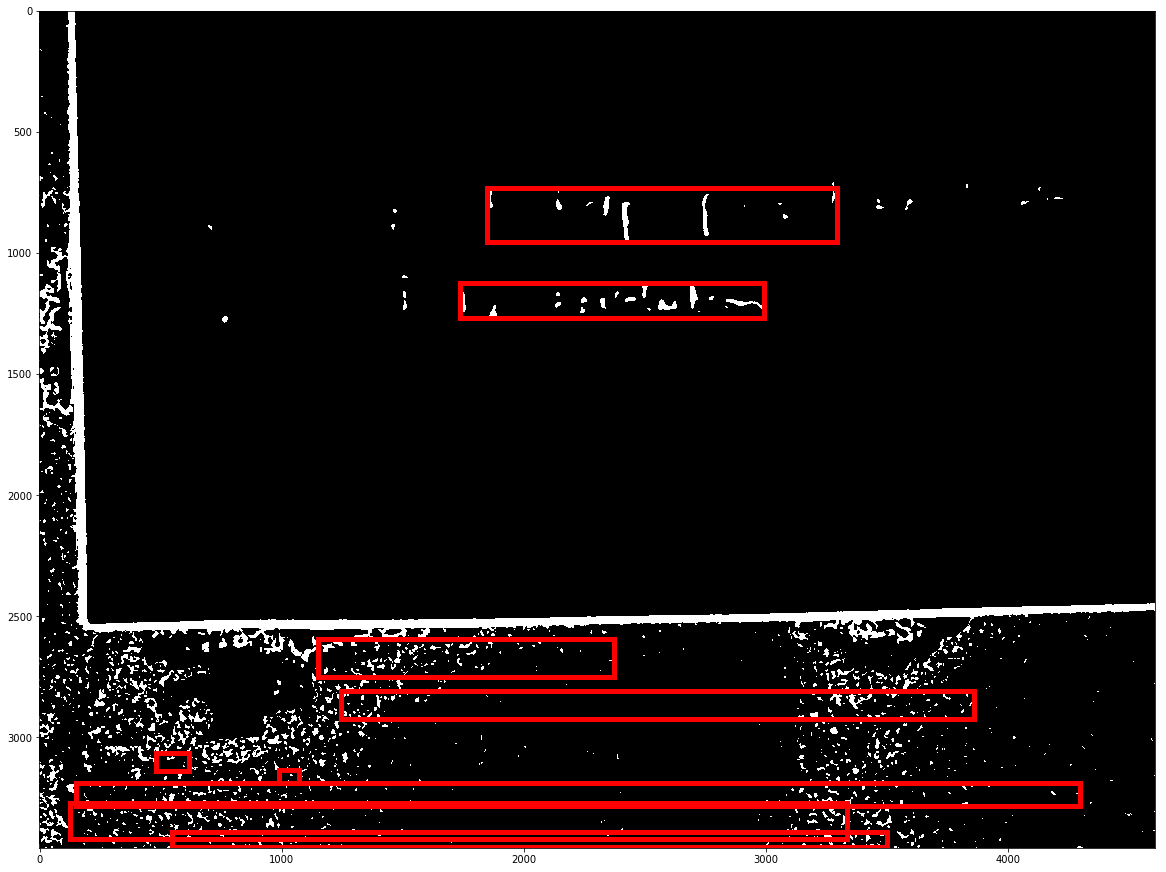

44: ../admin/cursive_ai/camera_images/IMG_6746.jpg
text_span_along_w, text_span_along_h:  334 2404
image is rotated


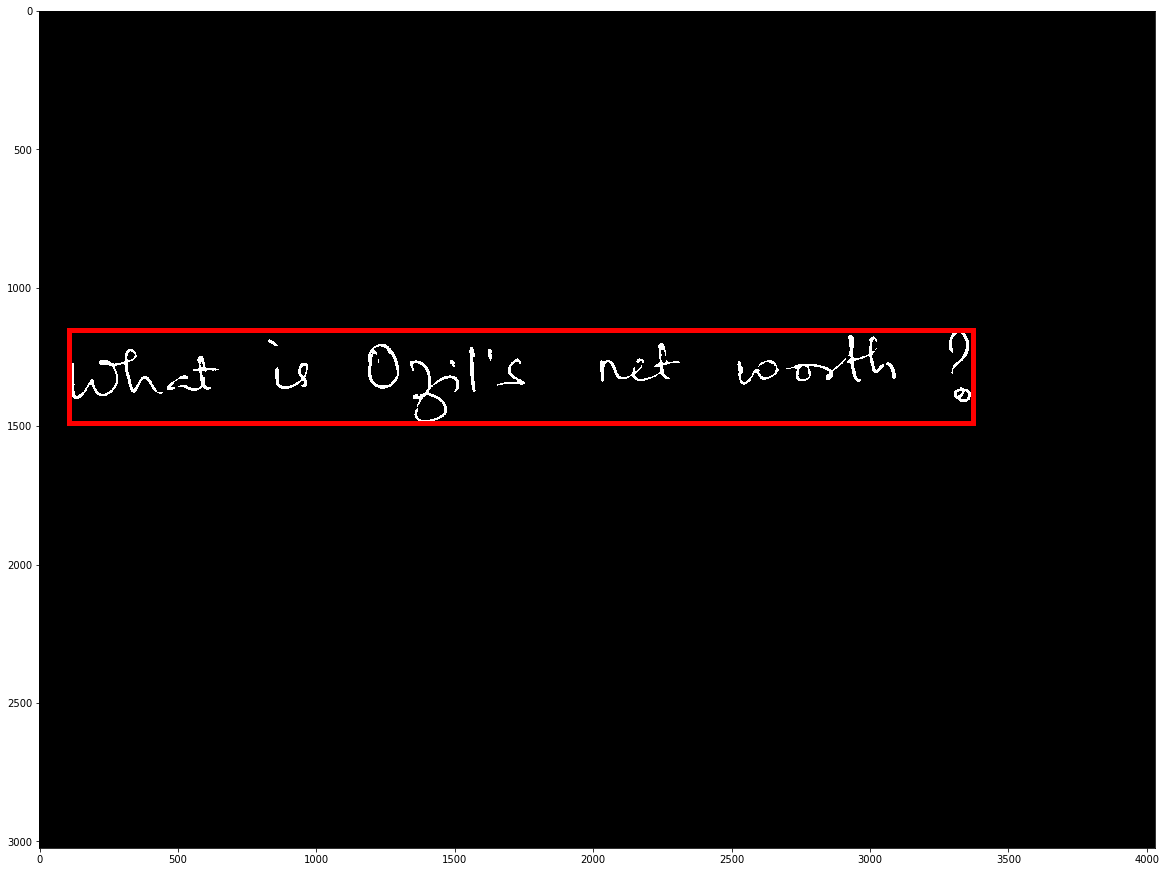

45: ../admin/cursive_ai/camera_images/IMG_20180725_132241.jpg
text_span_along_w, text_span_along_h:  120 3456
image is rotated


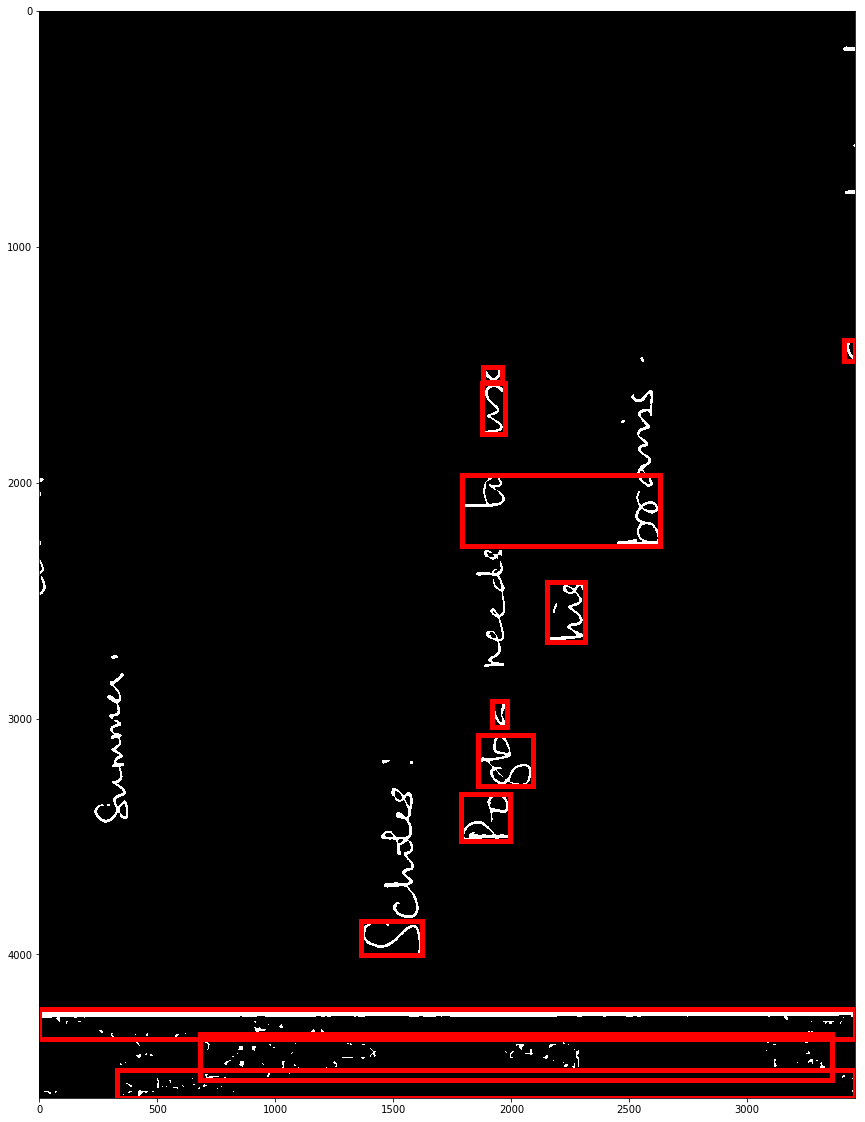

46: ../admin/cursive_ai/camera_images/IMG_6728.jpg
text_span_along_w, text_span_along_h:  722 4032
image is rotated


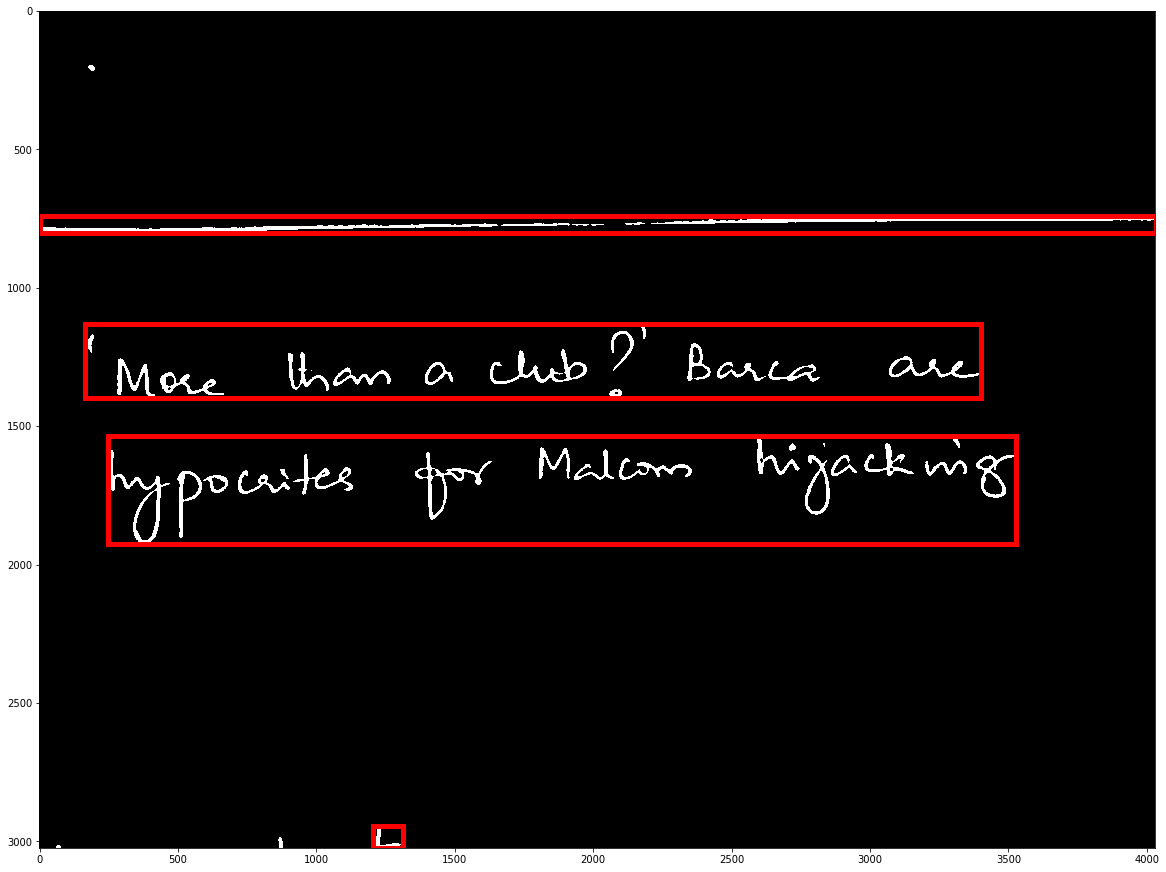

47: ../admin/cursive_ai/camera_images/IMG_6721.jpg
text_span_along_w, text_span_along_h:  980 3174
image is rotated


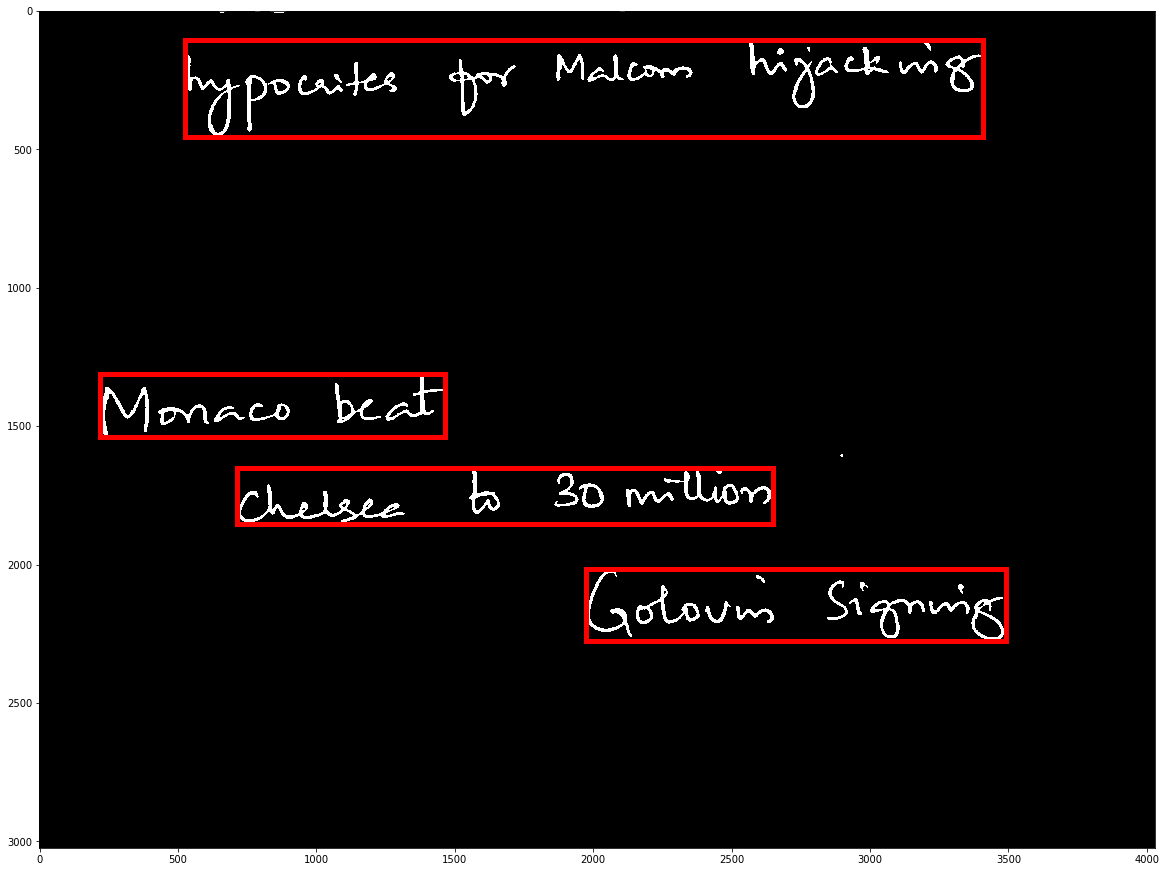

48: ../admin/cursive_ai/camera_images/IMG_6725.jpg
text_span_along_w, text_span_along_h:  878 1539
image is rotated


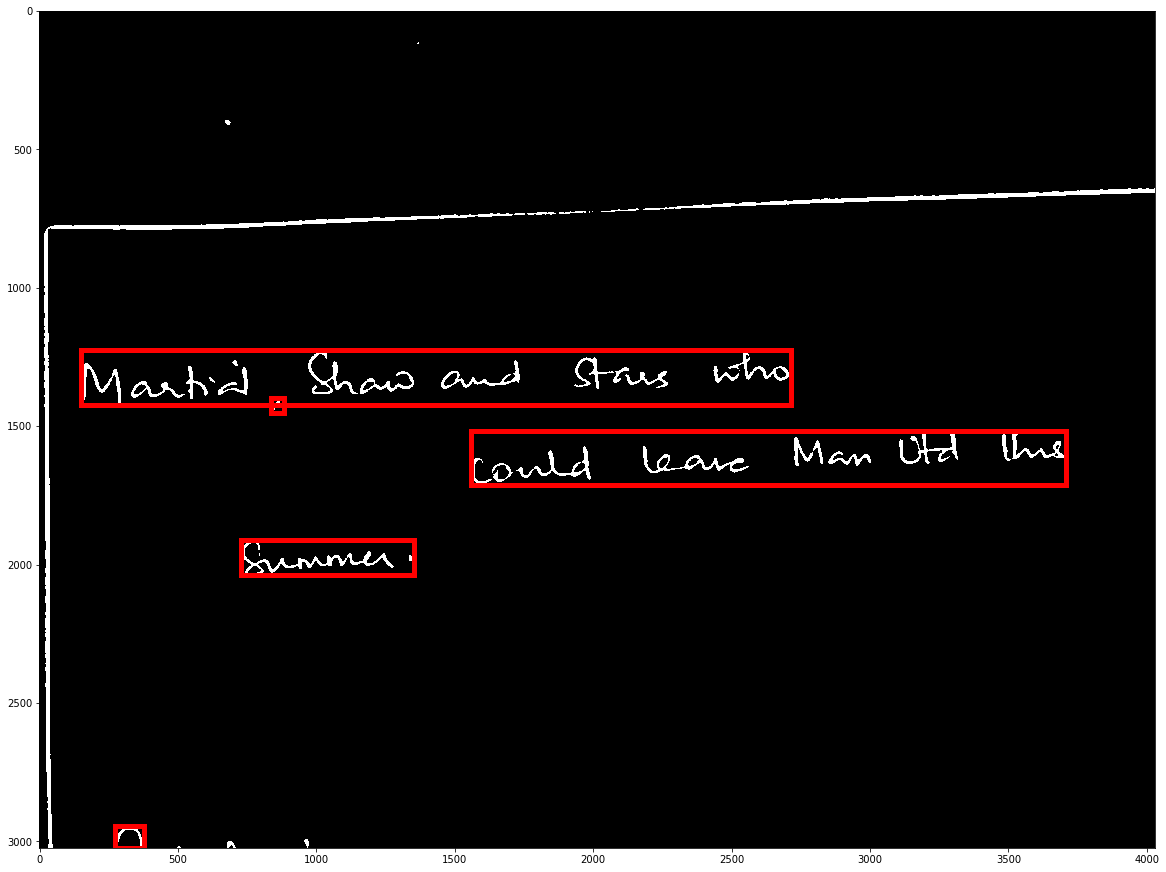

49: ../admin/cursive_ai/camera_images/IMG_6718.jpg
text_span_along_w, text_span_along_h:  1528 1277


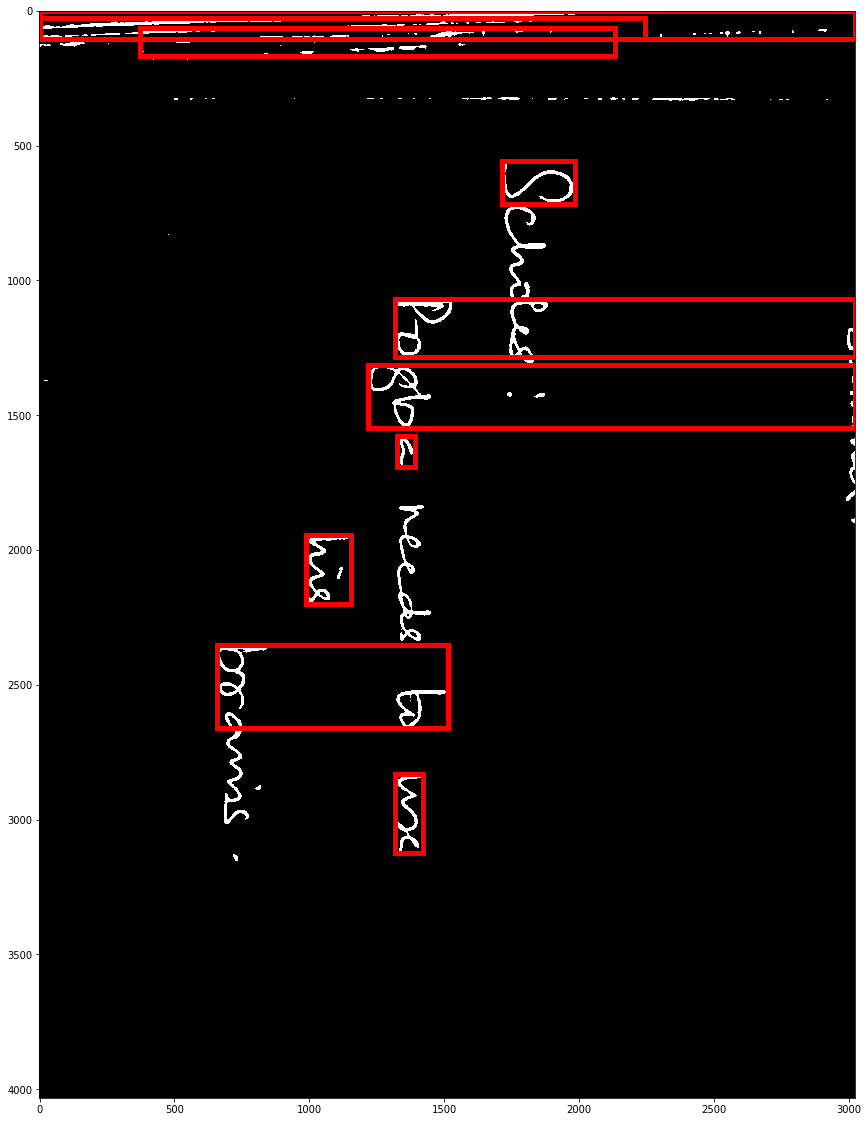

50: ../admin/cursive_ai/camera_images/IMG_6722.jpg
text_span_along_w, text_span_along_h:  534 3318
image is rotated


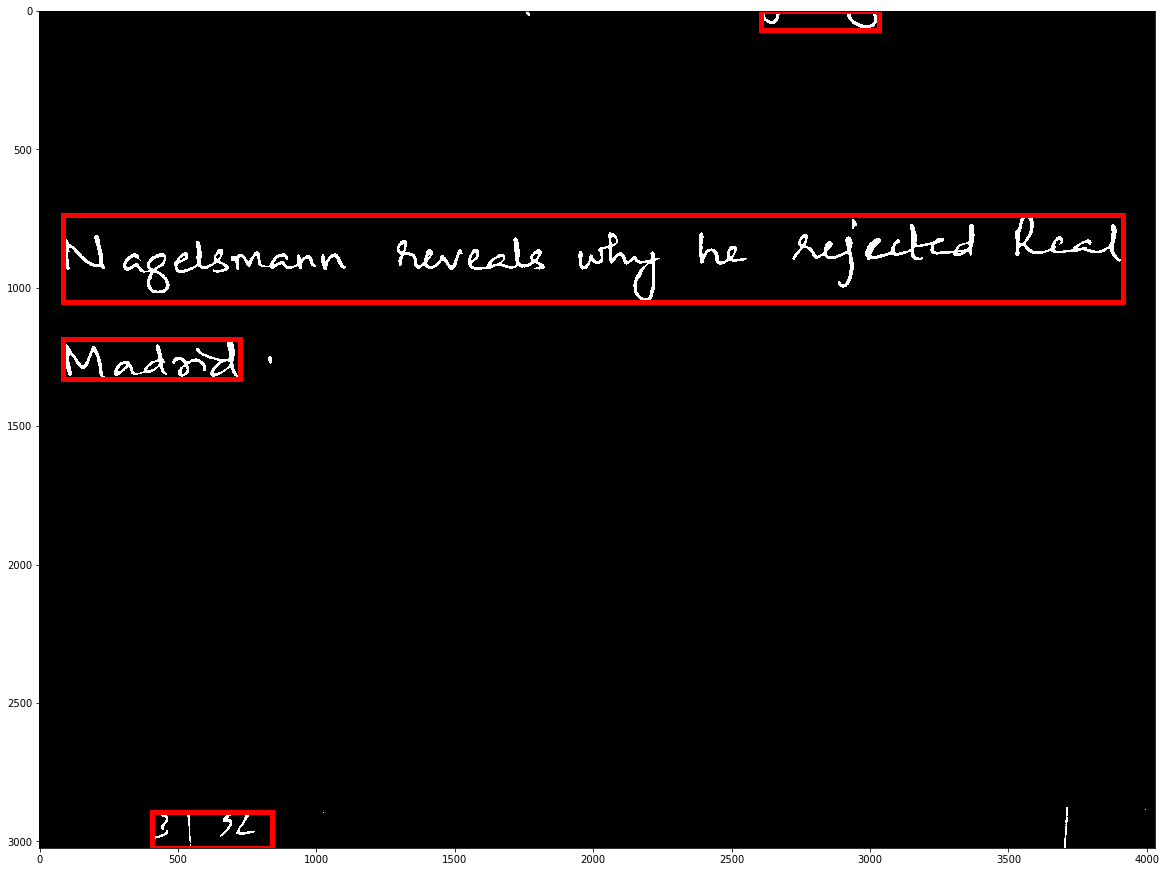

51: ../admin/cursive_ai/camera_images/IMG_6734.jpg
text_span_along_w, text_span_along_h:  817 3263
image is rotated


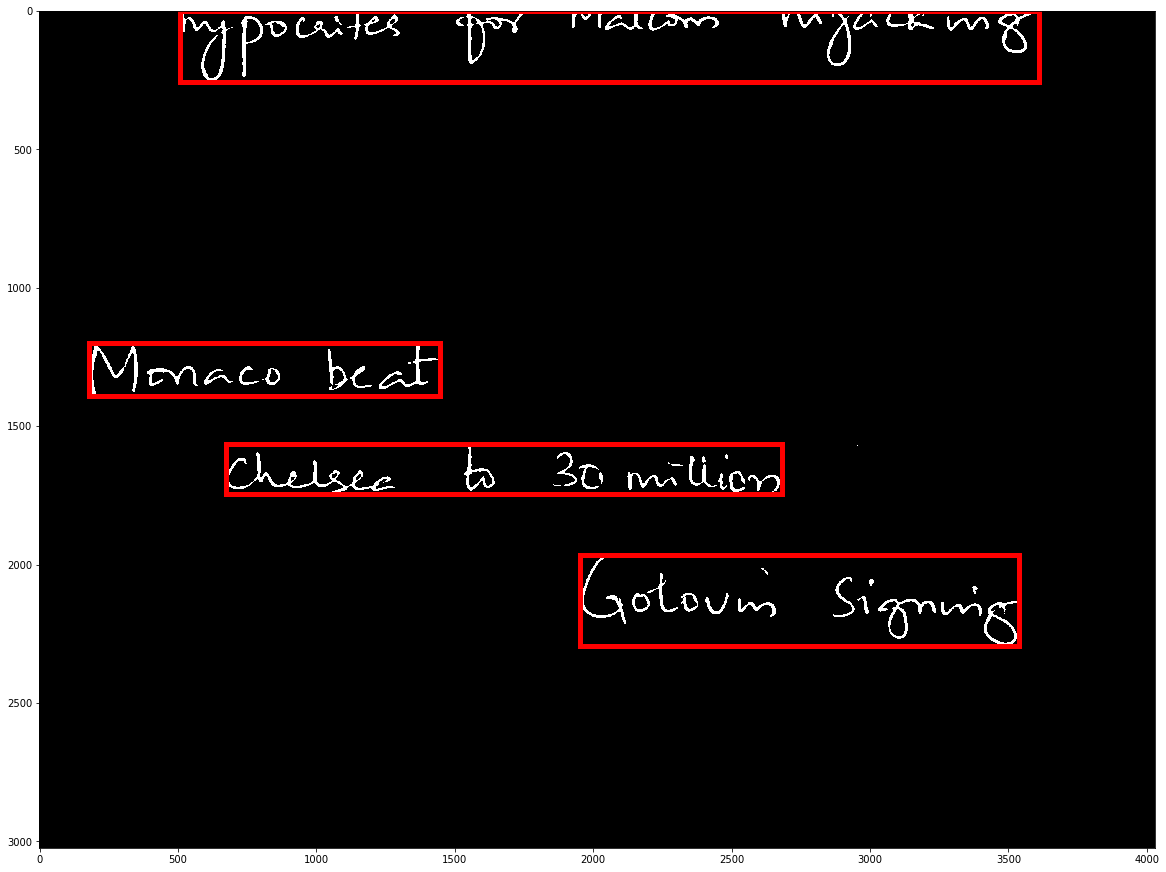

52: ../admin/cursive_ai/camera_images/IMG_6720.jpg
text_span_along_w, text_span_along_h:  543 4019
image is rotated


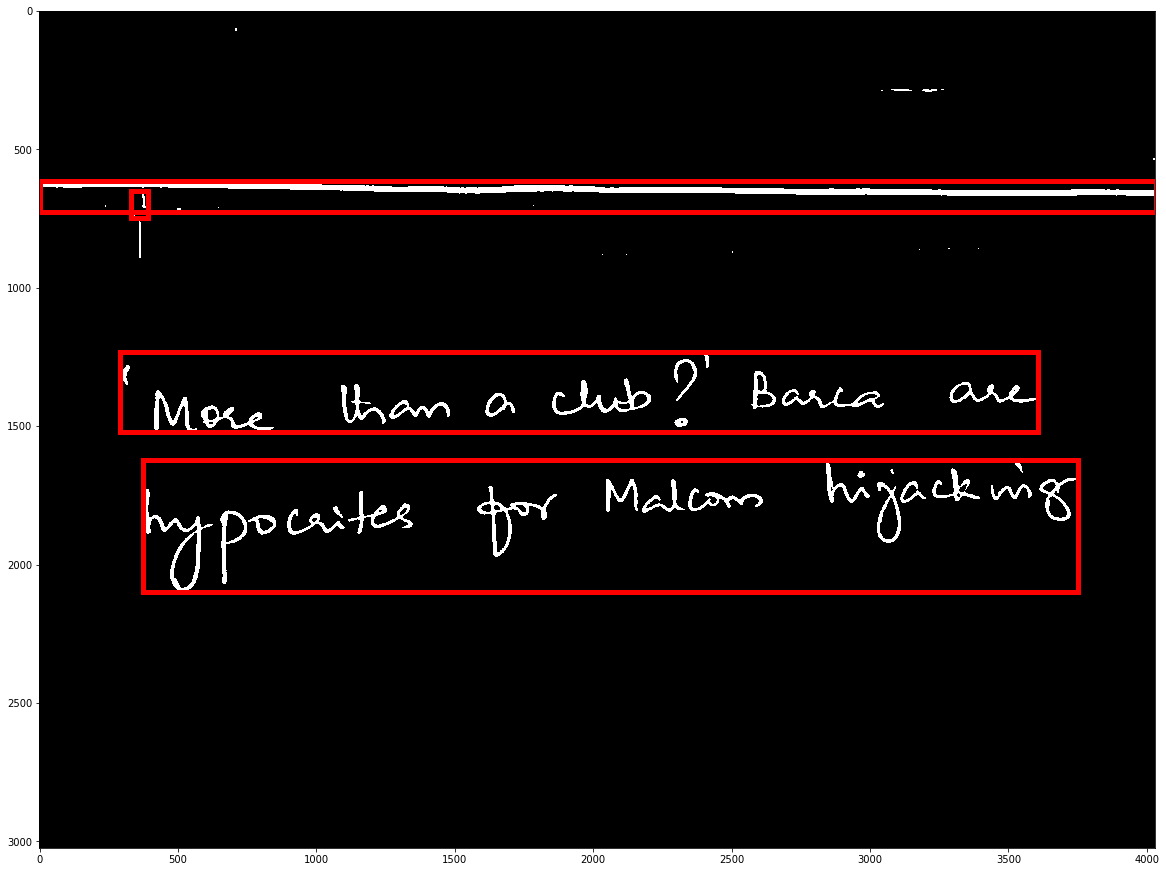

53: ../admin/cursive_ai/camera_images/IMG_6719.jpg
text_span_along_w, text_span_along_h:  818 3912
image is rotated


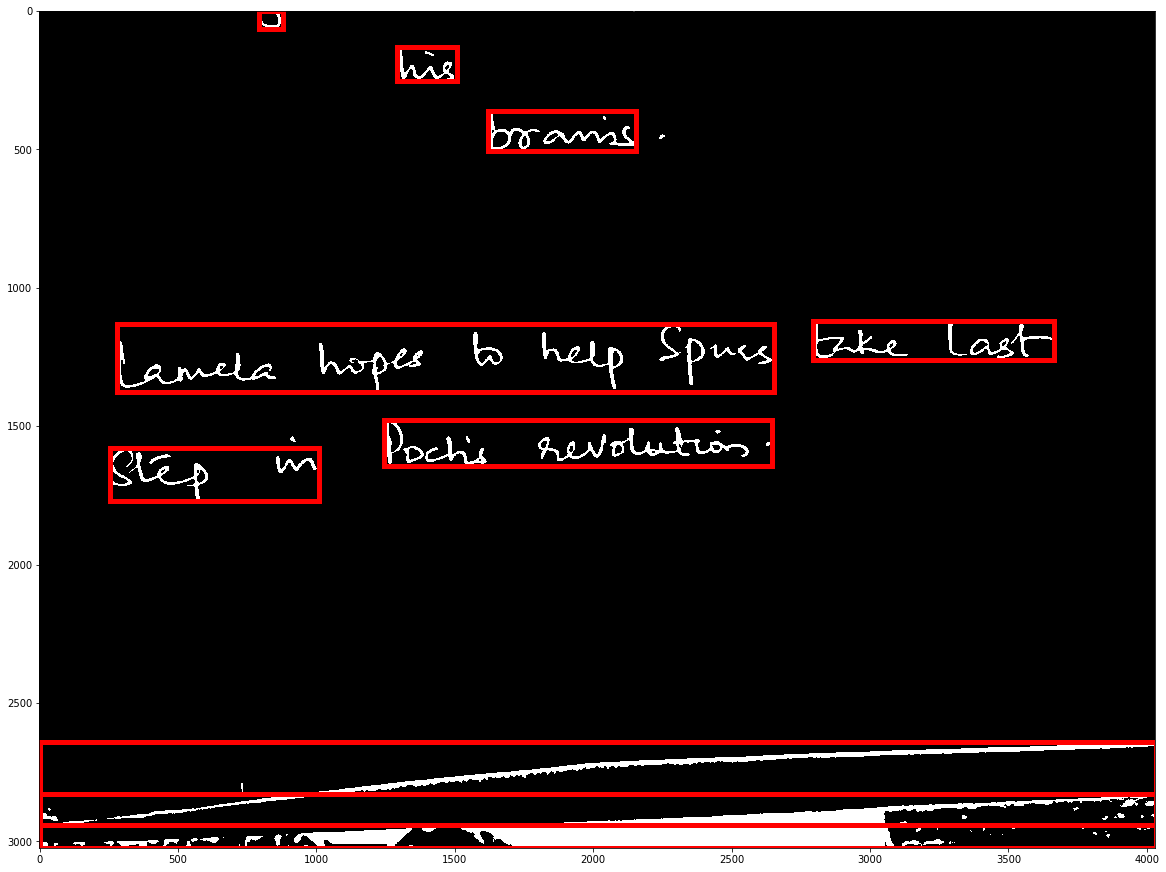

54: ../admin/cursive_ai/camera_images/IMG_6709.jpg
text_span_along_w, text_span_along_h:  4032 1055


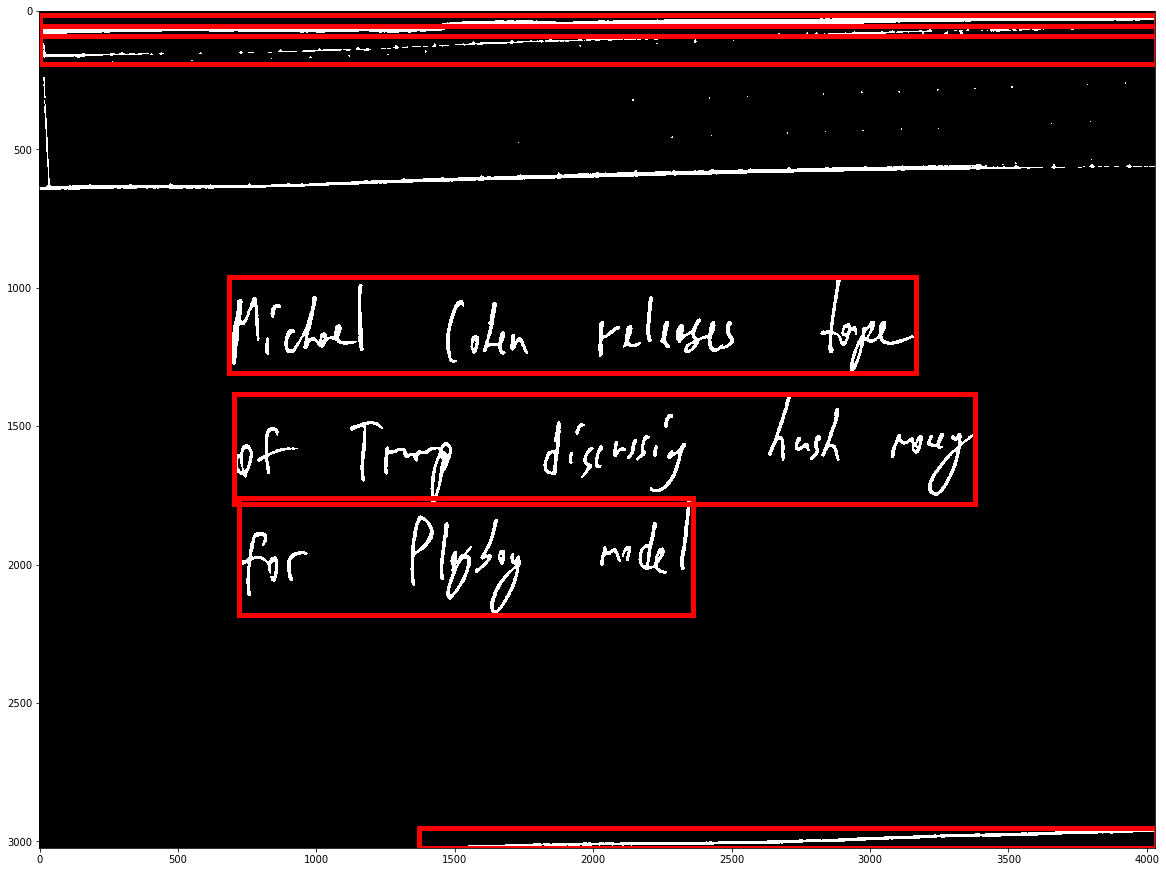

55: ../admin/cursive_ai/camera_images/IMG_6743.jpg
text_span_along_w, text_span_along_h:  1249 128


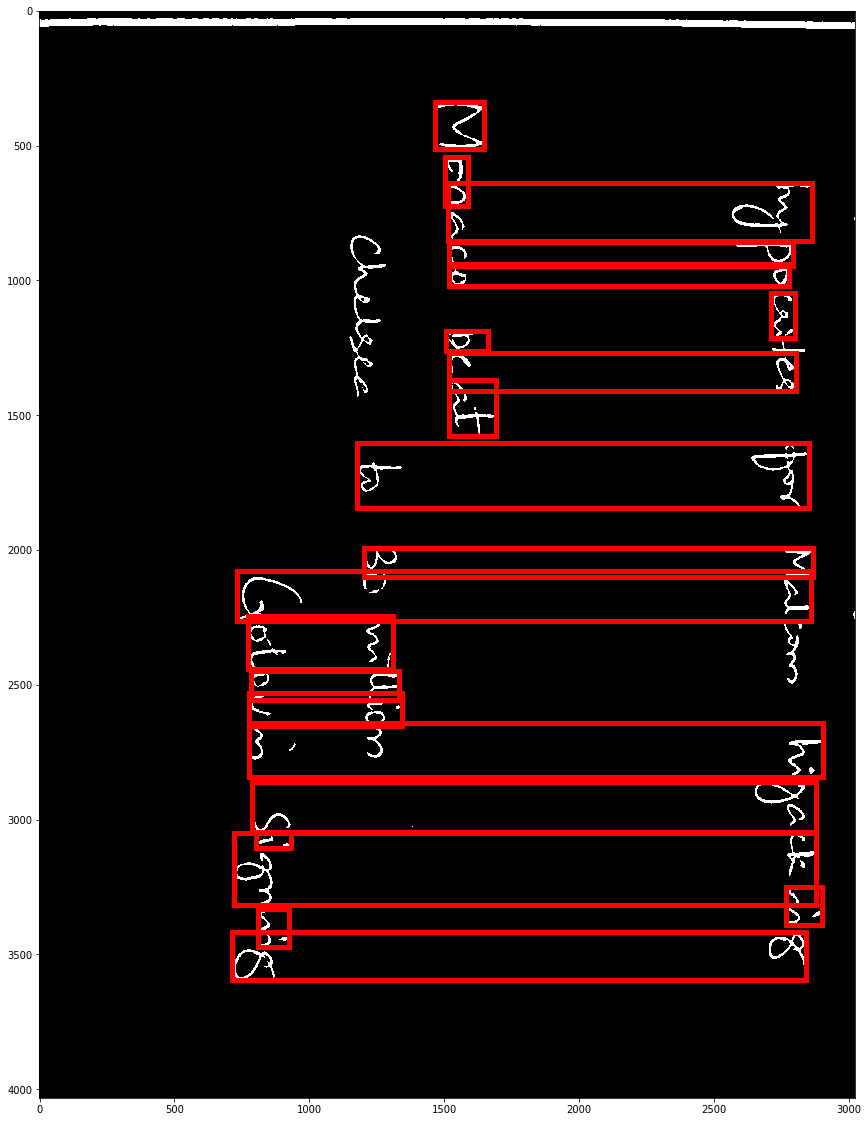

56: ../admin/cursive_ai/camera_images/IMG_20180725_132216.jpg
text_span_along_w, text_span_along_h:  1227 2311
image is rotated


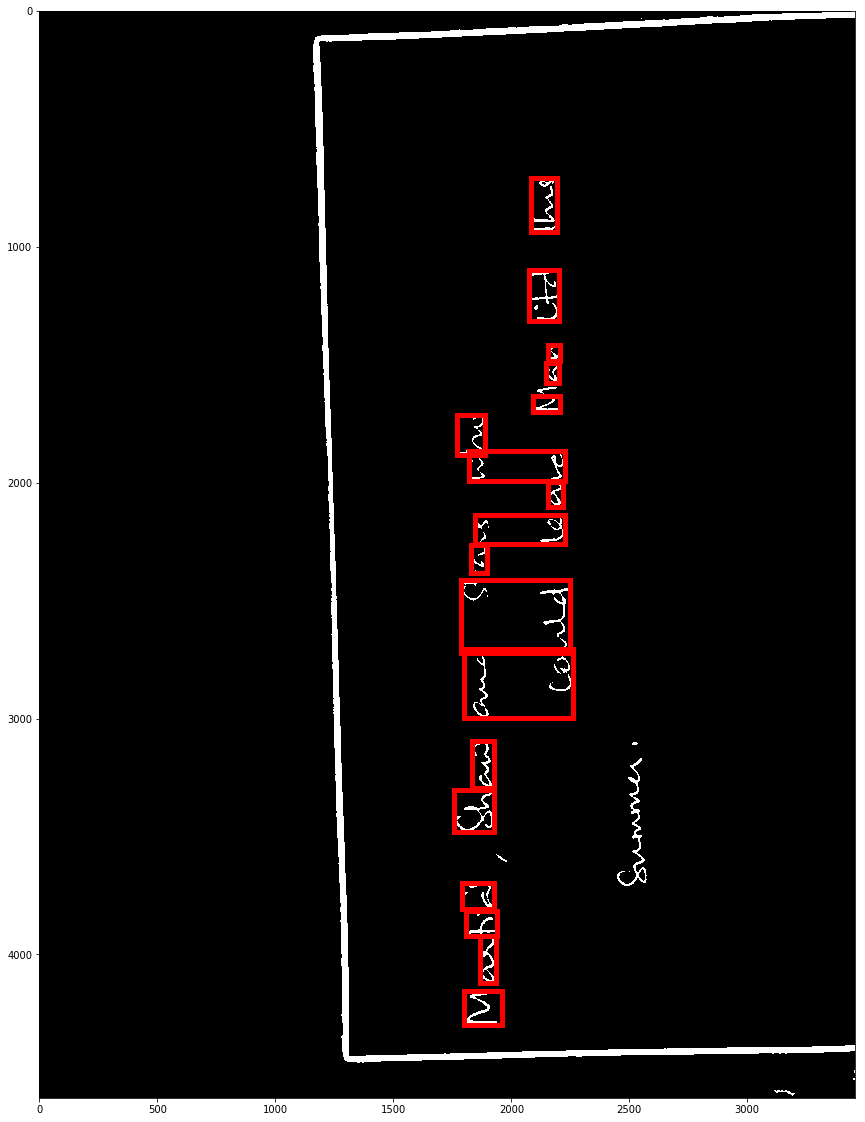

57: ../admin/cursive_ai/camera_images/IMG_20180725_132419.jpg
text_span_along_w, text_span_along_h:  2895 450


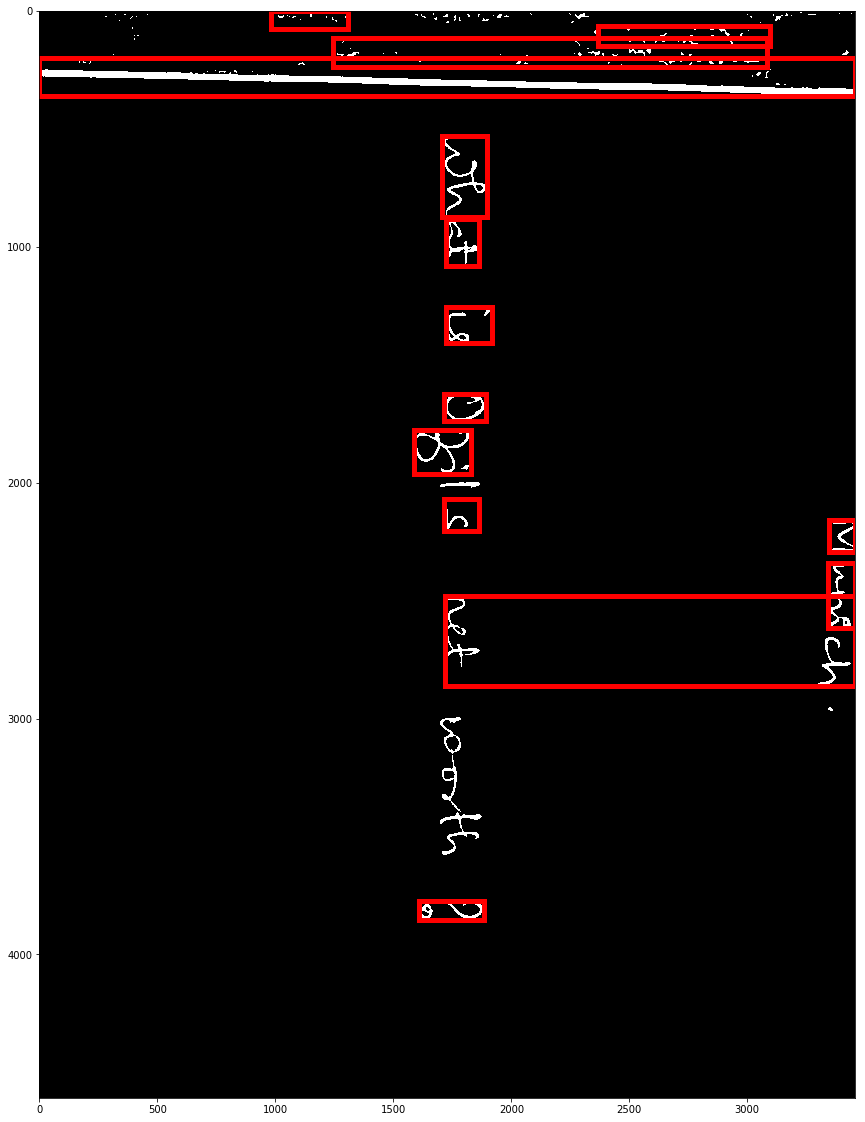

58: ../admin/cursive_ai/camera_images/IMG_6727.jpg
text_span_along_w, text_span_along_h:  1010 4032
image is rotated


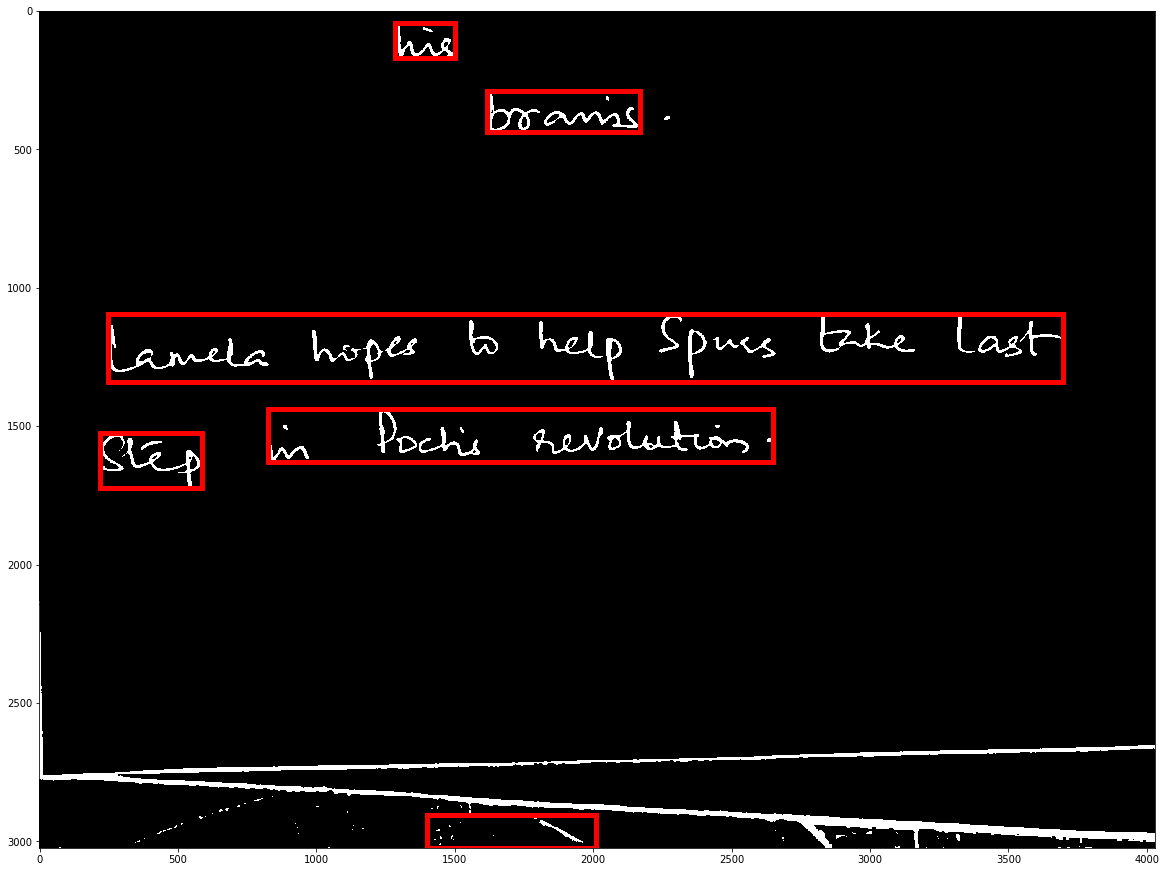

59: ../admin/cursive_ai/camera_images/IMG_6735.jpg
text_span_along_w, text_span_along_h:  898 3433
image is rotated


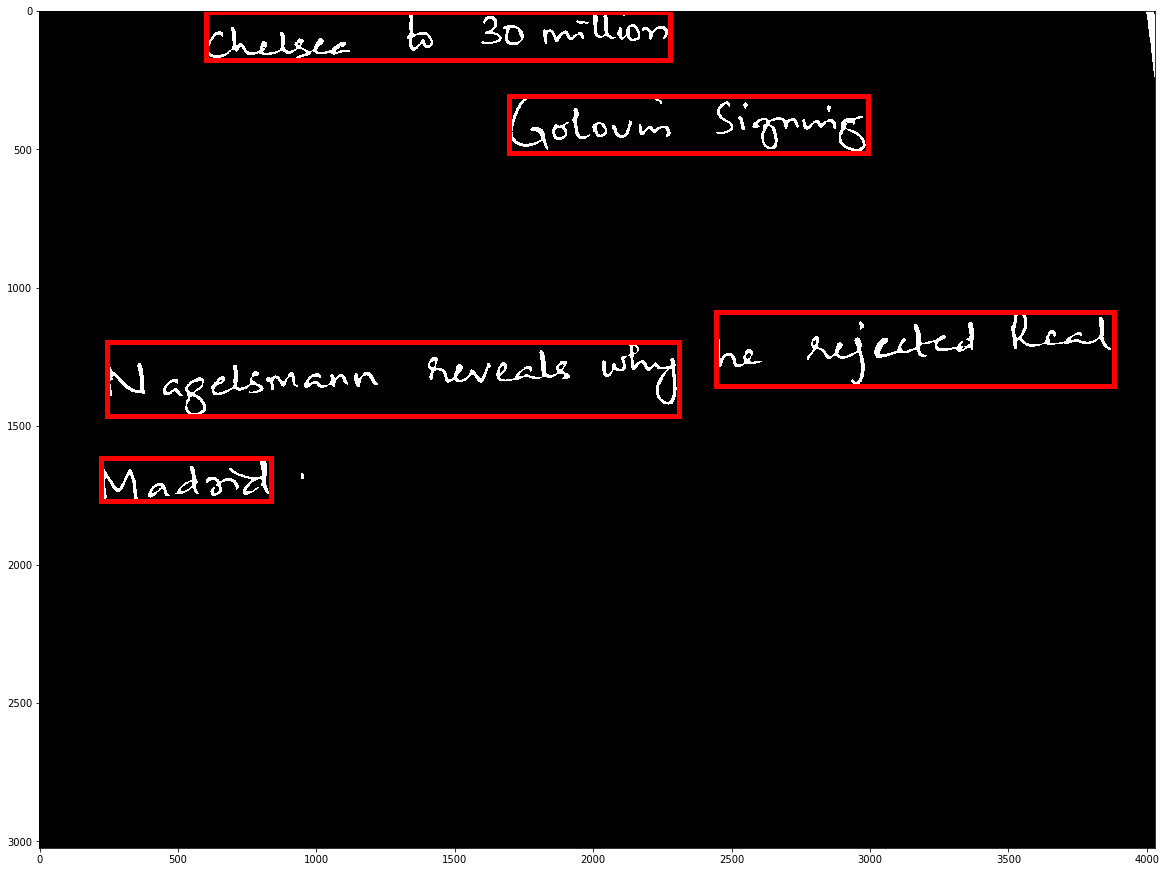

60: ../admin/cursive_ai/camera_images/IMG_20180725_132409.jpg
text_span_along_w, text_span_along_h:  943 1183
image is rotated


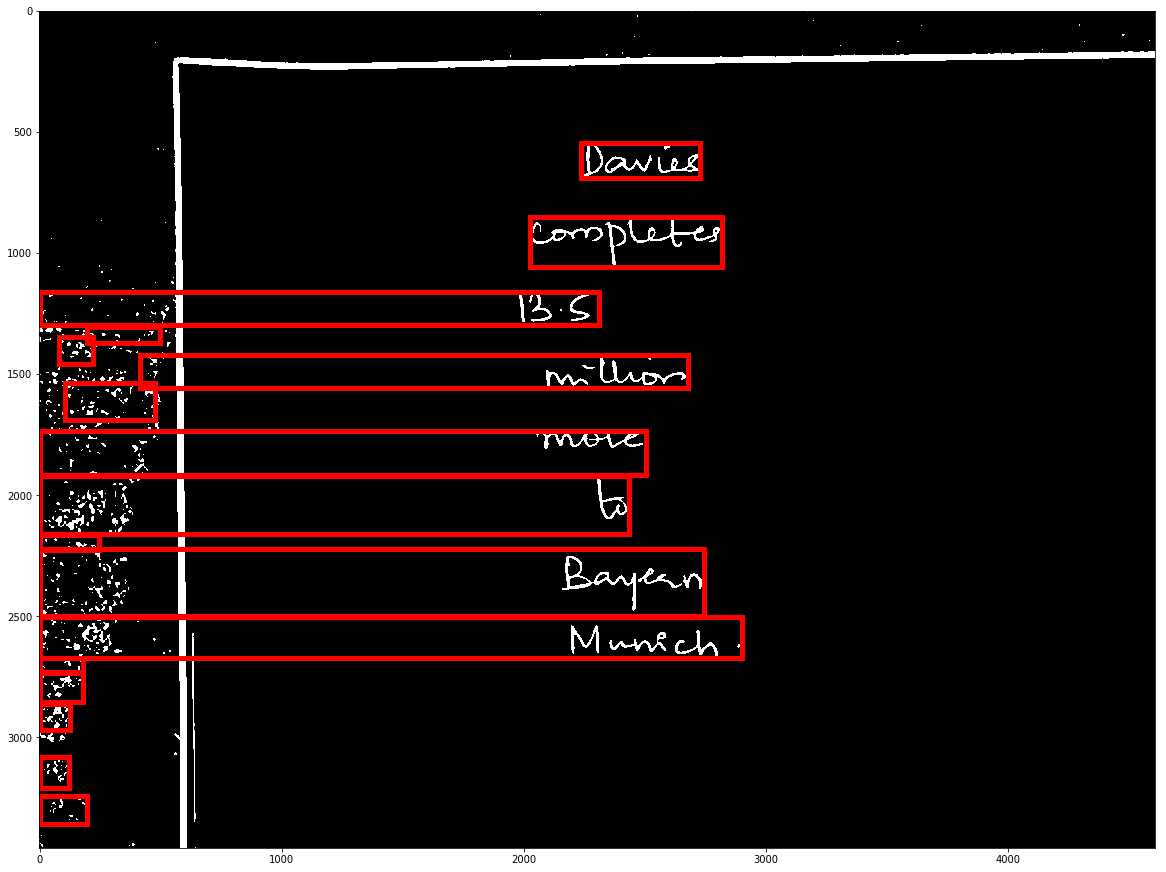

61: ../admin/cursive_ai/camera_images/IMG_20180725_131908.jpg
text_span_along_w, text_span_along_h:  801 2190
image is rotated


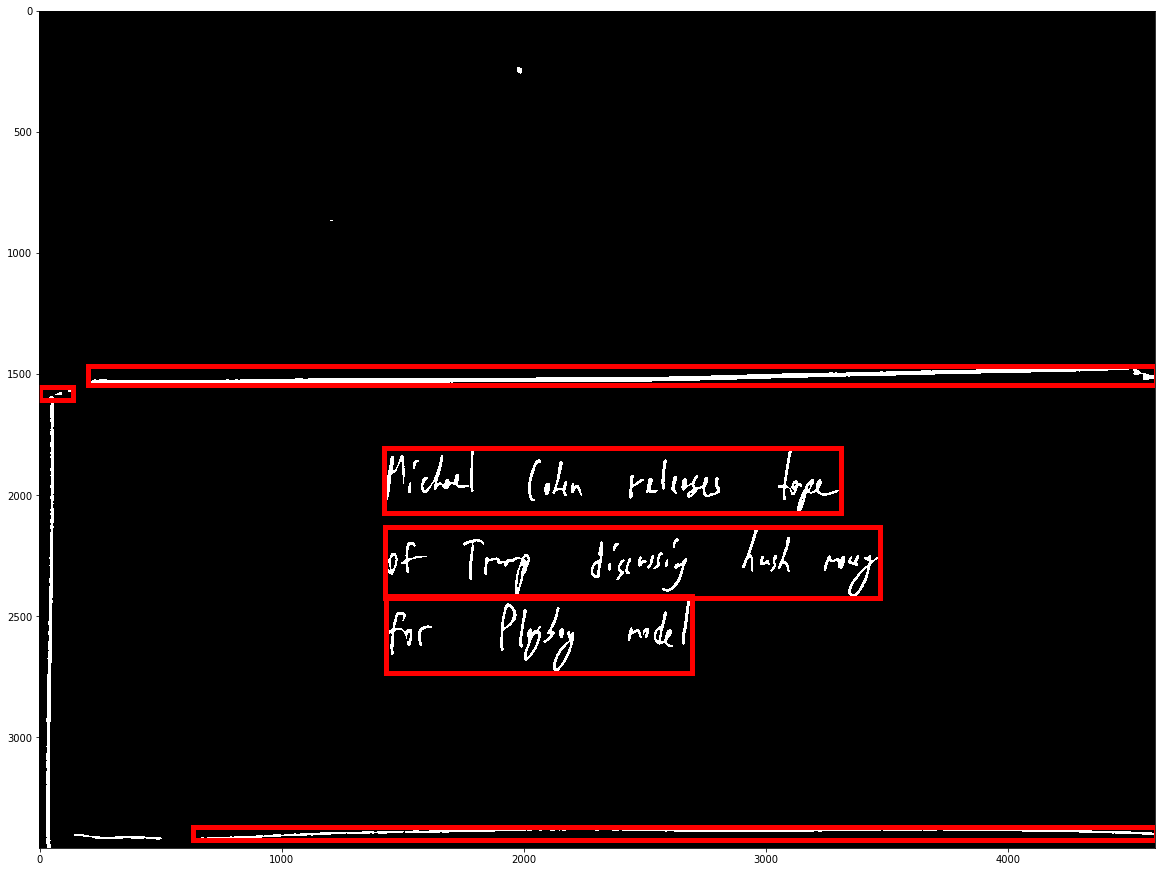

62: ../admin/cursive_ai/camera_images/IMG_6742.jpg
text_span_along_w, text_span_along_h:  702 4032
image is rotated


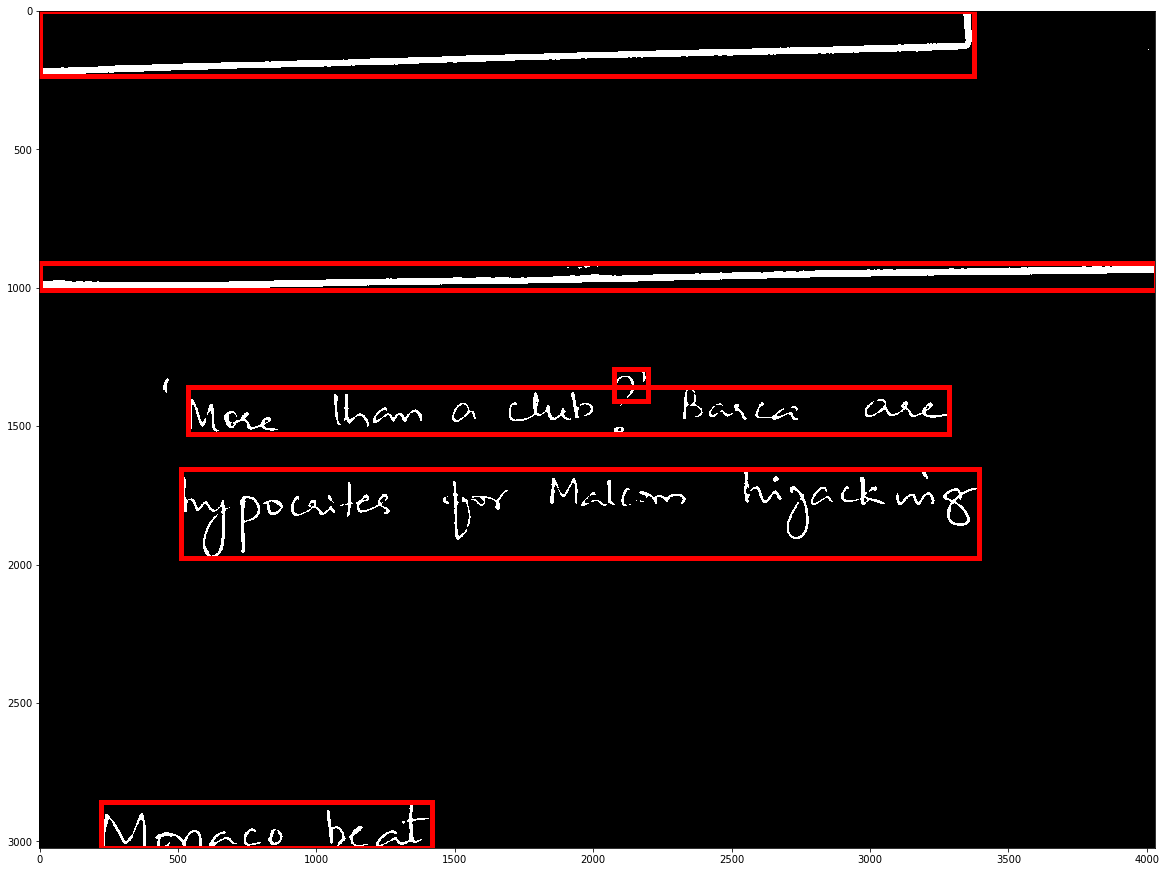

63: ../admin/cursive_ai/camera_images/IMG_6745.jpg
text_span_along_w, text_span_along_h:  1384 981


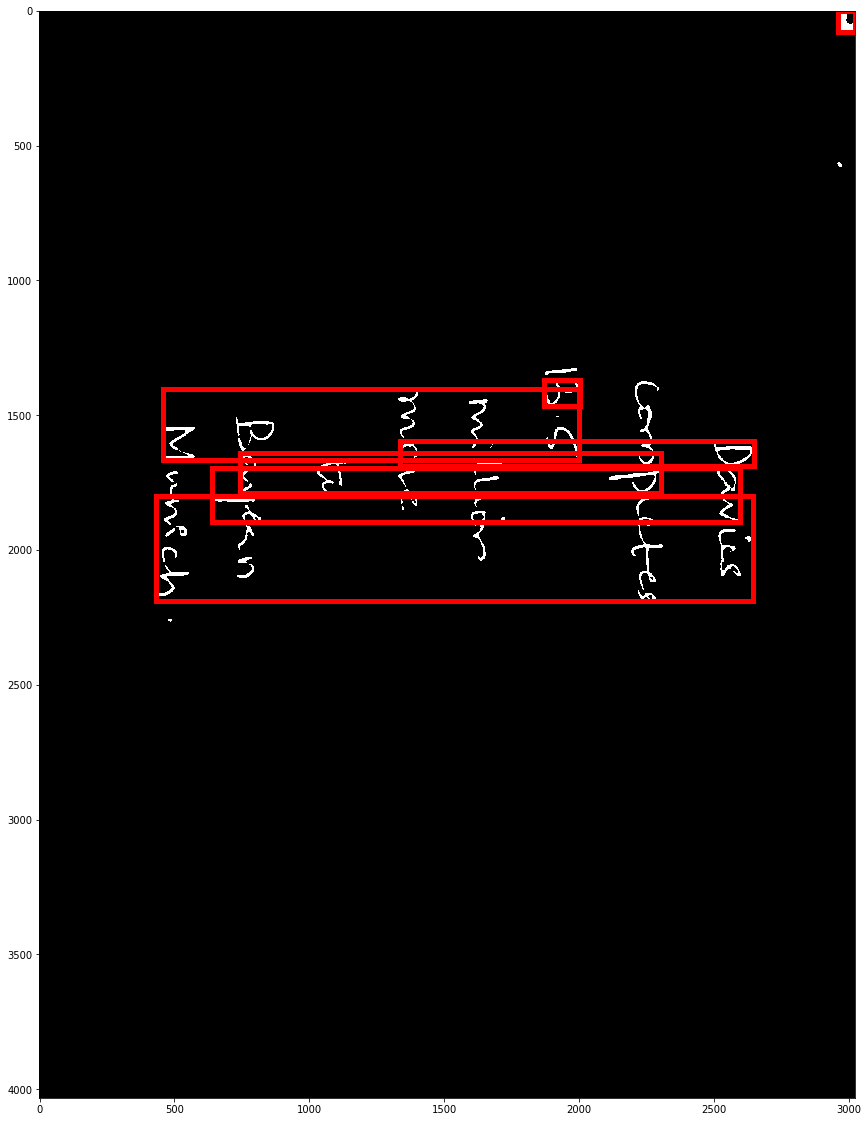

64: ../admin/cursive_ai/camera_images/IMG_20180725_132248.jpg
text_span_along_w, text_span_along_h:  503 3136
image is rotated


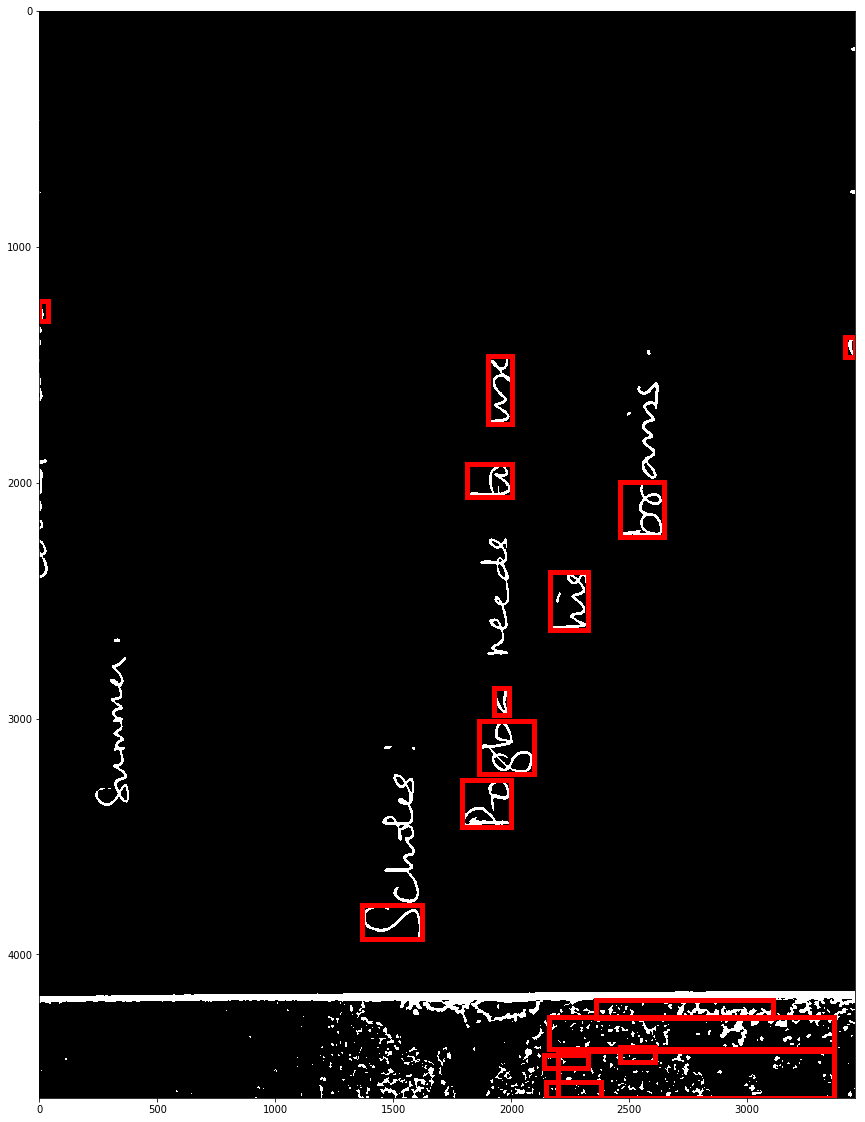

65: ../admin/cursive_ai/camera_images/IMG_20180725_132349.jpg
text_span_along_w, text_span_along_h:  4608 1303


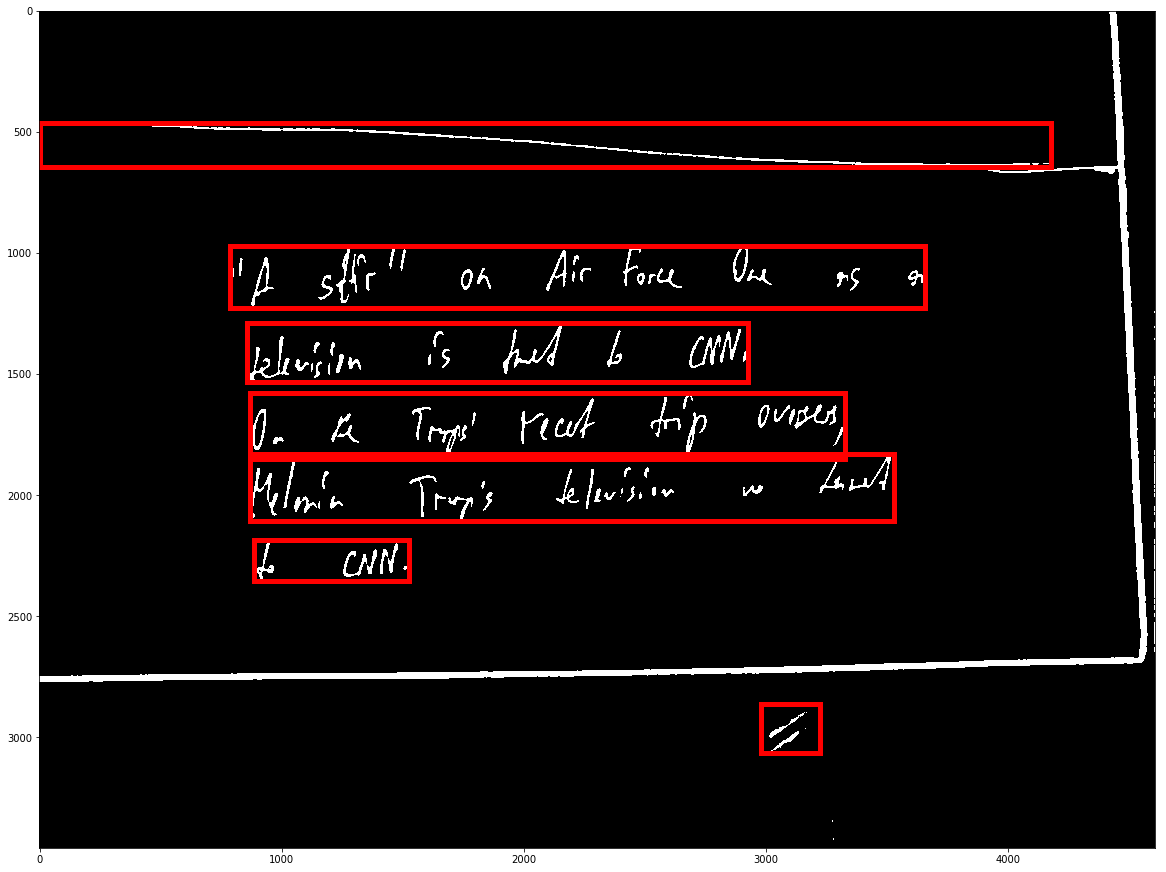

66: ../admin/cursive_ai/camera_images/IMG_20180725_132504.jpg
text_span_along_w, text_span_along_h:  536 4608
image is rotated


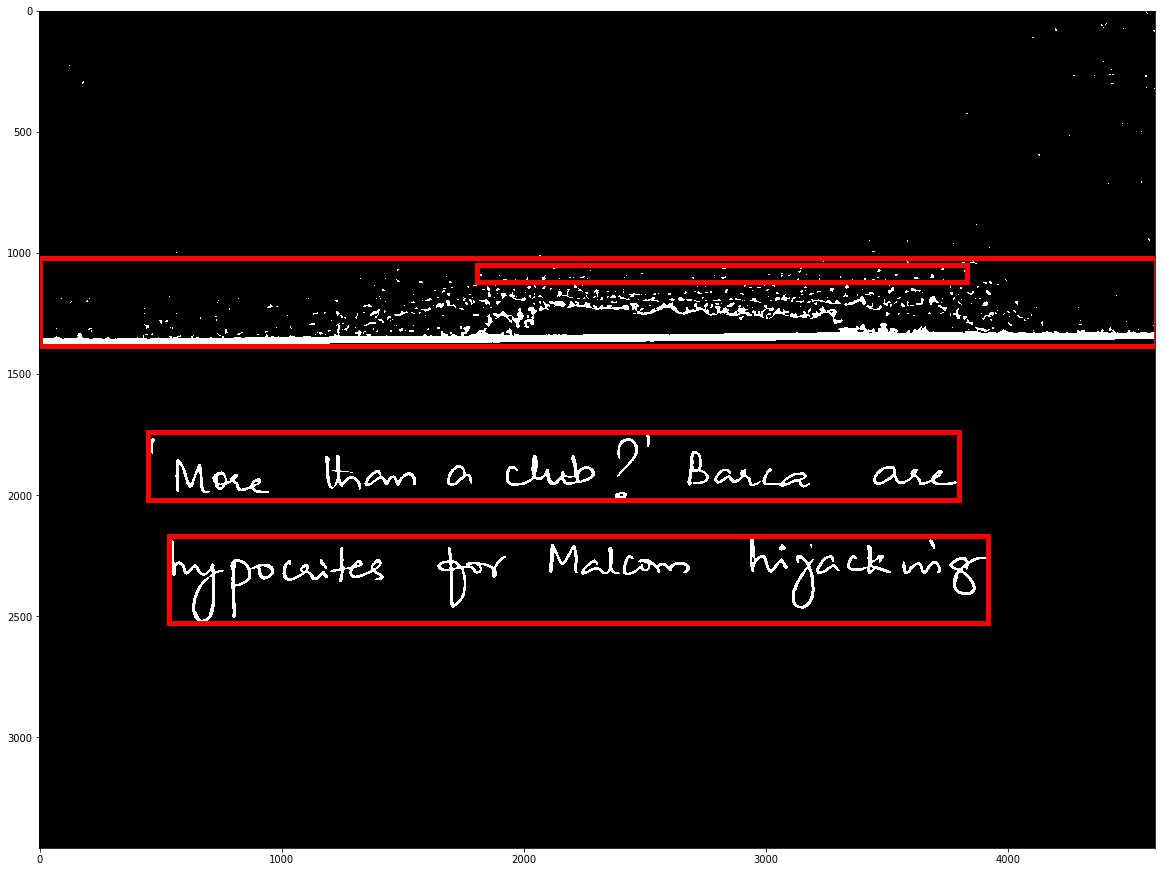

67: ../admin/cursive_ai/camera_images/IMG_6749.jpg
text_span_along_w, text_span_along_h:  574 1118
image is rotated


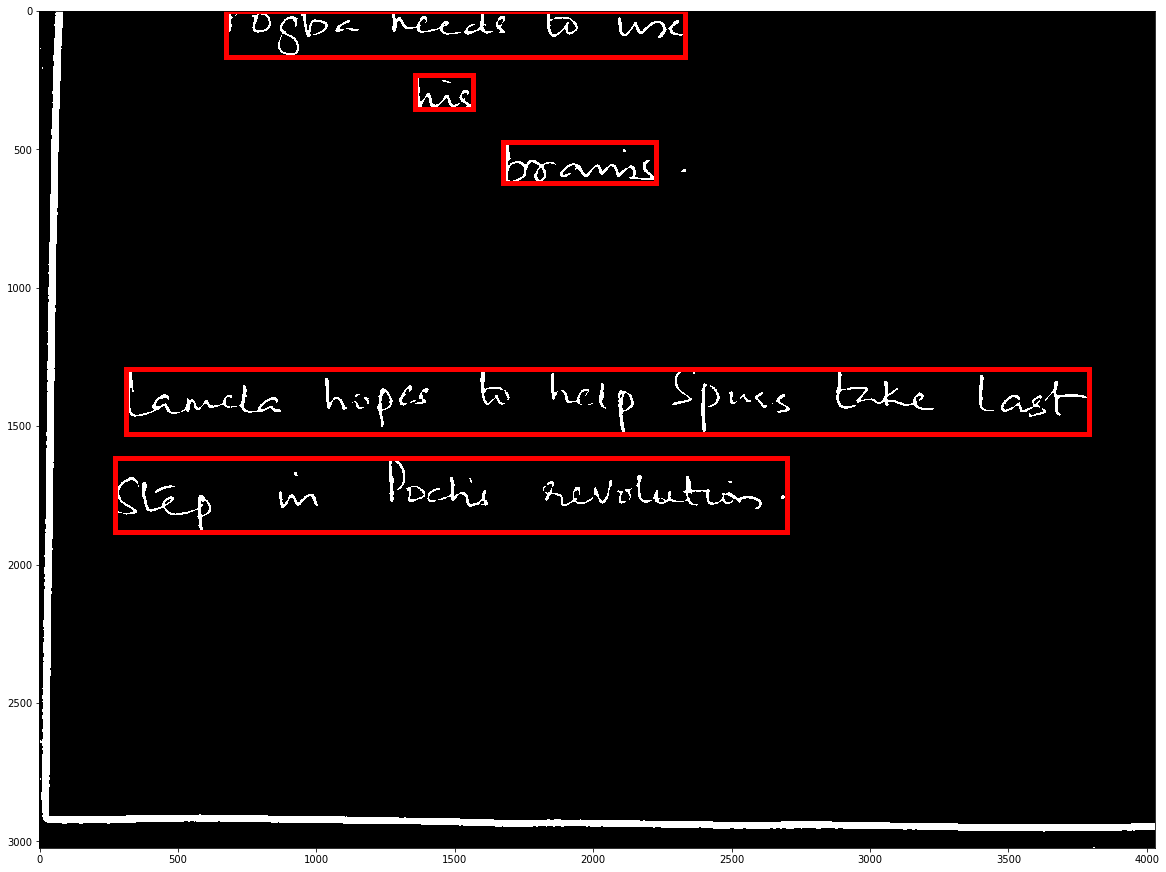

68: ../admin/cursive_ai/camera_images/IMG_20180725_132337.jpg
text_span_along_w, text_span_along_h:  4406 377


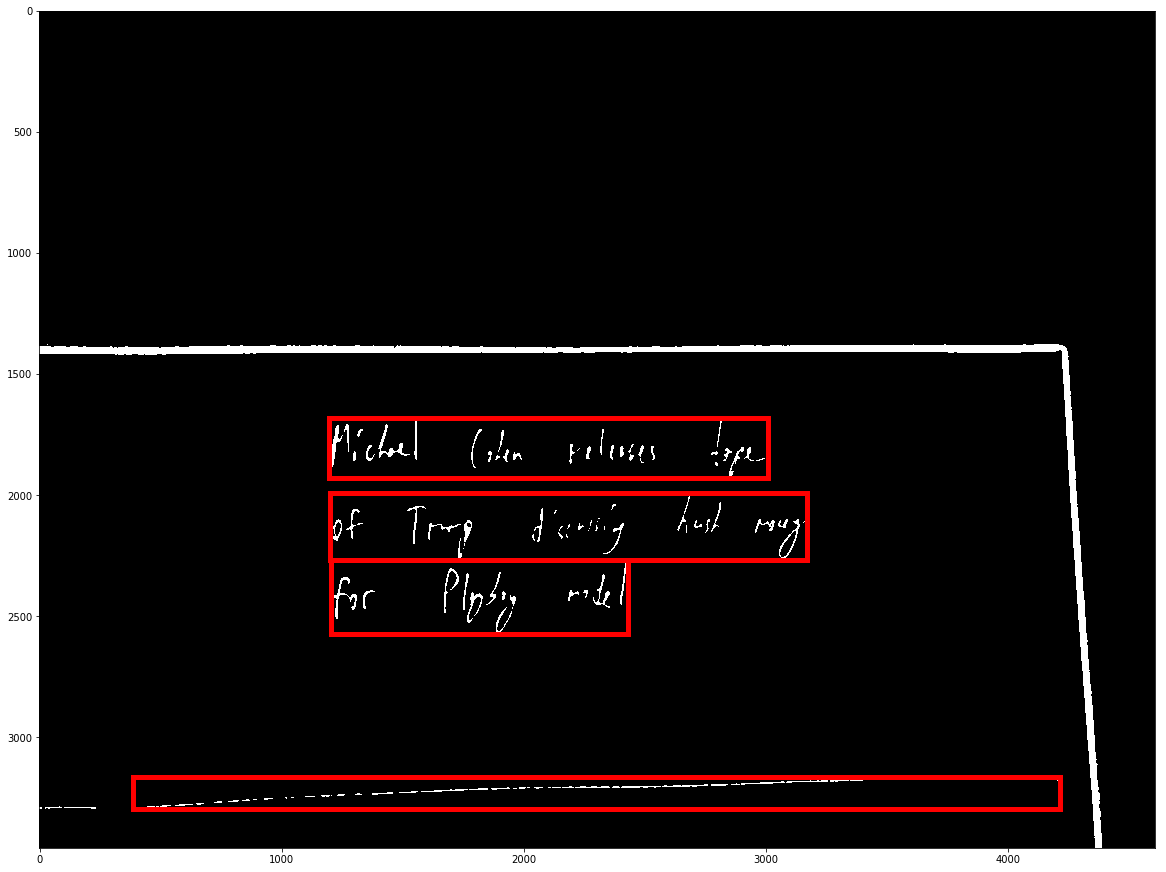

69: ../admin/cursive_ai/camera_images/IMG_20180725_132355.jpg
text_span_along_w, text_span_along_h:  4608 1637


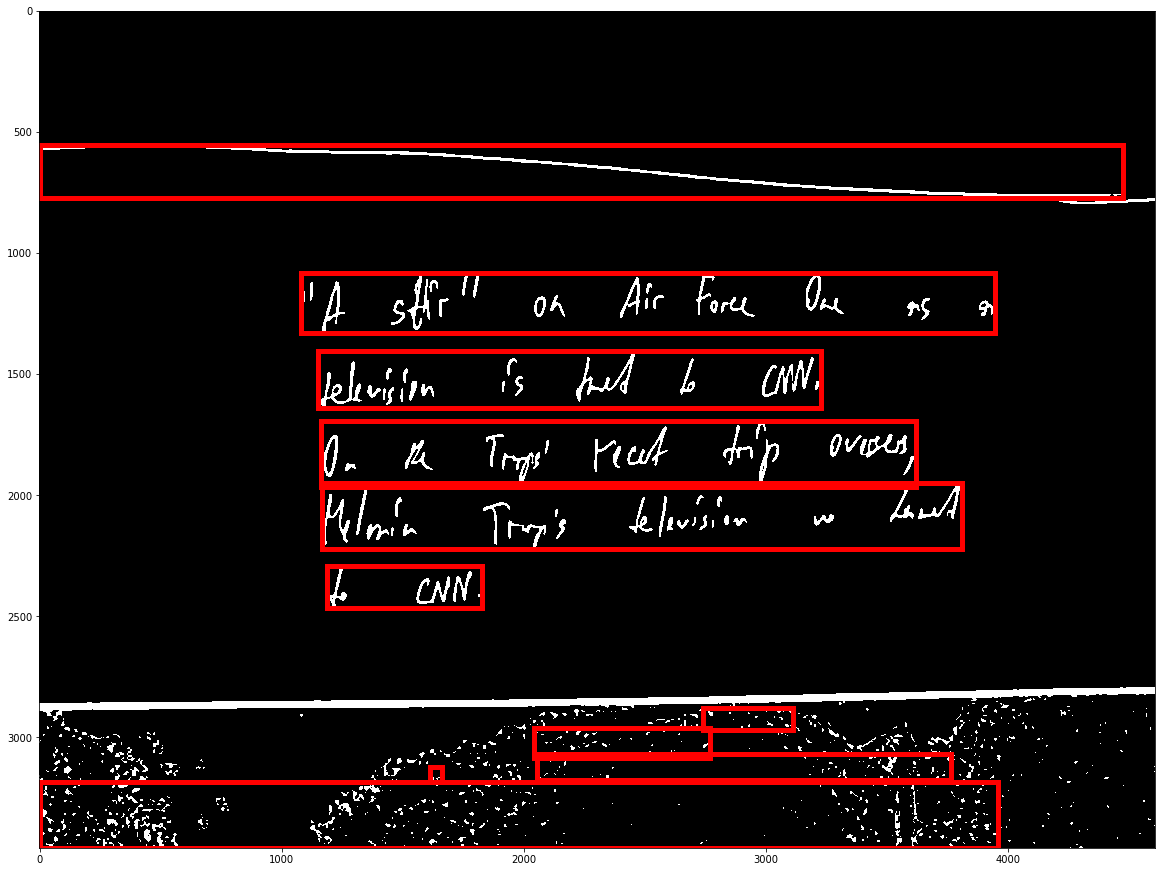

In [9]:
for i, image_filename in enumerate(image_filenames):
    print(f'{i}: {image_filename}')
    image = util.read_image(image_filename, grayscale=True)
    thresholded_image = tre.threshold_text_image(image, blur_kernel_size=21)
    white_text_image = (255 - thresholded_image).astype('uint8')
    
    text_span_along_w = get_text_span(white_text_image, axis=0, plot=False)
    text_span_along_h = get_text_span(white_text_image, axis=1, plot=False)
    print('text_span_along_w, text_span_along_h: ', text_span_along_w, text_span_along_h)
    image_to_be_rotated = text_span_along_w < text_span_along_h

    if image_to_be_rotated:
        print('image is rotated')
        white_text_image = np.rot90(white_text_image)

    regions, bboxes = extract_text_regions(
        white_text_image,
        merge_fully_overlapping_regions=True,
        params=None,
        merge_bboxes_in_line=True,
        plot=False
    )
    show_bboxes(bboxes, white_text_image)

In [ ]:
## 16 rotation errors 
## and other noise related errors